In [ ]:
import torch
import pickle

with open("nbest_log_dist.pkl", "rb") as file:
    nbest_log_distribution = pickle.load(file)

with open("asd_scores.pkl", "rb") as file:
    asd_scores = pickle.load(file)

def compute_masd_loss_ver2(nbest_log_distribution, asd_scores, normalized_asd=True):
    # Computes log distribution
    # (n, b) -> (b,): log( p1+p2+...+pn ) = log( exp(log_p1)+exp(log_p2)+...+exp(log_pn) )
    sum_nbest_log_distribution = torch.logsumexp(nbest_log_distribution, 0)
    print("nbest_log_distribution:", nbest_log_distribution.size(), nbest_log_distribution)
    print("sum_nbest_log_distribution:", sum_nbest_log_distribution.size(), sum_nbest_log_distribution)

    # Re-normalized over just the N-best hypotheses.
    # (n, b) - (b,) -> (n, b): exp(log_p)/exp(log_p_sum) = exp(log_p-log_p_sum)
    normal_nbest_distribution = torch.exp(nbest_log_distribution - sum_nbest_log_distribution)
    print("normal_nbest_distribution:", normal_nbest_distribution.size(), normal_nbest_distribution)

    if normalized_asd == True:
        mean_asd = torch.mean(asd_scores, 0)
        asd_norm = asd_scores - mean_asd
        print("mean_asd:", mean_asd.size(), mean_asd)
        print("asd_norm:", asd_norm.size(), asd_norm)
        asd_loss = torch.sum(normal_nbest_distribution * asd_norm, 0)
    else:
        asd_loss = torch.sum(normal_nbest_distribution * asd_scores, 0)

    return asd_loss

asd_loss = compute_masd_loss_ver2(nbest_log_distribution, asd_scores, normalized_asd=False)
print("asd_loss:", asd_loss)
print("asd_loss_mean:", torch.mean(asd_loss))

### Dev Set Average Scores

In [1]:
import pandas as pd
import numpy as np

# df1 = pd.read_csv("../../datasets/IS25_devset/dev_set.csv")
# df2 = pd.read_csv("../../datasets/IS25_devset/trial74_dev_set.csv")
# diff = df1.compare(df2)
# print(diff)

def get_log_info(log_history_path):
    wer_list = []
    asd_list = []
    with open(log_history_path, "r") as f:
        data = f.read().split("}, {")
    for item in data:
        log_item = (item.split(", "))
        for x in log_item:
            if "eval_wer" in x:
                wer_list.append(float(x.split(":")[1].strip()))
            elif "eval_asd" in x:
                asd_list.append(float(x.split(":")[1].strip()))

    wer_arr = np.array(wer_list)
    asd_arr = np.array(asd_list)
    print("WER:", np.mean(wer_arr))
    print("ASD:", np.mean(asd_arr))

log_history_paths = ["../../model_ckpts/fine-tuning_wav2vec2_asd_trial74_masd_6ep_allDataSmall_aulus6/runs/log_history.txt",
                     "../../model_ckpts/fine-tuning_wav2vec2_asd_trial71_masd_6ep_allDataSmall_aulus7/runs/log_history.txt",
                     "../../model_ckpts/fine-tuning_wav2vec2_asd_trial68_masd_6ep_allDataSmall_aulus6/runs/log_history.txt",
                     "../../model_ckpts/fine-tuning_wav2vec2_asd_trial60_masd_6ep_allDataSmall_titan1/runs/log_history.txt",
                     "../../model_ckpts/fine-tuning_wav2vec2_asd_trial69_masd_6ep_allDataSmall_aulus6/runs/log_history.txt",
                     "../../model_ckpts/fine-tuning_wav2vec2_asd_origloss_6ep_allDataSmall_aulus7/runs/log_history.txt",
                     "../../model_ckpts/fine-tuning_wav2vec2_asd_trial76_masd_6ep_allDataSmall_aulus6/runs/log_history.txt"]

for path in log_history_paths:
    print(path.split("/")[3])
    get_log_info(path)
    print("\n")


fine-tuning_wav2vec2_asd_trial74_masd_6ep_allDataSmall_aulus6
WER: 0.11566186522201408
ASD: 0.0912799769379054


fine-tuning_wav2vec2_asd_trial71_masd_6ep_allDataSmall_aulus7
WER: 0.11452481871106118
ASD: 0.08825652911269921


fine-tuning_wav2vec2_asd_trial68_masd_6ep_allDataSmall_aulus6
WER: 0.11638675984370303
ASD: 0.08855505280725691


fine-tuning_wav2vec2_asd_trial60_masd_6ep_allDataSmall_titan1
WER: 0.10980625643666322
ASD: 0.0863335966812446


fine-tuning_wav2vec2_asd_trial69_masd_6ep_allDataSmall_aulus6
WER: 0.1111965325234118
ASD: 0.08987302913503997


fine-tuning_wav2vec2_asd_origloss_6ep_allDataSmall_aulus7
WER: 0.10637592788971369
ASD: 0.08539109747078852


fine-tuning_wav2vec2_asd_trial76_masd_6ep_allDataSmall_aulus6
WER: 0.9235293371231347
ASD: 0.5762788391343856




### NB Tale Datset Inspection

In [11]:
import pandas as pd
import os
from datasets import Dataset


def load_test_dataset(data_dir_list: list[str]):
    frames = []
    for path in data_dir_list:
        wavfile_data = []
        textfile_data = []
        for (root, dirs, files) in os.walk(path, topdown=True):
            for fn in files:
                if fn.endswith(".wav"):
                    wav_id = os.path.splitext(fn)[0]
                    path = os.path.join(root, fn)
                    wavfile_data.append((wav_id, fn, path))
                elif fn.endswith(".txt"):
                    text_id = os.path.splitext(fn)[0]
                    with open(os.path.join(root, fn), encoding="utf-8") as text_file:
                        text = text_file.read()
                    textfile_data.append((text_id, text))
                elif fn.endswith(".txt-utf8"):
                    text_id = os.path.splitext(fn)[0]
                    with open(os.path.join(root, fn), encoding="utf-8-sig") as text_file:
                        text = text_file.read()
                    textfile_data.append((text_id, text))
        df_wav = pd.DataFrame(wavfile_data, columns=["segment_id", "wav_file", "path"])
        df_wav = df_wav.set_index("segment_id")
        df_text = pd.DataFrame(textfile_data, columns=["segment_id", "text"])
        df_text = df_text.set_index("segment_id")
        dataset_df = df_wav.merge(df_text, left_index=True, right_index=True)
        frames.append(dataset_df)
    # concat to full dataframe
    full_dataset_df = pd.concat(frames)
    dataset = Dataset.from_pandas(full_dataset_df)
    return dataset, full_dataset_df


nbtale_dir = ["../../datasets/NordTrans_TUL/test/NB_Tale/"]

dataset, full_dataset_df = load_test_dataset(nbtale_dir)
full_dataset_df.reset_index(inplace=True)
full_dataset_df

,segment_id,wav_file,path,text
0,p1_g02_m2_5_x-free_cut_0,p1_g02_m2_5_x-free_cut_0.wav,../../datasets/NordTrans_TUL/test/NB_Tale/p1_g...,jeg er en førtifire år gammel mann som er veld...
1,p1_g02_m2_5_x-free_cut_1,p1_g02_m2_5_x-free_cut_1.wav,../../datasets/NordTrans_TUL/test/NB_Tale/p1_g...,jeg trener ungdommer og jeg er også spinningin...
2,p1_g02_m2_5_x-free_cut_10,p1_g02_m2_5_x-free_cut_10.wav,../../datasets/NordTrans_TUL/test/NB_Tale/p1_g...,ei ut av de dalsluktene så plutselig kom vi ru...
3,p1_g02_m2_5_x-free_cut_11,p1_g02_m2_5_x-free_cut_11.wav,../../datasets/NordTrans_TUL/test/NB_Tale/p1_g...,over i motsatt kjørebane og jeg er ikke så lit...
4,p1_g02_m2_5_x-free_cut_12,p1_g02_m2_5_x-free_cut_12.wav,../../datasets/NordTrans_TUL/test/NB_Tale/p1_g...,kjørefelt sånn at jeg måtte gå av sykkelen leg...
...,...,...,...,...
62,p1_g08_m2_5_x-free_cut_5,p1_g08_m2_5_x-free_cut_5.wav,../../datasets/NordTrans_TUL/test/NB_Tale/p1_g...,sendt fremragende senter for forskning som ble...
63,p1_g08_m2_5_x-free_cut_6,p1_g08_m2_5_x-free_cut_6.wav,../../datasets/NordTrans_TUL/test/NB_Tale/p1_g...,prøve å disaggregere konfliktstudiene fra å væ...
64,p1_g08_m2_5_x-free_cut_7,p1_g08_m2_5_x-free_cut_7.wav,../../datasets/NordTrans_TUL/test/NB_Tale/p1_g...,analysenivå som var mer relevant for konflikte...
65,p1_g08_m2_5_x-free_cut_8,p1_g08_m2_5_x-free_cut_8.wav,../../datasets/NordTrans_TUL/test/NB_Tale/p1_g...,innenfor et land og gjerne ofte bare en veldi...


In [17]:
part_group_list = []
for row in full_dataset_df.itertuples():
    segment_id = row.segment_id.split("_")
    part_group_list.append("_".join(segment_id[:-2]))
print(set(part_group_list))

{'p1_g07_m2_5_x-free', 'p1_g03_m2_4_x-free', 'p1_g04_m2_5_x-free', 'p1_g08_m2_5_x-free', 'p1_g02_m2_5_x-free'}


# Results - mASD

In [1]:
import pandas as pd
import os
import jiwer
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from transformers import BertModel, AutoModel, AutoModelForSequenceClassification
import re
from tqdm import tqdm
import numpy as np
import torch
from dtw import *
from scipy.spatial import distance
from tabulate import tabulate
from IPython.display import HTML, display
from scipy import stats
# pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
tqdm.pandas()

/home/janinelr/micromamba/envs/wav2vec_v2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
metric_modelname = 'ltg/norbert2'  # changed to latest version of NorBERT (20-Mar-2023)
metric_model = BertModel.from_pretrained(metric_modelname)
metric_tokenizer = AutoTokenizer.from_pretrained(metric_modelname)

# this is not working at the moment:
# metric_modelname = "ltg/norbert3-small"
# metric_model = AutoModel.from_pretrained(metric_modelname, trust_remote_code=True)
# metric_tokenizer = AutoTokenizer.from_pretrained(metric_modelname)

Some weights of the model checkpoint at ltg/norbert2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
vocabulary = metric_tokenizer.vocab

wordpiece_counter = 0
word_counter = 0
unused_token_counter = 0
for key, value in vocabulary.items():
    if "##" in key:
        wordpiece_counter += 1
    elif "unused" in key:
        unused_token_counter += 1
    elif "##" not in key:
        word_counter += 1
print(f"Total wordpieces: {wordpiece_counter}")
print(f"Total whole words: {word_counter}")
print(f"Total unused tokens: {unused_token_counter}")

print("vocab dict length:", len(vocabulary))

total_count = word_counter + wordpiece_counter + unused_token_counter
print("counter sum:", total_count)

Total wordpieces: 17087
Total whole words: 32917
Total unused tokens: 100
vocab dict length: 50104
counter sum: 50104


In [3]:
# FOR VISUAL INSPECTION OF ALIGNMENTS

def get_asd_alignment(tokenized_ref, tokenized_hyp, model):
    with torch.no_grad():
        model_output_ref = model(**tokenized_ref, output_hidden_states=True)
        model_output_hyp = model(**tokenized_hyp, output_hidden_states=True)
    hidden_states_ref = model_output_ref.hidden_states
    hidden_states_hyp = model_output_hyp.hidden_states
    all_layers_reference = [hidden_states_ref[1].squeeze(), hidden_states_ref[2].squeeze(), hidden_states_ref[3].squeeze(), hidden_states_ref[4].squeeze(),
                            hidden_states_ref[5].squeeze(), hidden_states_ref[6].squeeze(), hidden_states_ref[7].squeeze(), hidden_states_ref[8].squeeze(),
                            hidden_states_ref[9].squeeze(), hidden_states_ref[10].squeeze(), hidden_states_ref[11].squeeze(), hidden_states_ref[12].squeeze()]
    all_layers_hypothesis = [hidden_states_hyp[1].squeeze(), hidden_states_hyp[2].squeeze(), hidden_states_hyp[3].squeeze(), hidden_states_hyp[4].squeeze(),
                             hidden_states_hyp[5].squeeze(), hidden_states_hyp[6].squeeze(), hidden_states_hyp[7].squeeze(), hidden_states_hyp[8].squeeze(),
                             hidden_states_hyp[9].squeeze(), hidden_states_hyp[10].squeeze(), hidden_states_hyp[11].squeeze(), hidden_states_hyp[12].squeeze()]
    ref_embedding_sequence = torch.stack(all_layers_reference).mean(dim=0)
    hyp_embedding_sequence = torch.stack(all_layers_hypothesis).mean(dim=0)
    alignment = dtw(x=hyp_embedding_sequence, y=ref_embedding_sequence, dist_method="cosine", keep_internals=True)
    num_tokens = len(ref_embedding_sequence)
    asd_score = (alignment.distance / num_tokens)
    return alignment, ref_embedding_sequence, hyp_embedding_sequence, asd_score


def print_token_alignment(tokenizer, alignment, ref_embedding_sequence, hyp_embedding_sequence, ref_input_ids, hyp_input_ids):
    hyp_alignment_idxs = alignment.index1
    ref_alignment_idxs = alignment.index2

    hyp_alignment_input_ids = np.empty(len(hyp_alignment_idxs), dtype=int)
    for i, index in enumerate(hyp_alignment_idxs):
        hyp_alignment_input_ids[i] = (hyp_input_ids[index])
    hyp_alignment_input_ids_tensor = torch.from_numpy(hyp_alignment_input_ids)

    ref_alignment_input_ids = np.empty(len(ref_alignment_idxs), dtype=int)
    for i, index in enumerate(ref_alignment_idxs):
        ref_alignment_input_ids[i] = (ref_input_ids[index])
    ref_alignment_inpud_ids_tensor = torch.from_numpy(ref_alignment_input_ids)

    hyp_alignment_tokens = tokenizer.convert_ids_to_tokens(hyp_alignment_input_ids_tensor)
    ref_alignment_tokens = tokenizer.convert_ids_to_tokens(ref_alignment_inpud_ids_tensor)

    ref_alignment_token_embeddings = []
    for index in ref_alignment_idxs:
        ref_alignment_token_embeddings.append(ref_embedding_sequence[index])

    hyp_alignment_token_embeddings = []
    for index in hyp_alignment_idxs:
        hyp_alignment_token_embeddings.append(hyp_embedding_sequence[index])

    cosdist_alignment_tokens = []
    for i in range(len(ref_alignment_token_embeddings)):
        ref_embedding = ref_alignment_token_embeddings[i]
        hyp_embedding = hyp_alignment_token_embeddings[i]
        cosdist_alignment_tokens.append(round((distance.cosine(ref_embedding, hyp_embedding)), 3))
    hyp_alignment_tokens.insert(0, "HYP:")
    ref_alignment_tokens.insert(0, "REF:")
    cosdist_alignment_tokens.insert(0, "CosDist:")
    alignment_table = [ref_alignment_tokens, hyp_alignment_tokens, cosdist_alignment_tokens]
    table = tabulate(alignment_table, tablefmt="html")

    print("Token alignment table:")
    display(HTML(table))

    # print("ASD score from alignment:", total_dist/len(ref_alignment_token_embeddings))

In [5]:
# metric_modelname = "bert-base-multilingual-cased"
# metric_model_multi = BertModel.from_pretrained(metric_modelname)
# metric_tokenizer_multi = AutoTokenizer.from_pretrained(metric_modelname)

# def compute_asd_score_single_utt(model, tokenizer, reference, hypothesis, normalized=True):
#     ref_text = re.sub(r"\s+", " ", reference.replace("[UNK]", ""))
#     hyp_text = re.sub(r"\s+", " ", hypothesis.replace("[UNK]", "").replace("</s>", ""))
#     tokenized_ref = tokenizer(ref_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
#     tokenized_hyp = tokenizer(hyp_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
#     with torch.no_grad():
#         model_output_ref = model(**tokenized_ref, output_hidden_states=True)
#         model_output_hyp = model(**tokenized_hyp, output_hidden_states=True)
#     hidden_states_ref = model_output_ref.hidden_states
#     hidden_states_hyp = model_output_hyp.hidden_states
#     all_layers_reference = [hidden_states_ref[1].squeeze(), hidden_states_ref[2].squeeze(), hidden_states_ref[3].squeeze(), hidden_states_ref[4].squeeze(),
#                             hidden_states_ref[5].squeeze(), hidden_states_ref[6].squeeze(), hidden_states_ref[7].squeeze(), hidden_states_ref[8].squeeze(),
#                             hidden_states_ref[9].squeeze(), hidden_states_ref[10].squeeze(), hidden_states_ref[11].squeeze(), hidden_states_ref[12].squeeze()]
#     all_layers_hypothesis = [hidden_states_hyp[1].squeeze(), hidden_states_hyp[2].squeeze(), hidden_states_hyp[3].squeeze(), hidden_states_hyp[4].squeeze(),
#                                 hidden_states_hyp[5].squeeze(), hidden_states_hyp[6].squeeze(), hidden_states_hyp[7].squeeze(), hidden_states_hyp[8].squeeze(),
#                                 hidden_states_hyp[9].squeeze(), hidden_states_hyp[10].squeeze(), hidden_states_hyp[11].squeeze(), hidden_states_hyp[12].squeeze()]
#     output_mean_reference = torch.stack(all_layers_reference).mean(dim=0)
#     output_mean_hypothesis = torch.stack(all_layers_hypothesis).mean(dim=0)
#     alignment = dtw(output_mean_hypothesis, output_mean_reference, dist_method=distance.cosine, keep_internals=True)
#     num_tokens = len(output_mean_reference)
#     if normalized == True:
#         asd_score = alignment.distance / num_tokens
#     else:
#         asd_score = alignment.distance
#     return asd_score

In [4]:
def merge_test_results(mod_loss_results, orig_loss_results):
    merged_results = orig_loss_results.join(mod_loss_results.set_index("segment_id"), on="segment_id")
    merged_results = merged_results[['segment_id', 'ref_str', 'orig_asr', 'orig_cer', 'orig_wer', 'orig_asd', 'mod_asr', 'mod_cer', 'mod_wer', 'mod_asd']]
    return merged_results

def load_csv_to_df(csv_file, mod_loss):
    results_df = pd.read_csv(csv_file, index_col=0)
    if mod_loss == True:
        results_df = results_df.drop(labels=["wav_file", "path", "text", "ref_str"], axis="columns")
        results_df = results_df.rename(columns={"asr_str":"mod_asr", "wer":"mod_wer", "asd":"mod_asd", "cer":"mod_cer"})
    else:
        results_df = results_df.drop(labels=["wav_file", "path", "text"], axis="columns")
        results_df = results_df.rename(columns={"asr_str":"orig_asr", "wer":"orig_wer", "asd":"orig_asd", "cer":"orig_cer"})
    return results_df

def load_results_to_df(dir_path, mod_loss):
    df_list = []
    for (root, dirs, files) in os.walk(dir_path, topdown=True):
        for fn in files:
            if fn.endswith(".csv"):
                csv_path = os.path.join(dir_path, fn)
                df_list.append(load_csv_to_df(csv_path, mod_loss))
    return pd.concat(df_list, axis=0, ignore_index=True)


In [5]:
pos_model_dir = "../../nlp_models/ner_pos/finetuned_bert_pos_v2"
tokenizer = AutoTokenizer.from_pretrained(pos_model_dir)
model = AutoModelForTokenClassification.from_pretrained(pos_model_dir)
nlp_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

label_list_pos = ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', 'ADV', 'INTJ', 'VERB', 'AUX']

def get_pos_tags(nlp_pipeline, text, label_list_pos):
    pos_tags = nlp_pipeline(text)

    # merging subword tokens and making word list wiht pos tag list
    labels = [label_list_pos[int(x["entity"].split("_")[1])] for x in pos_tags]
    sub_words = [x["word"] for x in pos_tags]
    idx_for_labels = []
    for i, item in enumerate(sub_words):
        if item[0:2] != "##":
            if i < len(sub_words) - 1 and sub_words[i+1][0:2] != "##":
                idx_for_labels.append(i)
            elif i == len(sub_words) - 1:
                idx_for_labels.append(i)
        if item[0:2] == "##" and sub_words[i-1][0:2] != "##":
            sub_word_combined = []
            sub_word_combined.append(i-1)
            if i < len(sub_words) - 1 and sub_words[i+1][0:2] != "##":
                sub_word_combined.append(i+1)
                idx_for_labels.append(sub_word_combined)
            elif i == len(sub_words) - 1:
                sub_word_combined.append(i+1)
                idx_for_labels.append(sub_word_combined)
        elif item[0:2] == "##" and sub_words[i-1][0:2] == "##":
            if i < len(sub_words) - 1 and sub_words[i+1][0:2] != "##":
                sub_word_combined.append(i+1)
                idx_for_labels.append(sub_word_combined)
            elif i == len(sub_words) - 1:
                sub_word_combined.append(i+1)
                idx_for_labels.append(sub_word_combined)
    new_word_list = []
    new_label_list = []
    for idx in idx_for_labels:
        if type(idx) is int:
            new_word_list.append(sub_words[idx])
            new_label_list.append(labels[idx])
        else:
            new_word_list.append("".join(sub_words[idx[0]:idx[1]]).replace("##", ""))
            new_label_list.append(labels[idx[0]])

    return new_word_list, new_label_list


def extract_errors_pos_tags(sub_count, ins_count, del_count, pos_tags, alignment, ref_labels, hyp_labels,
                            ref_words, hyp_words):

    label_list_pos = ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', 'ADV', 'INTJ', 'VERB', 'AUX']

    sub = 0
    ins = 0
    dele = 0
    pos = []
    # ref_error_words = []
    # asr_error_words = []
    error_dict = []
    pos_err_count = np.zeros(len(label_list_pos))

    for i in range(len(alignment)):
        ref_start = alignment[i].ref_start_idx
        ref_end = alignment[i].ref_end_idx
        hyp_start = alignment[i].hyp_start_idx
        hyp_end = alignment[i].hyp_end_idx

        if alignment[i].type != "equal":
            errors = {
                "type": alignment[i].type,
                "ref": ref_words[ref_start:ref_end],
                "ref_pos": ref_labels[ref_start:ref_end],
                "hyp": hyp_words[hyp_start:hyp_end],
                "hyp_pos": hyp_labels[hyp_start:hyp_end]
            }
            error_dict.append(errors)
            if alignment[i].type == "insert":
                hyp_pos = hyp_labels[hyp_start:hyp_end]
                for tag in hyp_pos:
                    pos_err_count[label_list_pos.index(tag)] += 1
            elif alignment[i].type == "substitute":
                ref_pos = ref_labels[ref_start:ref_end]
                for tag in ref_pos:
                    pos_err_count[label_list_pos.index(tag)] += 1
                hyp_pos = hyp_labels[hyp_start:hyp_end]
                for tag in hyp_pos:
                    pos_err_count[label_list_pos.index(tag)] += 1
            elif alignment[i].type == "insert":
                hyp_pos = hyp_labels[hyp_start:hyp_end]
                for tag in hyp_pos:
                    pos_err_count[label_list_pos.index(tag)] += 1

        if alignment[i].type == "substitute":
            for item in ref_labels[ref_start:ref_end]:
                pos.append(item)
                sub += 1
            for item in hyp_labels[hyp_start:hyp_end]:
                pos.append(item)
            # for i, word in enumerate(ref_words[ref_start:ref_end]):
            #     ref_words[ref_start+i] = word.upper()
            #     ref_error_words.append(word)
            # for i, word in enumerate(hyp_words[ref_start:ref_end]):
            #     hyp_words[ref_start+i] = word.upper()
            #     asr_error_words.append(word)
        elif alignment[i].type == "insert":
            for item in hyp_labels[hyp_start:hyp_end]:
                pos.append(item)
                ins += 1
            # for i, word in enumerate(hyp_words[ref_start:ref_end]):
            #     hyp_words[ref_start+i] = word.upper()
            #     asr_error_words.append(word)
        elif alignment[i].type == "delete":
            for item in ref_labels[ref_start:ref_end]:
                pos.append(item)
                dele += 1
            # for i, word in enumerate(ref_words[ref_start:ref_end]):
            #     ref_words[ref_start+i] = word.upper()
            #     ref_error_words.append(word)

    sub_count.append(sub)
    ins_count.append(ins)
    del_count.append(dele)
    pos_tags.append(pos)

    error_ref_text = " ".join(ref_words)
    error_asr_text = " ".join(hyp_words)

    return error_ref_text, error_asr_text, error_dict, pos_err_count


def merge_df_wer_pos_tags(df, nlp_pipeline, label_list_pos):
    mod_error_ref = []
    mod_error_asr = []
    # mod_ref_error_words = []
    # mod_asr_error_words = []
    mod_error_dict_list = []
    mod_pos_err_count_list = []

    orig_error_ref = []
    orig_error_asr = []
    # orig_ref_error_words = []
    # orig_asr_error_words = []
    orig_error_dict_list = []
    orig_pos_err_count_list = []

    mod_sub_count = []
    mod_ins_count = []
    mod_del_count = []
    mod_pos_tags = []

    orig_sub_count = []
    orig_ins_count = []
    orig_del_count = []
    orig_pos_tags = []

    for row in tqdm(df.itertuples(), total=df.shape[0], desc="Error Tagging"):
        ref_words, ref_labels = get_pos_tags(nlp_pipeline, row.ref_str, label_list_pos)
        orig_words, orig_labels = get_pos_tags(nlp_pipeline, row.orig_asr, label_list_pos)
        mod_words, mod_labels = get_pos_tags(nlp_pipeline, row.mod_asr, label_list_pos)
        out = jiwer.process_words([row.ref_str, row.ref_str], [row.orig_asr, row.mod_asr])
        orig_alignment = out.alignments[0]
        mod_alignment = out.alignments[1]

        # substitute, insert, delete
        mod_ref_text, mod_asr_text, mod_error_dict, mod_pos_err_count = extract_errors_pos_tags(mod_sub_count, mod_ins_count,
                                                                             mod_del_count, mod_pos_tags, mod_alignment,
                                                                             ref_labels, mod_labels, ref_words, mod_words)
        orig_ref_text, orig_asr_text, orig_error_dict, orig_pos_err_count = extract_errors_pos_tags(orig_sub_count, orig_ins_count,
                                                                                orig_del_count, orig_pos_tags,
                                                                                orig_alignment, ref_labels,
                                                                                orig_labels, ref_words, orig_words)

        # whole text of the utterances
        mod_error_ref.append(mod_ref_text)
        mod_error_asr.append(mod_asr_text)
        orig_error_ref.append(orig_ref_text)
        orig_error_asr.append(orig_asr_text)

        # specific words that are mistaken
        # mod_ref_error_words.append(mod_ref_error)
        # mod_asr_error_words.append(mod_asr_error)
        # orig_ref_error_words.append(orig_ref_error)
        # orig_asr_error_words.append(orig_asr_error)

        # dictionary of wrong words
        mod_error_dict_list.append(mod_error_dict)
        mod_pos_err_count_list.append(mod_pos_err_count)
        orig_error_dict_list.append(orig_error_dict)
        orig_pos_err_count_list.append(orig_pos_err_count)

    df.drop(labels=["ref_str", "orig_asr", "mod_asr"], axis="columns", inplace=True)

    df["orig_ref"] = orig_error_ref  # text/sentence form with uppercase errors
    df["orig_asr"] = orig_error_asr  # text/sentence form with uppercase errors
    # df["orig_ref_error_words"] = orig_ref_error_words
    # df["orig_asr_error_words"] = orig_asr_error_words
    df["orig_error_dict"] = orig_error_dict_list
    df["orig_pos_err_count"] = orig_pos_err_count_list

    df["orig_sub"] = orig_sub_count
    df["orig_ins"] = orig_ins_count
    df["orig_del"] = orig_del_count
    df["orig_pos_tags"] = orig_pos_tags

    df["mod_ref"] = mod_error_ref  # text/sentence form with uppercase errors
    df["mod_asr"] = mod_error_asr  # text/sentence form with uppercase errors
    # df["mod_ref_error_words"] = mod_ref_error_words
    # df["mod_asr_error_words"] = mod_asr_error_words
    df["mod_error_dict"] = mod_error_dict_list
    df["mod_pos_err_count"] = mod_pos_err_count_list

    df["mod_sub"] = mod_sub_count
    df["mod_ins"] = mod_ins_count
    df["mod_del"] = mod_del_count
    df["mod_pos_tags"] = mod_pos_tags

    return df

In [8]:
# # loading the test transcriptions
# path = "./logs/trial35_masd_RundkastOnly_aulus7"
# mod_results = load_results_to_df(path, mod_loss=True)
# path = "./logs/trial_origloss_RundkastOnly_aulus7"
# orig_results = load_results_to_df(path, mod_loss=False)

# merged_results = merge_test_results(mod_results, orig_results)

# # higher asd score but lower wer when using modified loss
# mod_higher_asd = merged_results[merged_results["orig_asd"] < merged_results["mod_asd"]]
# mod_higher_asd = mod_higher_asd[mod_higher_asd["mod_wer"] < mod_higher_asd["orig_wer"]]
# mod_higher_asd = mod_higher_asd[mod_higher_asd["orig_wer"] < 1]
# print("higher ASD with mod loss:", len(mod_higher_asd))

# # lower asd score but higher wer when using modified loss
# mod_lower_asd = merged_results[merged_results["mod_asd"] < merged_results["orig_asd"]]
# mod_lower_asd = mod_lower_asd[mod_lower_asd["mod_wer"] >= mod_lower_asd["orig_wer"]]
# mod_lower_asd = mod_lower_asd[mod_lower_asd["orig_wer"] < 1]
# print("lower ASD with mod loss:", len(mod_lower_asd))

# # merged full results to compare POS tags of orig loss & mod loss transcriptions
# df_pos = merge_df_wer_pos_tags(merged_results.copy(deep=True), nlp_pipeline, label_list_pos).reset_index(drop=True)

# df_a = pd.Series(np.concatenate(df_pos.mod_pos_tags))
# df_mod_pos_count = df_a.groupby(df_a).size().rename_axis('mod_pos_tags').reset_index(name='count')
# print("mod loss pos errors:", df_mod_pos_count["count"].sum(axis=0))
# print(df_mod_pos_count)

# df_b = pd.Series(np.concatenate(df_pos.orig_pos_tags))
# df_orig_pos_count = df_b.groupby(df_b).size().rename_axis('orig_pos_tags').reset_index(name='count')
# print("orig loss pos errors:", df_orig_pos_count["count"].sum(axis=0))
# print(df_orig_pos_count)

### Loading results & POS tagging

In [6]:
# loading the test transcriptions
mod_results = load_results_to_df("./logs/trial60_masd_6ep_allDataSmall_titan1", mod_loss=True)
orig_results = load_results_to_df("./logs/trial_origloss_6ep_allDataSmall_aulus7", mod_loss=False)

merged_results = merge_test_results(mod_results, orig_results)

# higher asd score but lower wer when using modified loss
mod_higher_asd_df = merged_results[merged_results["orig_asd"] < merged_results["mod_asd"]]
mod_higher_asd_df = mod_higher_asd_df[mod_higher_asd_df["mod_wer"] < mod_higher_asd_df["orig_wer"]]
mod_higher_asd_df = mod_higher_asd_df[mod_higher_asd_df["orig_wer"] < 1]
print("higher ASD but lower WER - using mod loss:", len(mod_higher_asd_df))

# lower asd score but higher wer when using modified loss
mod_lower_asd_df = merged_results[merged_results["mod_asd"] < merged_results["orig_asd"]]
mod_lower_asd_df = mod_lower_asd_df[mod_lower_asd_df["mod_wer"] >= mod_lower_asd_df["orig_wer"]]
mod_lower_asd_df = mod_lower_asd_df[mod_lower_asd_df["orig_wer"] < 1]
print("lower ASD but higher or equal WER - using mod loss:", len(mod_lower_asd_df))

higher ASD but lower WER - using mod loss: 7
lower ASD but higher or equal WER - using mod loss: 222


In [153]:
# multi_mod = []
# multi_orig = []

# for row in tqdm(merged_results.itertuples(), total=merged_results.shape[0], desc="multi-ASD scoring"):
#     multi_orig.append(compute_asd_score_single_utt(metric_model_multi, metric_tokenizer_multi, row.ref_str, row.orig_asr, normalized=True))
#     multi_mod.append(compute_asd_score_single_utt(metric_model_multi, metric_tokenizer_multi, row.ref_str, row.mod_asr, normalized=True))

# merged_results["orig_multi-asd"] = multi_orig
# merged_results["mod_multi-asd"] = multi_mod

### POS error count (NOT equal CER utterances)

In [7]:
# merged full results to compare POS tags of orig loss & mod loss transcriptions

not_equal_cer = merged_results[merged_results["mod_cer"] != merged_results["orig_cer"]]
df_pos = merge_df_wer_pos_tags(not_equal_cer.copy(deep=True), nlp_pipeline, label_list_pos).reset_index(drop=True)
# df_pos = merge_df_wer_pos_tags(merged_results.copy(deep=True), nlp_pipeline, label_list_pos).reset_index(drop=True)
print("number of utterances for POS analysis:", len(df_pos))

# df_pos = merge_df_wer_pos_tags(merged_results.copy(deep=True), nlp_pipeline, label_list_pos).reset_index(drop=True)
# print("number of utterances for POS analysis:", len(df_pos))

df_a = pd.Series(np.concatenate(df_pos.mod_pos_tags))
df_mod_pos_count = df_a.groupby(df_a).size().rename_axis('pos_tags').reset_index(name='CTC+ASD')
print("mod loss pos errors:", df_mod_pos_count["CTC+ASD"].sum(axis=0))

df_b = pd.Series(np.concatenate(df_pos.orig_pos_tags))
df_orig_pos_count = df_b.groupby(df_b).size().rename_axis('pos_tags').reset_index(name='CTC')
print("orig loss pos errors:", df_orig_pos_count["CTC"].sum(axis=0))

Error Tagging: 100%|██████████| 382/382 [00:34<00:00, 11.18it/s]

number of utterances for POS analysis: 382
mod loss pos errors: 2817
orig loss pos errors: 2885


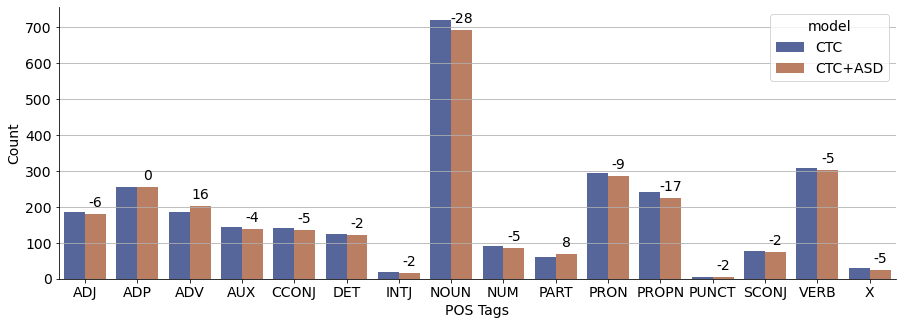

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib import rcParams
plt.rcParams.update({'font.size': 14, 'pdf.fonttype':42})

merged_pos_count = pd.merge(df_orig_pos_count, df_mod_pos_count, on=["pos_tags"])
merged_pos_count = pd.melt(merged_pos_count, id_vars=["pos_tags"], value_vars=["CTC", "CTC+ASD"])
merged_pos_count = merged_pos_count.rename(columns={"variable":"model", "value":"count"})
# merged_pos_count = merged_pos_count.sort_values(by=["count"], ascending=False).reset_index(drop=True)

deltas = (df_mod_pos_count["CTC+ASD"] - df_orig_pos_count["CTC"]).to_list()
deltas_df = pd.DataFrame(df_mod_pos_count["pos_tags"])
deltas_df["delta"] = deltas
deltas_df["y_pos"] = df_mod_pos_count["CTC+ASD"] + 20
deltas_df["x_pos"] = [x+0.2 for x in range(16)]

fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(data=merged_pos_count, x="pos_tags", y="count", hue="model", palette="dark", alpha=0.7)
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='y')
ax.set_ylabel("Count")
ax.set_xlabel("POS Tags")
for row in deltas_df.itertuples():
    ax.text(x=row.x_pos, y=row.y_pos, s=row.delta, color="black", ha="center")
# sns.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
plt.show()

- among the nouns that were wrong, look at the lemmas
- look at the adpositions and pronouns as well
- is ASD making improvements, where are the differences?

In [11]:
fig.savefig("./plots/pos_hist.pdf")
# merged_pos_count.to_csv("./plots/pos_count.csv")

In [11]:
# higher asd score but lower wer when using modified loss
mod_higher_asd_df = df_pos[df_pos["orig_asd"] < df_pos["mod_asd"]]
mod_higher_asd_df = mod_higher_asd_df[mod_higher_asd_df["mod_wer"] < mod_higher_asd_df["orig_wer"]]
mod_higher_asd_df = mod_higher_asd_df[mod_higher_asd_df["orig_wer"] < 1]
print("higher ASD but lower WER - using mod loss:", len(mod_higher_asd_df))

# lower asd score but higher wer when using modified loss
mod_lower_asd_df = df_pos[df_pos["mod_asd"] < df_pos["orig_asd"]]
mod_lower_asd_df = mod_lower_asd_df[mod_lower_asd_df["mod_wer"] >= mod_lower_asd_df["orig_wer"]]
mod_lower_asd_df = mod_lower_asd_df[mod_lower_asd_df["orig_wer"] < 1]
print("lower ASD but higher or equal WER - using mod loss:", len(mod_lower_asd_df))

higher ASD but lower WER - using mod loss: 6
lower ASD but higher or equal WER - using mod loss: 47


### Linear Regression between POS errors & ASD

- instead of a correlation analysis, perform regression analysis!

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [13]:
linreg_df = merge_df_wer_pos_tags(merged_results.copy(deep=True), nlp_pipeline, label_list_pos).reset_index(drop=True)

Error Tagging: 100%|██████████| 829/829 [01:16<00:00, 10.84it/s]


In [14]:
error_data = linreg_df.mod_pos_err_count.tolist()
label_list_pos = ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', 'ADV', 'INTJ', 'VERB', 'AUX']
X = pd.DataFrame(error_data, columns=label_list_pos)
# X = X.drop(labels=['PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'X', 'ADV', 'INTJ', 'AUX'], axis="columns")
Y = linreg_df.mod_asd

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

print('REGRESSION MODEL TO PREDICT ASD:')

Y_pred_train = model.predict(X_train)
print('Results on TRAIN set')
print('MSE: %.4f' % mean_squared_error(Y_train, Y_pred_train))
print('MAE: %.4f' % mean_absolute_error(Y_train, Y_pred_train))
print('R^2: %.4f' % r2_score(Y_train, Y_pred_train))

Y_pred_test = model.predict(X_test)
print('Results on TEST set')
print('MSE: %.4f' % mean_squared_error(Y_test, Y_pred_test))
print('MAE: %.4f' % mean_absolute_error(Y_test, Y_pred_test))
print('R^2: %.4f' % r2_score(Y_test, Y_pred_test))

REGRESSION MODEL TO PREDICT ASD:
Results on TRAIN set
MSE: 0.0065
MAE: 0.0573
R^2: 0.9327
Results on TEST set
MSE: 0.0048
MAE: 0.0522
R^2: 0.7026


In [15]:
X = pd.DataFrame(error_data, columns=label_list_pos)
# X = X.drop(labels=['PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'X', 'ADV', 'INTJ', 'AUX'], axis="columns")
Y = linreg_df.mod_wer

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

print('REGRESSION MODEL TO PREDICT WER:')

Y_pred_train = model.predict(X_train)
print('Results on TRAIN set')
print('MSE: %.4f' % mean_squared_error(Y_train, Y_pred_train))
print('MAE: %.4f' % mean_absolute_error(Y_train, Y_pred_train))
print('R^2: %.4f' % r2_score(Y_train, Y_pred_train))

Y_pred_test = model.predict(X_test)
print('Results on TEST set')
print('MSE: %.4f' % mean_squared_error(Y_test, Y_pred_test))
print('MAE: %.4f' % mean_absolute_error(Y_test, Y_pred_test))
print('R^2: %.4f' % r2_score(Y_test, Y_pred_test))

REGRESSION MODEL TO PREDICT WER:
Results on TRAIN set
MSE: 0.0063
MAE: 0.0523
R^2: 0.9606
Results on TEST set
MSE: 0.0056
MAE: 0.0544
R^2: 0.7010


In [143]:
X

,NOUN,PROPN,PRON,VERB
0,0.0,0.0,0.0,0.0
1,0.0,2.0,0.0,0.0
2,2.0,0.0,0.0,0.0
3,0.0,5.0,0.0,0.0
4,2.0,0.0,0.0,0.0
...,...,...,...,...
824,2.0,0.0,0.0,0.0
825,0.0,0.0,0.0,0.0
826,2.0,0.0,1.0,0.0
827,0.0,0.0,0.0,3.0


In [20]:
# label_list_pos = ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', 'ADV', 'INTJ', 'VERB', 'AUX']

# data_source = df_pos.copy(deep=True)
# data_source = data_source[data_source["mod_wer"] <= 0.2]
# data_source = data_source.reset_index(drop=True)

# data_matrix = np.zeros((len(label_list_pos),len(data_source)), dtype=int)
# for row_num, row in data_source.iterrows():
#     for idx, count in enumerate(row.mod_pos_err_count):
#         data_matrix[idx][row_num] += count

# asd_values = data_source.mod_asd
# wer_values = data_source.mod_wer

# pos_asd_pearson_stat = []
# pos_wer_pearson_stat = []
# for row_num, row in enumerate(data_matrix):
#     pos_item = label_list_pos[row_num]
#     pos_error = row
#     pos_asd_pearson_stat.append(stats.pearsonr(pos_error, asd_values)[0])
#     pos_wer_pearson_stat.append(stats.pearsonr(pos_error, wer_values)[0])

# pos_corr_df = pd.DataFrame(data=zip(label_list_pos, pos_asd_pearson_stat, pos_wer_pearson_stat), columns=["POS", "ASD_Pearson_r", "WER_Pearson_r"])
# pos_corr_ASDsorted_df = pos_corr_df.sort_values(by="ASD_Pearson_r", ascending=False)
# pos_corr_ASDsorted_df

### NER Experiment

In [17]:
from seqeval.metrics import f1_score, classification_report
import subprocess

finetuned_bert_ner = "../../nlp_models/ner_pos/finetuned_bert_ner_v1"
tokenizer = AutoTokenizer.from_pretrained(finetuned_bert_ner)
model = AutoModelForTokenClassification.from_pretrained(finetuned_bert_ner)
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

/home/janinelr/micromamba/envs/wav2vec_v2/lib/python3.9/site-packages/transformers/pipelines/token_classification.py:135: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


In [18]:
sclite_path = "../../aulus6_janinelr/kaldi/tools/sctk/bin/sclite"
sclite_output_dir = "./sclite_outputs/Interspeech2025"

label_list_ner = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-GPE_LOC', 'I-GPE_LOC', 'B-PROD', 'I-PROD', 'B-LOC', 'I-LOC', 'B-GPE_ORG', 'I-GPE_ORG', 'B-DRV', 'I-DRV', 'B-EVT', 'I-EVT', 'B-MISC', 'I-MISC']

In [19]:
def get_ner_tags(df, ner_pipeline):
    ref_tags = []
    mod_asr_tags = []
    orig_asr_tags = []
    for row in tqdm(df.itertuples(), total=df.shape[0], desc="NLP Tagging - ORIG ASR"):
        if (len(ner_pipeline(row.ref_str)) == 0) & (len(ner_pipeline(row.orig_asr)) == 0):
            ref_tags.append(None)
            mod_asr_tags.append(None)
        else:
            ref_tags.append(ner_pipeline(row.ref_str))
            mod_asr_tags.append(ner_pipeline(row.orig_asr))
    df["ref_ner_tags"] = ref_tags
    df["orig_asr_ner_tags"] = mod_asr_tags

    for row in tqdm(df.itertuples(), total=df.shape[0], desc="NLP Tagging - MOD ASR"):
        if (len(ner_pipeline(row.ref_str)) == 0) & (len(ner_pipeline(row.mod_asr)) == 0):
            ref_tags.append(None)
            orig_asr_tags.append(None)
        else:
            ref_tags.append(ner_pipeline(row.ref_str))
            orig_asr_tags.append(ner_pipeline(row.mod_asr))
    df["mod_asr_ner_tags"] = orig_asr_tags

    return df


# FUNCTION FOR NER ALIGNMENT
def get_ner_alignment(input_df, sclite_output_dir, sclite_path, label_list, mod_asr=True):
    df = input_df.copy(deep=True)
    # combining words and tags into string of text
    ref_tokenizedtext_list = []
    asr_tokenizedtext_list = []
    for row in tqdm(df.itertuples(), total=df.shape[0], desc="Extracting NER tags"):
        ref_labels = []
        asr_labels = []
        for item in row.ref_ner_tags:
            word_list = item['word'].split()
            for word in word_list:
                ref_labels.append(word + "_" + label_list[int(item['entity_group'].replace("LABEL_", ""))])
        if mod_asr == True:
            for item in row.mod_asr_ner_tags:
                word_list = item['word'].split()
                for word in word_list:
                    asr_labels.append(word + "_" + label_list[int(item['entity_group'].replace("LABEL_", ""))])
        else:
            for item in row.orig_asr_ner_tags:
                word_list = item['word'].split()
                for word in word_list:
                    asr_labels.append(word + "_" + label_list[int(item['entity_group'].replace("LABEL_", ""))])

        ref_tokenizedtext_list.append(' '.join([str(elem) for elem in ref_labels]))
        asr_tokenizedtext_list.append(' '.join([str(elem) for elem in asr_labels]))

    # using sclite to find the alignment
    with open(os.path.join(sclite_output_dir, "references.txt"), "w") as f:
        for idx, utterance in enumerate(ref_tokenizedtext_list):
            f.write(utterance + " (utt_" + str(idx) + ")" + "\n")
    with open(os.path.join(sclite_output_dir, "hypothesis.txt"), "w") as f:
        for idx, utterance in enumerate(asr_tokenizedtext_list):
            f.write(utterance + " (utt_" + str(idx) + ")" + "\n")
    sclite_path = sclite_path
    with open(os.path.join(sclite_output_dir, 'temp_output.txt'), 'a') as outfile:
        subprocess.run([
            sclite_path,
            '-r', os.path.join(sclite_output_dir, "references.txt"),
            '-h', os.path.join(sclite_output_dir, "hypothesis.txt"),
            '-i', 'rm',
            '-o', 'all'
        ], stdout=outfile)

    # placing alignment results into the dataframe
    with open(os.path.join(sclite_output_dir, "hypothesis.txt.pra")) as f:
        lines = f.readlines()
    ref_align_list = []
    asr_align_list = []
    utt_ids_list = []
    eval_align_list = []
    for line in lines:
        clean_line = re.sub(' +', ' ', line).strip()
        text_list = clean_line.split(" ")
        # text_list = [item.lower() for item in text_list]
        if text_list[0] == "id:":
            utt_ids_list.append(text_list[1])
        elif text_list[0] == "REF:":
            ref_align_list.append(text_list[1:])
        elif text_list[0] == "HYP:":
            asr_align_list.append(text_list[1:])
    df["ref_token"] = ref_align_list
    df["asr_token"] = asr_align_list
    eval_align_list = []
    for row in df.itertuples():
        eval_token_list = []
        ref_token_list = row.ref_token
        asr_token_list = row.asr_token
        for idx, ref_token in enumerate(ref_token_list):
            if ref_token == asr_token_list[idx]:
                eval_token_list.append("m")
            elif "*" in ref_token:
                eval_token_list.append("I")
            elif "*" in asr_token_list[idx]:
                eval_token_list.append("D")
            elif ref_token != asr_token_list[idx]:
                eval_token_list.append("S")
        eval_align_list.append(eval_token_list)
    df["eval_token"] = eval_align_list

    # cleanup dataframe by removing items with no NER tags at all
    idx_to_drop = []
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Remove no NER tags"):
        if (len(row.ref_ner_tags) == 1) & (row.ref_ner_tags[0]["entity_group"] == "LABEL_0"):
            idx_to_drop.append(idx)
    df.drop(idx_to_drop, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # getting aligned ASR and REF labels (individually, word-wise)
    ref_labels = []
    asr_labels = []
    for row in tqdm(df.itertuples(), total=df.shape[0], desc="Aligning REF & ASR labels"):
        ref_tags = []
        for item in row.ref_token:
            tokens = item.split("_")
            if len(tokens) == 1:
                ref_tags.append("O")
            elif len(tokens) == 2:
                ref_tags.append(tokens[1].upper())
            elif len(tokens) == 3:
                ref_tags.append(tokens[1].upper() + "_" + tokens[2].upper())
        ref_labels.append(ref_tags)
        asr_tags = []
        for item in row.asr_token:
            tokens = item.split("_")
            if len(tokens) == 1:
                asr_tags.append("O")
            elif len(tokens) == 2:
                asr_tags.append(tokens[1].upper())
            elif len(tokens) == 3:
                asr_tags.append(tokens[1].upper() + "_" + tokens[2].upper())
        asr_labels.append(asr_tags)
    df["ref_labels"] = ref_labels
    df["asr_labels"] = asr_labels

    print("get alignment - DONE")

    return df, idx_to_drop

In [20]:
ner_df = merged_results.copy(deep=True)
ner_df = get_ner_tags(ner_df, nlp_ner)

NLP Tagging - MOD ASR: 100%|██████████| 829/829 [01:44<00:00,  7.93it/s]


In [21]:
mod_ner_df, idx_to_drop = get_ner_alignment(ner_df, sclite_output_dir, sclite_path, label_list_ner, mod_asr=True)

mod_ner_df["f1_score"] = mod_ner_df[["ref_labels", "asr_labels"]].apply(lambda row: f1_score([row.ref_labels], [row.asr_labels], average="micro"), axis=1)

print("MOD ASR - NER")
y_true = list(mod_ner_df["ref_labels"])
y_pred = list(mod_ner_df["asr_labels"])
print("F1 score micro:", f1_score(y_true, y_pred, average="micro"))
print("F1 score macro:", f1_score(y_true, y_pred, average="macro"))
print("WER:", mod_ner_df["mod_wer"].mean())
print("ASD:", mod_ner_df["mod_asd"].mean())

Extracting NER tags: 100%|██████████| 829/829 [00:00<00:00, 30787.77it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Aligning REF & ASR labels: 100%|██████████| 316/316 [00:00<00:00, 70108.44it/s]

get alignment - DONE
MOD ASR - NER
F1 score micro: 0.7222787385554424
F1 score macro: 0.5583556296988624
WER: 0.19281656309066958
ASD: 0.1714380419865155


In [23]:
orig_ner_df, ___ = get_ner_alignment(ner_df, sclite_output_dir, sclite_path, label_list_ner, mod_asr=False)

orig_ner_df["f1_score"] = orig_ner_df[["ref_labels", "asr_labels"]].apply(lambda row: f1_score([row.ref_labels], [row.asr_labels], average="micro"), axis=1)

print("ORIG ASR - NER")
y_true = list(orig_ner_df["ref_labels"])
y_pred = list(orig_ner_df["asr_labels"])
print("F1 score micro:", f1_score(y_true, y_pred, average="micro"))
print("F1 score macro:", f1_score(y_true, y_pred, average="macro"))
print("WER:", orig_ner_df["orig_wer"].mean())
print("ASD:", orig_ner_df["orig_asd"].mean())

Extracting NER tags:   0%|          | 0/829 [00:00<?, ?it/s]

Extracting NER tags: 100%|██████████| 829/829 [00:00<00:00, 22975.73it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Aligning REF & ASR labels: 100%|██████████| 316/316 [00:00<00:00, 71009.92it/s]

get alignment - DONE
ORIG ASR - NER
F1 score micro: 0.718266253869969
F1 score macro: 0.5058669152636408
WER: 0.19675650810470247
ASD: 0.1766881681958569


### Sentence-polarity Experiment

In [24]:
finetuned_bert_sa = "../../nlp_models/sentiment_analysis/finetuned_model"
sa_model = AutoModelForSequenceClassification.from_pretrained(finetuned_bert_sa, num_labels=3)
sa_tokenizer = AutoTokenizer.from_pretrained(finetuned_bert_sa, num_labels=3)
max_seq_length = 512

In [25]:
# FUNCTIONS FOR SENTIMENT ANALYSIS
def get_pred_label(x):
    if x == 0:
        return ['Neutral']
    elif x == 1:
        return ['Positive']
    else:
        return ['Negative']

def get_sentiment(df, model, tokenizer):
    mod_asr_sentiment = []
    orig_asr_sentiment = []
    ref_sentiment = []

    for row in tqdm(df.itertuples(), total=df.shape[0], desc="Sentiment tagging"):
        tokenized_ref = tokenizer(row.ref_str, padding=True, truncation=True, max_length=512, return_tensors="pt")
        tokenized_mod_asr = tokenizer(row.mod_asr, padding=True, truncation=True, max_length=512, return_tensors="pt")
        tokenized_orig_asr = tokenizer(row.orig_asr, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            model_output_ref = model(**tokenized_ref, output_hidden_states=False)
            model_output_mod_asr = model(**tokenized_mod_asr, output_hidden_states=False)
            model_output_orig_asr = model(**tokenized_orig_asr, output_hidden_states=False)
        pred_ref = model_output_ref['logits'].numpy()
        ref_sentiment.append(np.argmax(pred_ref, axis=1))
        pred_mod_asr = model_output_mod_asr['logits'].numpy()
        pred_orig_asr = model_output_orig_asr['logits'].numpy()
        mod_asr_sentiment.append(np.argmax(pred_mod_asr, axis=1))
        orig_asr_sentiment.append(np.argmax(pred_orig_asr, axis=1))

    df['ref_sentiment'] = ref_sentiment
    df['mod_asr_sentiment'] = mod_asr_sentiment
    df['orig_asr_sentiment'] = orig_asr_sentiment

    df['ref_sentiment'] = df['ref_sentiment'].map(get_pred_label)
    df['mod_asr_sentiment'] = df['mod_asr_sentiment'].map(get_pred_label)
    df['orig_asr_sentiment'] = df['orig_asr_sentiment'].map(get_pred_label)

    return df

In [26]:
sa_df = merged_results.copy(deep=True)
sa_df = sa_df.drop(idx_to_drop)
sa_df = sa_df.reset_index(drop=True)

sa_df = get_sentiment(sa_df, sa_model, sa_tokenizer)

sa_df["f1_score_mod"] = sa_df[["ref_sentiment", "mod_asr_sentiment"]].apply(lambda row: f1_score([row.ref_sentiment], [row.mod_asr_sentiment], average="macro"), axis=1)
sa_df["f1_score_orig"] = sa_df[["ref_sentiment", "orig_asr_sentiment"]].apply(lambda row: f1_score([row.ref_sentiment], [row.orig_asr_sentiment], average="macro"), axis=1)

print("Sentiment Analysis - Orig ASR")
y_true = sa_df["ref_sentiment"]
y_pred = sa_df["orig_asr_sentiment"]
# print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred, average="macro"))
print("WER:", sa_df["orig_wer"].mean())
print("ASD:", sa_df["orig_asd"].mean())

print("Sentiment Analysis - MOD ASR")
y_true = sa_df["ref_sentiment"]
y_pred = sa_df["mod_asr_sentiment"]
# print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred, average="macro"))
print("WER:", sa_df["mod_wer"].mean())
print("ASD:", sa_df["mod_asd"].mean())

Sentiment tagging: 100%|██████████| 316/316 [00:29<00:00, 10.54it/s]

Sentiment Analysis - Orig ASR
F1 score: 0.9028613898179115
WER: 0.19675650810470247
ASD: 0.1766881681958569
Sentiment Analysis - MOD ASR
F1 score: 0.9225205174572263
WER: 0.19281656309066958
ASD: 0.1714380419865155



/home/janinelr/micromamba/envs/wav2vec_v2/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Neutral seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/janinelr/micromamba/envs/wav2vec_v2/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Positive seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/janinelr/micromamba/envs/wav2vec_v2/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Negative seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/janinelr/micromamba/envs/wav2vec_v2/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Neutral seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/janinelr/micromamba/envs/wav2vec_v2/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Posi

### Looking for Lemmas

In [29]:
# LEXICON
file_path = "/talebase/data/lex/Sprakbanken/NLB/nlb_nob_20181129.lex"
word_list = []
lemma_list = []

with open(file_path, "r", encoding="iso-8859-1") as f:
    Lines = f.readlines()
    for line in Lines:
        lex_list = line.split("\t")
        lemma = lex_list[13].split(":")[1].split("|")[0]
        word_list.append(lex_list[0])
        lemma_list.append(lemma)

lex_dict = {"word":word_list, "lemma":lemma_list}
lex_df = pd.DataFrame(lex_dict)
print(lex_df)

                  word  lemma
0                -abel  -abel
1               -abels  -abel
2               -abelt  -abel
3              -abelts  -abel
4                -able  -abel
...                ...    ...
744437   jordskokkpuré      -
744438  rotgrønnsakene      -
744439      albóndigas      -
744440  gelatinplatene      -
744441   kyllinglårene      -

[744442 rows x 2 columns]


In [44]:
def find_lemma(lex_df, error_dict):
    lemma_found = []
    for item in error_dict:
        if item["type"] == "substitute":
            for ref_word, hyp_word in zip(item["ref"], item["hyp"]):
                for row in lex_df.itertuples():
                    if row.word == ref_word:
                        lemma = {
                            "error": item["type"],
                            "ref_word": ref_word,
                            "hyp_word": hyp_word,
                            "lemma": row.lemma
                        }
                        lemma_found.append(lemma)
    return lemma_found

In [45]:
df_lemma = df_pos.copy(deep=True)
df_lemma["lemma_found"] = df_lemma[["mod_error_dict"]].progress_apply(lambda row: find_lemma(lex_df, row.mod_error_dict), axis=1)

100%|██████████| 382/382 [03:29<00:00,  1.82it/s]


In [46]:
df_lemma

,segment_id,orig_cer,orig_wer,orig_asd,mod_cer,mod_wer,mod_asd,orig_ref,orig_asr,orig_error_dict,orig_pos_err_count,orig_sub,orig_ins,orig_del,orig_pos_tags,mod_ref,mod_asr,mod_error_dict,mod_pos_err_count,mod_sub,mod_ins,mod_del,mod_pos_tags,lemma_found
0,N2_030505_NRK_D12_NO_cut_100,0.031496,0.10,0.138008,0.023622,0.15,0.129134,valget attende mai der de store partiene fra f...,valget attende mai der de store partiene fra f...,"[{'type': 'substitute', 'ref': ['an'], 'ref_po...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0,0,"[ADV, PROPN, PROPN, PROPN]",valget attende mai der de store partiene fra f...,valget attende mai der de store partiene fra f...,"[{'type': 'substitute', 'ref': ['an', 'cathrin...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0,0,"[ADV, PROPN, PROPN, PROPN, PROPN, PROPN]","[{'error': 'substitute', 'ref_word': 'an', 'hy..."
1,N2_030505_NRK_D12_NO_cut_102,0.084746,0.20,0.212464,0.076271,0.15,0.084633,kjent at viruset kan overleve flere timer uten...,at viruset kan overleve flere timer utenfor me...,"[{'type': 'delete', 'ref': ['kjent'], 'ref_pos...","[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,2,1,"[ADJ, DET, NOUN, NOUN, NOUN]",kjent at viruset kan overleve flere timer uten...,at viruset kan overleve flere timer utenfor me...,"[{'type': 'delete', 'ref': ['kjent'], 'ref_pos...","[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,1,"[ADJ, PROPN, NOUN, NOUN]",[]
2,N2_030505_NRK_D12_NO_cut_103,0.015625,0.10,0.091840,0.000000,0.00,0.000000,ny lovgivning fra eu bare danskene er bedre vi...,ny lovgivning fra eu bare danskene er bedre vi...,"[{'type': 'insert', 'ref': [], 'ref_pos': [], ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1,0,"[PROPN, PROPN, PROPN]",ny lovgivning fra eu bare danskene er bedre vi...,ny lovgivning fra eu bare danskene er bedre vi...,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,[],[]
3,N2_030505_NRK_D12_NO_cut_106,0.062500,0.20,0.196988,0.008929,0.05,0.076057,til kongefamiliens ferske medlem da har jeg de...,til kongefamiliens ferske medlem da har jeg de...,"[{'type': 'substitute', 'ref': ['märtha', 'lou...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0,1,"[PROPN, PROPN, X, X, PROPN, X, VERB]",til kongefamiliens ferske medlem da har jeg de...,til kongefamiliens ferske medlem da har jeg de...,"[{'type': 'substitute', 'ref': ['märtha'], 're...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,0,"[PROPN, PROPN]",[]
4,N2_030505_NRK_D12_NO_cut_108,0.048276,0.10,0.143233,0.068966,0.15,0.168720,gang slottets informasjonssjef wenche rask for...,gang slottets informasjonssjef venke rask forr...,"[{'type': 'substitute', 'ref': ['wenche'], 're...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,1,"[PROPN, VERB, PRON]",gang slottets informasjonssjef wenche rask for...,gang slottets informasjonssjef wenke rask for ...,"[{'type': 'substitute', 'ref': ['wenche'], 're...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2,0,1,"[PROPN, PROPN, DET, ADP, PRON]","[{'error': 'substitute', 'ref_word': 'forrige'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,2021H264-fullStorting0510Stortinget-20210510-1...,0.139344,0.30,0.268045,0.147541,0.30,0.249815,ikke liker det de står for vil de altså tvinge...,ikke liker det de står for så vil også tvinge ...,"[{'type': 'insert', 'ref': [], 'ref_pos': [], ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1,3,"[ADV, PRON, ADV, ADV, ADP, AUX, PRON, VERB]",ikke liker det de står for vil de altså tvinge...,liker det de står for så vil det også tvinge f...,"[{'type': 'delete', 'ref': ['ikke'], 'ref_pos'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1,3,"[PART, ADV, PRON, ADV, PRON, ADV, ADP, VERB]","[{'error': 'substitute', 'ref_word': 'de', 'hy..."
378,2021H264-fullStorting0510Stortinget-20210510-1...,0.058394,0.25,0.127637,0.051095,0.20,0.112867,flertall så ville det blitt masseoppsigelser a...,flertall så v

In [ ]:
for row in df_lemma.itertuples():
    if len(row.lemma_found) != 0:
        print(row.lemma_found)

[{'error': 'substitute', 'ref_word': 'an', 'hyp_word': 'ann', 'lemma': ''}, {'error': 'substitute', 'ref_word': 'an', 'hyp_word': 'ann', 'lemma': 'ane'}]
[{'error': 'substitute', 'ref_word': 'forrige', 'hyp_word': 'for', 'lemma': ''}, {'error': 'substitute', 'ref_word': 'forrige', 'hyp_word': 'for', 'lemma': 'forrige'}, {'error': 'substitute', 'ref_word': 'forrige', 'hyp_word': 'for', 'lemma': 'forrige'}, {'error': 'substitute', 'ref_word': 'forrige', 'hyp_word': 'for', 'lemma': 'forrige'}]
[{'error': 'substitute', 'ref_word': 'kan', 'hyp_word': 'marinekollagen', 'lemma': 'kunne'}, {'error': 'substitute', 'ref_word': 'kan', 'hyp_word': 'marinekollagen', 'lemma': 'kan'}]
[{'error': 'substitute', 'ref_word': 'får', 'hyp_word': 'for', 'lemma': 'får'}, {'error': 'substitute', 'ref_word': 'får', 'hyp_word': 'for', 'lemma': 'får'}, {'error': 'substitute', 'ref_word': 'får', 'hyp_word': 'for', 'lemma': 'får'}, {'error': 'substitute', 'ref_word': 'får', 'hyp_word': 'for', 'lemma': 'få'}]
[{'er

### Example of Errors - NB Tale

In [53]:
nb_errors_df = df_pos.copy(deep=True)

idx_included = []
for idx, row in nb_errors_df.iterrows():
    if "free" in row.segment_id:
        idx_included.append(idx)

nb_errors_df = nb_errors_df.filter(items=idx_included, axis=0)
len(nb_errors_df)

38

In [54]:
lower_mod_asd_nb = nb_errors_df[nb_errors_df["mod_asd"] < nb_errors_df["orig_asd"]]
higher_mod_asd_nb = nb_errors_df[nb_errors_df["orig_asd"] < nb_errors_df["mod_asd"]]

print("lower asd:", len(lower_mod_asd_nb))
print("higher asd:", len(higher_mod_asd_nb))

lower asd: 25
higher asd: 13


In [55]:
lower_mod_asd_nb["asd_score_diff"] = lower_mod_asd_nb["orig_asd"] - lower_mod_asd_nb["mod_asd"]
lower_mod_asd_nb = lower_mod_asd_nb.sort_values(by=["asd_score_diff"], ascending=False).reset_index(drop=True)

higher_mod_asd_nb["asd_score_diff"] = higher_mod_asd_nb["mod_asd"] - higher_mod_asd_nb["orig_asd"]
higher_mod_asd_nb = higher_mod_asd_nb.sort_values(by=["asd_score_diff"], ascending=False).reset_index(drop=True)

/tmp/ipykernel_1945642/2778154589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower_mod_asd_nb["asd_score_diff"] = lower_mod_asd_nb["orig_asd"] - lower_mod_asd_nb["mod_asd"]
/tmp/ipykernel_1945642/2778154589.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  higher_mod_asd_nb["asd_score_diff"] = higher_mod_asd_nb["mod_asd"] - higher_mod_asd_nb["orig_asd"]


In [56]:
counter = 0
num_utterances = 5

for row in lower_mod_asd_nb.itertuples():

    print("---Orig Error---")
    for item in row.orig_error_dict:
        print(item)
    tokenized_ref = metric_tokenizer(row.orig_ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = metric_tokenizer(row.orig_asr, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()
    hyp_input_ids = tokenized_hyp["input_ids"].squeeze()
    asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, asd_score = get_asd_alignment(tokenized_ref, tokenized_hyp, metric_model)
    print(f"ASD-NorBERT ref len: {len(ref_embedding_sequence)}, ASD={asd_score:.2f}")
    print_token_alignment(metric_tokenizer, asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, ref_input_ids, hyp_input_ids)

    print("---Mod Error---")
    for item in row.mod_error_dict:
        print(item)
    tokenized_ref = metric_tokenizer(row.mod_ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = metric_tokenizer(row.mod_asr, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()
    hyp_input_ids = tokenized_hyp["input_ids"].squeeze()
    asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, asd_score = get_asd_alignment(tokenized_ref, tokenized_hyp, metric_model)
    print(f"ASD-NorBERT ref len: {len(ref_embedding_sequence)}, ASD={asd_score:.2f}")
    print_token_alignment(metric_tokenizer, asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, ref_input_ids, hyp_input_ids)

    print("===================\n\n")

    counter += 1
    if counter > num_utterances - 1:
        break

---Orig Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['utføre', 'ut'], 'hyp_pos': ['VERB', 'ADP']}
{'type': 'substitute', 'ref': ['utfor', 'autovernet'], 'ref_pos': ['ADP', 'NOUN'], 'hyp': ['o', 'vernet'], 'hyp_pos': ['NUM', 'NOUN']}
ASD-NorBERT ref len: 13, ASD=0.40
Token alignment table:


REF:,[CLS],og,klarte,akkurat,å,stoppe,før,han,for,utfor,utfor,auto,##vernet,[SEP]
HYP:,[CLS],og,klarte,akkurat,å,stoppe,før,han,for,utføre,ut,o,vernet,[SEP]
CosDist:,0.071,0.022,0.024,0.015,0.016,0.054,0.028,0.057,0.13,0.637,0.664,0.706,0.532,0.011


---Mod Error---
{'type': 'substitute', 'ref': ['utfor'], 'ref_pos': ['ADP'], 'hyp': ['utføre'], 'hyp_pos': ['VERB']}
ASD-NorBERT ref len: 13, ASD=0.13
Token alignment table:


REF:,[CLS],og,klarte,akkurat,å,stoppe,før,han,for,utfor,auto,##vernet,[SEP]
HYP:,[CLS],og,klarte,akkurat,å,stoppe,før,han,for,utføre,auto,##vernet,[SEP]
CosDist:,0.012,0.005,0.008,0.004,0.005,0.013,0.015,0.024,0.113,0.541,0.054,0.052,0.002




---Orig Error---
{'type': 'substitute', 'ref': ['åtte'], 'ref_pos': ['NUM'], 'hyp': ['åtteogsytti'], 'hyp_pos': ['NUM']}
{'type': 'delete', 'ref': ['og', 'sytti'], 'ref_pos': ['CCONJ', 'NUM'], 'hyp': [], 'hyp_pos': []}
{'type': 'delete', 'ref': ['i'], 'ref_pos': ['ADP'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.20
Token alignment table:


REF:,[CLS],mars,da,fikk,vi,ni,hundre,og,åtte,og,sy,##tti,##tti,##tti,##tti,kilometer,på,ei,uka,tre,runder,rundt,gran,can,##aria,i,[SEP]
HYP:,[CLS],mars,da,fikk,vi,ni,hundre,og,åtte,åtte,åtte,åtte,##ogs,##ytt,##i,kilometer,på,ei,uka,tre,runder,rundt,gran,can,##aria,##aria,[SEP]
CosDist:,0.083,0.012,0.006,0.004,0.004,0.008,0.009,0.024,0.097,0.722,0.53,0.455,0.687,0.598,0.584,0.019,0.006,0.004,0.006,0.006,0.006,0.01,0.009,0.011,0.026,0.667,0.02


---Mod Error---
ASD-NorBERT ref len: 24, ASD=0.00
Token alignment table:


REF:,[CLS],mars,da,fikk,vi,ni,hundre,og,åtte,og,sy,##tti,kilometer,på,ei,uka,tre,runder,rundt,gran,can,##aria,i,[SEP]
HYP:,[CLS],mars,da,fikk,vi,ni,hundre,og,åtte,og,sy,##tti,kilometer,på,ei,uka,tre,runder,rundt,gran,can,##aria,i,[SEP]
CosDist:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




---Orig Error---
{'type': 'substitute', 'ref': ['fordi', 'at'], 'ref_pos': ['SCONJ', 'SCONJ'], 'hyp': ['fred', 'vil'], 'hyp_pos': ['NOUN', 'AUX']}
{'type': 'delete', 'ref': ['vi'], 'ref_pos': ['PRON'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['variabler', 'som'], 'ref_pos': ['NOUN', 'PRON'], 'hyp': ['variable', 'så'], 'hyp_pos': ['ADJ', 'ADV']}
{'type': 'delete', 'ref': ['var'], 'ref_pos': ['AUX'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.30
Token alignment table:


REF:,[CLS],nyttig,for,stats,##viter,##e,som,forsker,på,konflikt,konflikt,fordi,at,vi,da,kunne,få,til,å,måle,variabler,som,var,var,mye,[SEP]
HYP:,[CLS],nyttig,for,stats,##viter,##e,som,forsker,på,konflikt,fred,vil,vil,vil,da,kunne,få,til,å,måle,variable,variable,variable,så,mye,[SEP]
CosDist:,0.048,0.047,0.027,0.011,0.015,0.016,0.025,0.019,0.026,0.103,0.428,0.553,0.581,0.579,0.123,0.143,0.066,0.029,0.041,0.049,0.354,0.631,0.676,0.707,0.166,0.008


---Mod Error---
{'type': 'delete', 'ref': ['at'], 'ref_pos': ['SCONJ'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['som'], 'ref_pos': ['PRON'], 'hyp': ['svar'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['var', 'mye'], 'ref_pos': ['AUX', 'ADJ'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.17
Token alignment table:


REF:,[CLS],nyttig,for,stats,##viter,##e,som,forsker,på,konflikt,fordi,at,vi,da,kunne,få,til,å,måle,variabler,variabler,som,var,mye,[SEP]
HYP:,[CLS],nyttig,for,stats,##viter,##e,som,forsker,på,konflikt,fordi,fordi,vi,da,kunne,få,til,å,måle,variabler,svar,svar,svar,svar,[SEP]
CosDist:,0.078,0.009,0.003,0.003,0.004,0.004,0.005,0.005,0.005,0.009,0.041,0.451,0.019,0.019,0.024,0.019,0.015,0.021,0.038,0.148,0.638,0.656,0.697,0.68,0.015




---Orig Error---
{'type': 'substitute', 'ref': ['konflikter'], 'ref_pos': ['NOUN'], 'hyp': ['konflikten'], 'hyp_pos': ['NOUN']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['innenfor'], 'hyp_pos': ['ADP']}
{'type': 'substitute', 'ref': ['borgerkrig'], 'ref_pos': ['NOUN'], 'hyp': ['borgekrig'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 24, ASD=0.18
Token alignment table:


REF:,[CLS],analysen,##ivå,som,var,mer,relevant,for,konflikter,borgerkrig,##er,skjer,jo,gjerne,gjerne,et,eller,per,definisjon,så,skjer,jo,en,borgerkrig,borgerkrig,borgerkrig,[SEP]
HYP:,[CLS],analysen,##ivå,som,var,mer,relevant,for,konflikten,borgerkrig,##er,skjer,jo,gjerne,innenfor,et,eller,per,definisjon,så,skjer,jo,en,borg,##ek,##rig,[SEP]
CosDist:,0.022,0.006,0.005,0.003,0.003,0.003,0.004,0.025,0.158,0.039,0.021,0.037,0.007,0.022,0.78,0.1,0.025,0.018,0.014,0.015,0.028,0.015,0.052,0.549,0.743,0.546,0.009


---Mod Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['innenfor'], 'hyp_pos': ['ADP']}
ASD-NorBERT ref len: 24, ASD=0.05
Token alignment table:


REF:,[CLS],analysen,##ivå,som,var,mer,relevant,for,konflikter,borgerkrig,##er,skjer,jo,gjerne,gjerne,et,eller,per,definisjon,så,skjer,jo,en,borgerkrig,[SEP]
HYP:,[CLS],analysen,##ivå,som,var,mer,relevant,for,konflikter,borgerkrig,##er,skjer,jo,gjerne,innenfor,et,eller,per,definisjon,så,skjer,jo,en,borgerkrig,[SEP]
CosDist:,0.002,0.001,0.001,0.001,0.001,0.0,0.001,0.001,0.003,0.003,0.003,0.03,0.005,0.02,0.781,0.097,0.022,0.016,0.01,0.011,0.008,0.008,0.008,0.01,0.005




---Orig Error---
{'type': 'substitute', 'ref': ['skryter'], 'ref_pos': ['VERB'], 'hyp': ['skryte'], 'hyp_pos': ['VERB']}
{'type': 'delete', 'ref': ['dem'], 'ref_pos': ['PRON'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['nå'], 'ref_pos': ['ADV'], 'hyp': ['du'], 'hyp_pos': ['PRON']}
{'type': 'delete', 'ref': ['jeg'], 'ref_pos': ['PRON'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['to'], 'ref_pos': ['NUM'], 'hyp': ['ho'], 'hyp_pos': ['PRON']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['salam'], 'hyp_pos': ['X']}
ASD-NorBERT ref len: 26, ASD=0.34
Token alignment table:


REF:,[CLS],i,sal,##aman,##ca,skryter,dem,av,nå,hadde,jeg,i,vår,prøvd,å,fått,to,sy,##tten,##åringen,da,på,spansk,skole,i,i,i,[SEP]
HYP:,[CLS],i,sal,##aman,##ca,skryte,skryte,av,du,hadde,hadde,i,vår,prøvd,å,fått,ho,sy,##tten,##åringen,da,på,spansk,skole,i,sal,##am,[SEP]
CosDist:,0.093,0.073,0.081,0.036,0.071,0.319,0.778,0.186,0.677,0.135,0.689,0.061,0.039,0.039,0.033,0.042,0.627,0.062,0.039,0.058,0.047,0.026,0.033,0.027,0.185,0.695,0.71,0.018


---Mod Error---
{'type': 'substitute', 'ref': ['skryter'], 'ref_pos': ['VERB'], 'hyp': ['skryte'], 'hyp_pos': ['VERB']}
{'type': 'delete', 'ref': ['dem'], 'ref_pos': ['PRON'], 'hyp': [], 'hyp_pos': []}
{'type': 'delete', 'ref': ['nå'], 'ref_pos': ['ADV'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['fått'], 'ref_pos': ['VERB'], 'hyp': ['få'], 'hyp_pos': ['VERB']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['salam'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 26, ASD=0.22
Token alignment table:


REF:,[CLS],i,sal,##aman,##ca,skryter,dem,av,nå,hadde,jeg,i,vår,prøvd,å,fått,to,sy,##tten,##åringen,da,på,spansk,skole,i,i,i,[SEP]
HYP:,[CLS],i,sal,##aman,##ca,skryte,skryte,av,av,hadde,jeg,i,vår,prøvd,å,få,to,sy,##tten,##åringen,da,på,spansk,skole,i,sal,##am,[SEP]
CosDist:,0.071,0.043,0.07,0.029,0.058,0.307,0.756,0.137,0.757,0.065,0.021,0.027,0.019,0.024,0.062,0.157,0.02,0.019,0.021,0.021,0.022,0.023,0.028,0.023,0.174,0.685,0.694,0.016


- an example with errors to demonstrate errors that we want to analyze: 2021H264-fullStorting0510Stortinget-20210510-115459-Sak1_cut_84

### Lower ASD

#### <u>Notes for paper:</u>
- difference in the results will highly depend on the token vocabulary, look at the vocab of the tokenizer
- systematic analysis - looking at the overall POS counts, word stems & lemmas (we expect ASD not to be too high if mistaken)
- look if fixed phrases, multi-word expressions, or compound words were correctly transcribed
- distribution 
- entropy of the logits produced by the model with original loss & with modified loss
- example-based 
- changing the metric does not necessarily reduce the word error rate
- it's okay to introduce the proposed approach and the difficulties faced during implementation

In [68]:
merged_results[merged_results["segment_id"] == "2021H264-fullStorting0510Stortinget-20210510-115459-Sak1_cut_84"]

,segment_id,ref_str,orig_asr,orig_cer,orig_wer,orig_asd,mod_asr,mod_cer,mod_wer,mod_asd
812,2021H264-fullStorting0510Stortinget-20210510-1...,sine egne inntekter den eneste skatten kommun...,sine egne inntekter den ene skatten kommunesty...,0.057377,0.1,0.077353,sine egne inntekter den ene skatten kommunesty...,0.057377,0.1,0.077353


In [57]:
higher_asd_df = df_pos[df_pos["orig_asd"] < df_pos["mod_asd"]]
lower_asd_df = df_pos[df_pos["mod_asd"] < df_pos["orig_asd"]]

print("higher asd:", len(higher_asd_df))
print("lower asd:", len(lower_asd_df))

lower_asd_df["asd_score_diff"] = lower_asd_df["orig_asd"] - lower_asd_df["mod_asd"]
lower_asd_df = lower_asd_df.sort_values(by=["asd_score_diff"], ascending=False).reset_index(drop=True)

higher_asd_df["asd_score_diff"] = higher_asd_df["mod_asd"] - higher_asd_df["orig_asd"]
higher_asd_df = higher_asd_df.sort_values(by=["asd_score_diff"], ascending=False).reset_index(drop=True)

higher asd: 180
lower asd: 202


/tmp/ipykernel_1945642/4056735429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower_asd_df["asd_score_diff"] = lower_asd_df["orig_asd"] - lower_asd_df["mod_asd"]
/tmp/ipykernel_1945642/4056735429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  higher_asd_df["asd_score_diff"] = higher_asd_df["mod_asd"] - higher_asd_df["orig_asd"]


In [58]:
# when nouns are incorrect, we expect the asd score to be higher
# fine-tuning with ASD should reduce these types of errors

noun_errors_df = lower_asd_df.copy(deep=True)

orig_noun_errors = []
mod_noun_errors = []
for row in noun_errors_df.itertuples():
    orig_errors = []
    mod_errors = []
    for error_dict in row.orig_error_dict:
        if "NOUN" in error_dict["ref_pos"]:
            orig_errors.append((error_dict["ref"], error_dict["hyp"]))
    for error_dict in row.mod_error_dict:
        if "NOUN" in error_dict["ref_pos"]:
            mod_errors.append((error_dict["ref"], error_dict["hyp"]))
    orig_noun_errors.append(orig_errors)
    mod_noun_errors.append(mod_errors)

noun_errors_df["orig_noun_errors"] = orig_noun_errors
noun_errors_df["mod_noun_errors"] = mod_noun_errors

# noun_errors_df

In [65]:
counter = 0
num_utterances = 20

for row in lower_asd_df.itertuples():

    print("segment id:", row.segment_id)
    print("ref:", row.orig_ref)
    print("-----")
    print("orig hyp:", row.orig_asr)
    print("orig_wer:", row.orig_wer, "orig_asd", row.orig_asd)
    print("-----")
    print("mod hyp:", row.mod_asr)
    print("mod_wer:", row.mod_wer, "mod_asd:", row.mod_asd)

    print("---Orig Error---")
    for item in row.orig_error_dict:
        print(item)
    tokenized_ref = metric_tokenizer(row.orig_ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = metric_tokenizer(row.orig_asr, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()
    hyp_input_ids = tokenized_hyp["input_ids"].squeeze()
    asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, asd_score = get_asd_alignment(tokenized_ref, tokenized_hyp, metric_model)
    print(f"ASD-NorBERT ref len: {len(ref_embedding_sequence)}, ASD={asd_score:.2f}")
    print_token_alignment(metric_tokenizer, asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, ref_input_ids, hyp_input_ids)

    print("---Mod Error---")
    for item in row.mod_error_dict:
        print(item)
    tokenized_ref = metric_tokenizer(row.mod_ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = metric_tokenizer(row.mod_asr, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()
    hyp_input_ids = tokenized_hyp["input_ids"].squeeze()
    asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, asd_score = get_asd_alignment(tokenized_ref, tokenized_hyp, metric_model)
    print(f"ASD-NorBERT ref len: {len(ref_embedding_sequence)}, ASD={asd_score:.2f}")
    print_token_alignment(metric_tokenizer, asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, ref_input_ids, hyp_input_ids)

    print("===================\n\n")

    counter += 1
    if counter > num_utterances - 1:
        break

segment id: p1_g02_m2_5_x-free_cut_15
ref: og klarte akkurat å stoppe før han for utfor autovernet
-----
orig hyp: og klarte akkurat å stoppe før han for utføre ut o vernet
orig_wer: 0.4 orig_asd 0.40001090747217
-----
mod hyp: og klarte akkurat å stoppe før han for utføre autovernet
mod_wer: 0.1 mod_asd: 0.1293611331282719
---Orig Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['utføre', 'ut'], 'hyp_pos': ['VERB', 'ADP']}
{'type': 'substitute', 'ref': ['utfor', 'autovernet'], 'ref_pos': ['ADP', 'NOUN'], 'hyp': ['o', 'vernet'], 'hyp_pos': ['NUM', 'NOUN']}
ASD-NorBERT ref len: 13, ASD=0.40
Token alignment table:


REF:,[CLS],og,klarte,akkurat,å,stoppe,før,han,for,utfor,utfor,auto,##vernet,[SEP]
HYP:,[CLS],og,klarte,akkurat,å,stoppe,før,han,for,utføre,ut,o,vernet,[SEP]
CosDist:,0.071,0.022,0.024,0.015,0.016,0.054,0.028,0.057,0.13,0.637,0.664,0.706,0.532,0.011


---Mod Error---
{'type': 'substitute', 'ref': ['utfor'], 'ref_pos': ['ADP'], 'hyp': ['utføre'], 'hyp_pos': ['VERB']}
ASD-NorBERT ref len: 13, ASD=0.13
Token alignment table:


REF:,[CLS],og,klarte,akkurat,å,stoppe,før,han,for,utfor,auto,##vernet,[SEP]
HYP:,[CLS],og,klarte,akkurat,å,stoppe,før,han,for,utføre,auto,##vernet,[SEP]
CosDist:,0.012,0.005,0.008,0.004,0.005,0.013,0.015,0.024,0.113,0.541,0.054,0.052,0.002




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_79
ref: mot at interessegrupper får betale reiser og konferanser han vil ha regler mot dette det må ikke herske tvil om
-----
orig hyp: mot at interessegrupper får betale reiser og konferanser han vil ha regler mot dette det vil
orig_wer: 0.25 orig_asd 0.239950370724734
-----
mod hyp: mot at interessegrupper får betale reiser og konferanser han vil ha regler mot dette det må ikke herske tvil om
mod_wer: 0.0 mod_asd: 0.0
---Orig Error---
{'type': 'substitute', 'ref': ['må'], 'ref_pos': ['AUX'], 'hyp': ['vil'], 'hyp_pos': ['VERB']}
{'type': 'delete', 'ref': ['ikke', 'herske', 'tvil', 'om'], 'ref_pos': ['PART', 'VERB', 'NOUN', 'ADP'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.24
Token alignment table:


REF:,[CLS],mot,at,interesse,##grupper,får,betale,reiser,og,konferanser,han,vil,ha,regler,mot,dette,det,må,ikke,her,##ske,tvil,om,[SEP]
HYP:,[CLS],mot,at,interesse,##grupper,får,betale,reiser,og,konferanser,han,vil,ha,regler,mot,dette,det,vil,vil,vil,vil,vil,vil,[SEP]
CosDist:,0.053,0.007,0.004,0.002,0.002,0.003,0.003,0.002,0.002,0.004,0.009,0.021,0.01,0.006,0.014,0.027,0.101,0.598,0.791,0.878,0.836,0.843,0.688,0.018


---Mod Error---
ASD-NorBERT ref len: 24, ASD=0.00
Token alignment table:


REF:,[CLS],mot,at,interesse,##grupper,får,betale,reiser,og,konferanser,han,vil,ha,regler,mot,dette,det,må,ikke,her,##ske,tvil,om,[SEP]
HYP:,[CLS],mot,at,interesse,##grupper,får,betale,reiser,og,konferanser,han,vil,ha,regler,mot,dette,det,må,ikke,her,##ske,tvil,om,[SEP]
CosDist:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




segment id: 2021H264-fullStorting0510Stortinget-20210510-115459-Sak1_cut_45
ref: elsker skatter som er helt uavhengig av folks evne til å betale skatt venstresida vil ha skyhøye engangsavgifter og dyrest
-----
orig hyp: elsker skatter som er helt uavhenget av folks evne til å betale skatt venstre side vil ha skyhøge eengangsavgifter og dyrest
orig_wer: 0.25 orig_asd 0.3397096462899228
-----
mod hyp: elsker skatter som er helt uavhengig av folks evne til å betale skatt venstresida vil ha skyhøye eengangsavgifter og dyrest
mod_wer: 0.05 mod_asd: 0.1115618886097413
---Orig Error---
{'type': 'substitute', 'ref': ['uavhengig'], 'ref_pos': ['ADJ'], 'hyp': ['uavhenget'], 'hyp_pos': ['ADJ']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['venstre'], 'hyp_pos': ['NOUN']}
{'type': 'substitute', 'ref': ['venstresida'], 'ref_pos': ['NOUN'], 'hyp': ['side'], 'hyp_pos': ['NOUN']}
{'type': 'substitute', 'ref': ['skyhøye', 'engangsavgifter'], 'ref_pos': ['ADJ', 'NOUN'], 'hyp': ['skyhøge', 'een

REF:,[CLS],elsker,skatter,som,er,helt,uavhengig,uavhengig,uavhengig,av,folks,evne,til,å,betale,skatt,venstres,##ida,vil,ha,sky,##høye,##høye,engangs,engangs,##avgifter,##avgifter,og,dyre,##st,[SEP]
HYP:,[CLS],elsker,skatter,som,er,helt,uav,##heng,##et,av,folks,evne,til,å,betale,skatt,venstre,side,vil,ha,sky,##høg,##e,een,##gang,##savgift,##er,og,dyre,##st,[SEP]
CosDist:,0.016,0.012,0.015,0.014,0.021,0.035,0.345,0.48,0.557,0.075,0.026,0.028,0.019,0.022,0.032,0.051,0.361,0.472,0.056,0.041,0.081,0.404,0.449,0.64,0.611,0.254,0.457,0.04,0.037,0.043,0.009


---Mod Error---
{'type': 'substitute', 'ref': ['engangsavgifter'], 'ref_pos': ['NOUN'], 'hyp': ['eengangsavgifter'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 26, ASD=0.11
Token alignment table:


REF:,[CLS],elsker,skatter,som,er,helt,uavhengig,av,folks,evne,til,å,betale,skatt,venstres,##ida,vil,ha,sky,##høye,engangs,engangs,##avgifter,##avgifter,og,dyre,##st,[SEP]
HYP:,[CLS],elsker,skatter,som,er,helt,uavhengig,av,folks,evne,til,å,betale,skatt,venstres,##ida,vil,ha,sky,##høye,een,##gang,##savgift,##er,og,dyre,##st,[SEP]
CosDist:,0.003,0.002,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.002,0.002,0.001,0.002,0.003,0.009,0.015,0.592,0.588,0.243,0.433,0.016,0.017,0.019,0.004




segment id: p1_g02_m2_5_x-free_cut_6
ref: mars da fikk vi ni hundre og åtte og sytti kilometer på ei uka tre runder rundt gran canaria i
-----
orig hyp: mars da fikk vi ni hundre og åtteogsytti kilometer på ei uka tre runder rundt gran canaria
orig_wer: 0.2 orig_asd 0.2041407132729937
-----
mod hyp: mars da fikk vi ni hundre og åtte og sytti kilometer på ei uka tre runder rundt gran canaria i
mod_wer: 0.0 mod_asd: 0.0
---Orig Error---
{'type': 'substitute', 'ref': ['åtte'], 'ref_pos': ['NUM'], 'hyp': ['åtteogsytti'], 'hyp_pos': ['NUM']}
{'type': 'delete', 'ref': ['og', 'sytti'], 'ref_pos': ['CCONJ', 'NUM'], 'hyp': [], 'hyp_pos': []}
{'type': 'delete', 'ref': ['i'], 'ref_pos': ['ADP'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.20
Token alignment table:


REF:,[CLS],mars,da,fikk,vi,ni,hundre,og,åtte,og,sy,##tti,##tti,##tti,##tti,kilometer,på,ei,uka,tre,runder,rundt,gran,can,##aria,i,[SEP]
HYP:,[CLS],mars,da,fikk,vi,ni,hundre,og,åtte,åtte,åtte,åtte,##ogs,##ytt,##i,kilometer,på,ei,uka,tre,runder,rundt,gran,can,##aria,##aria,[SEP]
CosDist:,0.083,0.012,0.006,0.004,0.004,0.008,0.009,0.024,0.097,0.722,0.53,0.455,0.687,0.598,0.584,0.019,0.006,0.004,0.006,0.006,0.006,0.01,0.009,0.011,0.026,0.667,0.02


---Mod Error---
ASD-NorBERT ref len: 24, ASD=0.00
Token alignment table:


REF:,[CLS],mars,da,fikk,vi,ni,hundre,og,åtte,og,sy,##tti,kilometer,på,ei,uka,tre,runder,rundt,gran,can,##aria,i,[SEP]
HYP:,[CLS],mars,da,fikk,vi,ni,hundre,og,åtte,og,sy,##tti,kilometer,på,ei,uka,tre,runder,rundt,gran,can,##aria,i,[SEP]
CosDist:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_144
ref: måte det har vært gjennomført en ren henrettelse av langsomhet ormestad fra vår side er vi vel av den oppfatning
-----
orig hyp: måte det har vært gjennomført en ren henrettelse avhengig som heter da fra vår side er vi i har denne oppfatningen
orig_wer: 0.4 orig_asd 0.4612358430979374
-----
mod hyp: måte det har vært gjennomført en ren henrettelse avhengig somhet sta fra vår side er vi av den oppfatning
mod_wer: 0.2 mod_asd: 0.2693644592168565
---Orig Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['avhengig'], 'hyp_pos': ['ADJ']}
{'type': 'substitute', 'ref': ['av', 'langsomhet', 'ormestad'], 'ref_pos': ['ADP', 'NOUN', 'PROPN'], 'hyp': ['som', 'heter', 'da'], 'hyp_pos': ['PRON', 'VERB', 'ADV']}
{'type': 'substitute', 'ref': ['vel', 'av', 'den', 'oppfatning'], 'ref_pos': ['ADV', 'ADP', 'DET', 'NOUN'], 'hyp': ['i', 'har', 'denne', 'oppfatningen'], 'hyp_pos': ['ADP', 'VERB', 'DET', 'NOUN']}
ASD-NorBERT ref len: 28, 

REF:,[CLS],måte,det,har,vært,gjennomført,en,ren,hen,##rette,##ls,##e,av,av,av,langsom,##het,or,##mest,##ad,##ad,##ad,fra,vår,side,er,vi,vel,av,av,den,oppfatning,[SEP]
HYP:,[CLS],måte,det,har,vært,gjennomført,en,ren,hen,##rette,##ls,##e,##e,avhengig,som,som,som,som,som,som,heter,da,fra,vår,side,er,vi,vi,i,har,denne,oppfatningen,[SEP]
CosDist:,0.06,0.045,0.025,0.027,0.019,0.021,0.03,0.023,0.041,0.029,0.046,0.07,0.573,0.696,0.633,0.812,0.707,0.77,0.807,0.744,0.804,0.8,0.086,0.046,0.043,0.139,0.083,0.729,0.634,0.599,0.446,0.229,0.01


---Mod Error---
{'type': 'substitute', 'ref': ['av', 'langsomhet', 'ormestad'], 'ref_pos': ['ADP', 'NOUN', 'PROPN'], 'hyp': ['avhengig', 'somhet', 'sta'], 'hyp_pos': ['ADJ', 'NOUN', 'VERB']}
{'type': 'delete', 'ref': ['vel'], 'ref_pos': ['ADV'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 28, ASD=0.27
Token alignment table:


REF:,[CLS],måte,det,har,vært,gjennomført,en,ren,hen,##rette,##ls,##e,av,av,av,langsom,##het,or,##mest,##ad,fra,vår,side,er,vi,vel,av,den,oppfatning,[SEP]
HYP:,[CLS],måte,det,har,vært,gjennomført,en,ren,hen,##rette,##ls,##e,##e,avhengig,somhet,somhet,somhet,somhet,somhet,sta,fra,vår,side,er,vi,vi,av,den,oppfatning,[SEP]
CosDist:,0.017,0.015,0.008,0.007,0.008,0.012,0.02,0.019,0.048,0.031,0.048,0.072,0.56,0.63,0.556,0.632,0.571,0.718,0.727,0.603,0.056,0.033,0.029,0.034,0.038,0.706,0.05,0.04,0.031,0.01




segment id: N2_051206_NRK_D12_NO_OOLremoved_cut_35
ref: at man må stille alle disse personene må stille sine plasser til disposisjon inklusiv monika kristensen solås bråket startet da
-----
orig hyp: at man må stille alle disse personene må stille sine plasser til disposisjon inklusiv monica christine sone bråket startet
orig_wer: 0.2 orig_asd 0.2816538722729323
-----
mod hyp: at man må stille alle disse personene må stille sine plasser til disposisjon inklusiv monica kristensen solus bråket startet da
mod_wer: 0.1 mod_asd: 0.0923559605542246
---Orig Error---
{'type': 'substitute', 'ref': ['monika', 'kristensen', 'solås'], 'ref_pos': ['PROPN', 'PROPN', 'PROPN'], 'hyp': ['monica', 'christine', 'sone'], 'hyp_pos': ['PROPN', 'X', 'X']}
{'type': 'delete', 'ref': ['da'], 'ref_pos': ['SCONJ'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 25, ASD=0.28
Token alignment table:


REF:,[CLS],at,man,må,stille,alle,disse,personene,må,stille,sine,plasser,til,disposisjon,inklusiv,mon,##ika,kristen,##sen,sol,##ås,##ås,bråket,startet,da,[SEP]
HYP:,[CLS],at,man,må,stille,alle,disse,personene,må,stille,sine,plasser,til,disposisjon,inklusiv,mon,##ica,christ,##ine,##ine,##ine,sone,bråket,startet,startet,[SEP]
CosDist:,0.11,0.01,0.006,0.006,0.005,0.003,0.006,0.01,0.005,0.005,0.004,0.01,0.004,0.006,0.019,0.094,0.383,0.497,0.537,0.626,0.631,0.66,0.288,0.265,0.663,0.013


---Mod Error---
{'type': 'substitute', 'ref': ['monika'], 'ref_pos': ['PROPN'], 'hyp': ['monica'], 'hyp_pos': ['PROPN']}
{'type': 'substitute', 'ref': ['solås'], 'ref_pos': ['PROPN'], 'hyp': ['solus'], 'hyp_pos': ['X']}
ASD-NorBERT ref len: 25, ASD=0.09
Token alignment table:


REF:,[CLS],at,man,må,stille,alle,disse,personene,må,stille,sine,plasser,til,disposisjon,inklusiv,mon,##ika,kristen,##sen,sol,##ås,bråket,startet,da,[SEP]
HYP:,[CLS],at,man,må,stille,alle,disse,personene,må,stille,sine,plasser,til,disposisjon,inklusiv,mon,##ica,kristen,##sen,sol,##us,bråket,startet,da,[SEP]
CosDist:,0.006,0.001,0.001,0.001,0.001,0.0,0.001,0.002,0.001,0.001,0.001,0.002,0.001,0.001,0.009,0.073,0.388,0.025,0.035,0.088,0.499,0.015,0.004,0.003,0.0




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_154
ref: ikkje på førtito åringen når han seiar han ikkje hugsar noko den domfelte tok omtenkingstid på spørsmålet om han vil
-----
orig hyp: ikkje på førtito åringen når hans eier han ikkje hugsar noko den domfelte tok om tenkningstid på spørsmålet om han ville
orig_wer: 0.25 orig_asd 0.2694798834810394
-----
mod hyp: ikkje på førtito åringen når han seier han ikke hugsar noko den domfelte tok omtenkningstid på spørsmålet om han vil
mod_wer: 0.15 mod_asd: 0.0867934216375821
---Orig Error---
{'type': 'substitute', 'ref': ['han', 'seiar'], 'ref_pos': ['PRON', 'VERB'], 'hyp': ['hans', 'eier'], 'hyp_pos': ['PRON', 'VERB']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['om'], 'hyp_pos': ['ADP']}
{'type': 'substitute', 'ref': ['omtenkingstid'], 'ref_pos': ['NOUN'], 'hyp': ['tenkningstid'], 'hyp_pos': ['NOUN']}
{'type': 'substitute', 'ref': ['vil'], 'ref_pos': ['VERB'], 'hyp': ['ville'], 'hyp_pos': ['AUX']}
ASD-NorBERT ref len: 27, ASD

REF:,[CLS],ikkje,på,førti,##to,åringen,når,han,han,han,seia,##r,han,ikkje,hug,##sar,noko,den,domfelte,tok,omt,##enk,##ingstid,på,spørsmålet,om,han,vil,[SEP]
HYP:,[CLS],ikkje,på,førti,##to,åringen,når,hans,eier,han,han,han,han,ikkje,hug,##sar,noko,den,domfelte,tok,om,tenkning,##stid,på,spørsmålet,om,han,ville,[SEP]
CosDist:,0.011,0.017,0.007,0.006,0.005,0.009,0.06,0.335,0.765,0.118,0.761,0.673,0.085,0.039,0.028,0.027,0.051,0.025,0.024,0.102,0.603,0.51,0.307,0.021,0.019,0.021,0.017,0.192,0.006


---Mod Error---
{'type': 'substitute', 'ref': ['seiar'], 'ref_pos': ['VERB'], 'hyp': ['seier'], 'hyp_pos': ['VERB']}
{'type': 'substitute', 'ref': ['ikkje'], 'ref_pos': ['PART'], 'hyp': ['ikke'], 'hyp_pos': ['PART']}
{'type': 'substitute', 'ref': ['omtenkingstid'], 'ref_pos': ['NOUN'], 'hyp': ['omtenkningstid'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 27, ASD=0.09
Token alignment table:


REF:,[CLS],ikkje,på,førti,##to,åringen,når,han,seia,##r,han,ikkje,hug,##sar,noko,den,domfelte,tok,omt,##enk,##ingstid,på,spørsmålet,om,han,vil,[SEP]
HYP:,[CLS],ikkje,på,førti,##to,åringen,når,han,seier,seier,han,ikke,hug,##sar,noko,den,domfelte,tok,omt,##enk,##ningstid,på,spørsmålet,om,han,vil,[SEP]
CosDist:,0.005,0.012,0.003,0.002,0.002,0.004,0.012,0.011,0.201,0.443,0.021,0.14,0.019,0.019,0.031,0.012,0.014,0.028,0.048,0.065,0.245,0.018,0.011,0.009,0.007,0.01,0.004




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_203
ref: saken kom opp for lagmannsretten i januar nedla aktoratet påstand om seks års fengsel for åke gren men i dommen
-----
orig hyp: saken kom opp for lagmannsretten i januar nedelaaktoratet påstand om seks års fengsel for å åke gren men i dommen
orig_wer: 0.15 orig_asd 0.1776004109983102
-----
mod hyp: saken kom opp for lagmannsretten i januar nedla aktoratet påstand om seks års fengsel for åke gren men i dommen
mod_wer: 0.0 mod_asd: 0.0
---Orig Error---
{'type': 'substitute', 'ref': ['nedla'], 'ref_pos': ['VERB'], 'hyp': ['nedelaaktoratet'], 'hyp_pos': ['VERB']}
{'type': 'delete', 'ref': ['aktoratet'], 'ref_pos': ['NOUN'], 'hyp': [], 'hyp_pos': []}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['å'], 'hyp_pos': ['PART']}
ASD-NorBERT ref len: 25, ASD=0.18
Token alignment table:


REF:,[CLS],saken,kom,opp,for,lagmannsretten,i,januar,ned,##la,aktor,aktor,##atet,påstand,om,seks,års,fengsel,for,å,å,##ke,gren,men,i,dommen,[SEP]
HYP:,[CLS],saken,kom,opp,for,lagmannsretten,i,januar,nede,##la,##akt,##ora,##tet,påstand,om,seks,års,fengsel,for,å,å,##ke,gren,men,i,dommen,[SEP]
CosDist:,0.006,0.004,0.003,0.004,0.003,0.004,0.004,0.008,0.313,0.081,0.643,0.644,0.422,0.021,0.012,0.012,0.01,0.01,0.025,0.148,0.13,0.037,0.021,0.017,0.014,0.011,0.004


---Mod Error---
ASD-NorBERT ref len: 25, ASD=0.00
Token alignment table:


REF:,[CLS],saken,kom,opp,for,lagmannsretten,i,januar,ned,##la,aktor,##atet,påstand,om,seks,års,fengsel,for,å,##ke,gren,men,i,dommen,[SEP]
HYP:,[CLS],saken,kom,opp,for,lagmannsretten,i,januar,ned,##la,aktor,##atet,påstand,om,seks,års,fengsel,for,å,##ke,gren,men,i,dommen,[SEP]
CosDist:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




segment id: N2_030505_NRK_D12_NO_cut_113
ref: angelica skal se over alle gavene lover gjeruldsen er selvfølgelig den skjønneste babyen i hele verden helt objektivt sett ja
-----
orig hyp: angelica skal se over alle gavene lover gjeroldsenb heleverden objektivt
orig_wer: 0.6 orig_asd 0.4656876424140228
-----
mod hyp: angelica skal se over alle gavene lover gjeruldsen nesten hele verden helt objektivt sett
mod_wer: 0.35 mod_asd: 0.2964287726006986
---Orig Error---
{'type': 'substitute', 'ref': ['gjeruldsen', 'er'], 'ref_pos': ['PROPN', 'AUX'], 'hyp': ['gjeroldsenb', 'heleverden'], 'hyp_pos': ['PROPN', 'NOUN']}
{'type': 'delete', 'ref': ['selvfølgelig', 'den', 'skjønneste', 'babyen', 'i', 'hele', 'verden', 'helt'], 'ref_pos': ['ADJ', 'DET', 'ADJ', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADJ'], 'hyp': [], 'hyp_pos': []}
{'type': 'delete', 'ref': ['sett', 'ja'], 'ref_pos': ['VERB', 'INTJ'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 27, ASD=0.47
Token alignment table:


REF:,[CLS],angel,##ica,skal,se,over,alle,gaven,##e,lover,gjer,##uld,##sen,er,selvfølgelig,den,skjønne,##ste,babyen,i,hele,verden,helt,objektivt,sett,ja,[SEP]
HYP:,[CLS],angel,##ica,skal,se,over,alle,gaven,##e,lover,gjer,##olds,##en,##en,##en,##en,##en,##en,##b,##b,hele,##verden,##verden,objektivt,objektivt,objektivt,[SEP]
CosDist:,0.097,0.015,0.015,0.026,0.02,0.014,0.014,0.019,0.023,0.089,0.067,0.532,0.357,0.613,0.732,0.621,0.861,0.775,0.749,0.703,0.255,0.37,0.818,0.385,0.732,0.676,0.022


---Mod Error---
{'type': 'substitute', 'ref': ['er'], 'ref_pos': ['AUX'], 'hyp': ['nesten'], 'hyp_pos': ['ADV']}
{'type': 'delete', 'ref': ['selvfølgelig', 'den', 'skjønneste', 'babyen', 'i'], 'ref_pos': ['ADJ', 'DET', 'ADJ', 'NOUN', 'ADP'], 'hyp': [], 'hyp_pos': []}
{'type': 'delete', 'ref': ['ja'], 'ref_pos': ['INTJ'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 27, ASD=0.30
Token alignment table:


REF:,[CLS],angel,##ica,skal,se,over,alle,gaven,##e,lover,gjer,##uld,##sen,er,selvfølgelig,den,skjønne,##ste,babyen,i,hele,verden,helt,objektivt,sett,ja,[SEP]
HYP:,[CLS],angel,##ica,skal,se,over,alle,gaven,##e,lover,gjer,##uld,##sen,##sen,nesten,nesten,nesten,nesten,nesten,nesten,hele,verden,helt,objektivt,sett,sett,[SEP]
CosDist:,0.046,0.011,0.012,0.02,0.017,0.012,0.012,0.013,0.015,0.087,0.025,0.021,0.068,0.662,0.579,0.742,0.782,0.787,0.835,0.678,0.197,0.115,0.059,0.055,0.081,0.647,0.015




segment id: N2_030505_NRK_D12_NO_cut_48
ref: notodden politistasjon så skal flyet ha styrtet altså i slettefjell som du nevnte det er cirka tolv hundre meters høyde
-----
orig hyp: notodden politivstersjon så skal flyene styrtet altså i slettefjell som du nevnte det er cirka tolv hundre meters høyde
orig_wer: 0.15 orig_asd 0.2449409632231249
-----
mod hyp: notodden politistasjon så skal fly styrtet altså i slettefjell som du nevnte det er cirka tolv hundre meters høyde
mod_wer: 0.1 mod_asd: 0.0759300285597235
---Orig Error---
{'type': 'substitute', 'ref': ['politistasjon'], 'ref_pos': ['NOUN'], 'hyp': ['politivstersjon'], 'hyp_pos': ['NOUN']}
{'type': 'substitute', 'ref': ['flyet'], 'ref_pos': ['NOUN'], 'hyp': ['flyene'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['ha'], 'ref_pos': ['AUX'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.24
Token alignment table:


REF:,[CLS],not,##odden,politistasjon,politistasjon,politistasjon,politistasjon,så,skal,flyet,ha,styrtet,altså,i,slette,##fjell,som,du,nevnte,det,er,cirka,tolv,hundre,meters,høyde,[SEP]
HYP:,[CLS],not,##odden,politi,##vs,##ters,##jon,så,skal,flyene,flyene,styrtet,altså,i,slette,##fjell,som,du,nevnte,det,er,cirka,tolv,hundre,meters,høyde,[SEP]
CosDist:,0.034,0.164,0.195,0.52,0.732,0.694,0.587,0.056,0.088,0.179,0.655,0.082,0.04,0.019,0.034,0.034,0.016,0.018,0.02,0.028,0.014,0.017,0.016,0.016,0.013,0.014,0.004


---Mod Error---
{'type': 'substitute', 'ref': ['flyet'], 'ref_pos': ['NOUN'], 'hyp': ['fly'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['ha'], 'ref_pos': ['AUX'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.08
Token alignment table:


REF:,[CLS],not,##odden,politistasjon,så,skal,flyet,ha,styrtet,altså,i,slette,##fjell,som,du,nevnte,det,er,cirka,tolv,hundre,meters,høyde,[SEP]
HYP:,[CLS],not,##odden,politistasjon,så,skal,fly,fly,styrtet,altså,i,slette,##fjell,som,du,nevnte,det,er,cirka,tolv,hundre,meters,høyde,[SEP]
CosDist:,0.007,0.014,0.015,0.013,0.02,0.107,0.187,0.572,0.074,0.031,0.015,0.015,0.016,0.01,0.012,0.012,0.018,0.009,0.012,0.012,0.011,0.008,0.009,0.004




segment id: 2021H264-fullStorting0510Stortinget-20210510-115459-Sak1_cut_286
ref: og karakteriserer landets kommunepolitikere som griske og nærmest late som om at de ikke har kreativitet nok til å finne
-----
orig hyp: karakterisere landets kommunepolitikere som griske og og nærmest later som at de ikke har kreativitetsnok til å finne
orig_wer: 0.35 orig_asd 0.2881092645221707
-----
mod hyp: karakterisere landets kommunepolitikere som griske og nærmest late som at de ikke har kreativitet nok til å finne
mod_wer: 0.15 mod_asd: 0.1196073826734738
---Orig Error---
{'type': 'substitute', 'ref': ['og'], 'ref_pos': ['CCONJ'], 'hyp': ['karakterisere'], 'hyp_pos': ['VERB']}
{'type': 'delete', 'ref': ['karakteriserer'], 'ref_pos': ['VERB'], 'hyp': [], 'hyp_pos': []}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['og'], 'hyp_pos': ['CCONJ']}
{'type': 'substitute', 'ref': ['late'], 'ref_pos': ['ADJ'], 'hyp': ['later'], 'hyp_pos': ['VERB']}
{'type': 'delete', 'ref': ['om'], 'ref_pos': ['SC

REF:,[CLS],og,karakteriserer,karakteriserer,landets,kommune,##politikere,som,gris,##ke,og,og,nærmest,late,som,om,at,de,ikke,har,kreativitet,kreativitet,kreativitet,nok,til,å,finne,[SEP]
HYP:,[CLS],[CLS],karakteris,##ere,landets,kommune,##politikere,som,gris,##ke,og,og,nærmest,later,som,som,at,de,ikke,har,kreativitet,##sn,##ok,##ok,til,å,finne,[SEP]
CosDist:,0.038,0.632,0.288,0.544,0.016,0.004,0.012,0.027,0.011,0.014,0.129,0.187,0.06,0.348,0.16,0.568,0.067,0.015,0.036,0.033,0.148,0.623,0.615,0.712,0.079,0.029,0.014,0.007


---Mod Error---
{'type': 'substitute', 'ref': ['og'], 'ref_pos': ['CCONJ'], 'hyp': ['karakterisere'], 'hyp_pos': ['VERB']}
{'type': 'delete', 'ref': ['karakteriserer'], 'ref_pos': ['VERB'], 'hyp': [], 'hyp_pos': []}
{'type': 'delete', 'ref': ['om'], 'ref_pos': ['SCONJ'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.12
Token alignment table:


REF:,[CLS],og,karakteriserer,karakteriserer,landets,kommune,##politikere,som,gris,##ke,og,nærmest,late,som,om,at,de,ikke,har,kreativitet,nok,til,å,finne,[SEP]
HYP:,[CLS],[CLS],karakteris,##ere,landets,kommune,##politikere,som,gris,##ke,og,nærmest,late,som,som,at,de,ikke,har,kreativitet,nok,til,å,finne,[SEP]
CosDist:,0.037,0.637,0.279,0.533,0.014,0.002,0.007,0.017,0.004,0.005,0.011,0.005,0.023,0.081,0.544,0.042,0.008,0.007,0.006,0.014,0.007,0.006,0.007,0.007,0.006




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_43
ref: er blitt et diskusjonene omkring hans troverdighet hadde det nok vært lurt for ham å gå selv om han ikke
-----
orig hyp: omkring hans troverdighet hadde den nok vært rushan å gå om han ikke har
orig_wer: 0.5 orig_asd 0.5468914002033878
-----
mod hyp: omkring hans troverdighet så hadde det nok vært lurt for han å gå om man ikke
mod_wer: 0.4 mod_asd: 0.3805770876613845
---Orig Error---
{'type': 'delete', 'ref': ['er', 'blitt', 'et', 'diskusjonene'], 'ref_pos': ['AUX', 'VERB', 'DET', 'NOUN'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['det'], 'ref_pos': ['PRON'], 'hyp': ['den'], 'hyp_pos': ['PRON']}
{'type': 'substitute', 'ref': ['lurt'], 'ref_pos': ['ADJ'], 'hyp': ['rushan'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['for', 'ham'], 'ref_pos': ['ADP', 'PRON'], 'hyp': [], 'hyp_pos': []}
{'type': 'delete', 'ref': ['selv'], 'ref_pos': ['ADV'], 'hyp': [], 'hyp_pos': []}
{'type': 'insert', 'ref': [], 'ref_pos': [], '

REF:,[CLS],er,blitt,et,diskusjonen,##e,omkring,hans,troverdighet,hadde,det,nok,vært,lurt,lurt,lurt,for,ham,å,gå,selv,om,han,ikke,ikke,[SEP]
HYP:,[CLS],omkring,omkring,omkring,omkring,omkring,omkring,hans,troverdighet,hadde,den,nok,vært,vært,rush,##an,##an,##an,å,gå,gå,om,han,ikke,har,[SEP]
CosDist:,0.059,0.518,0.761,0.738,0.678,0.675,0.312,0.063,0.072,0.063,0.51,0.064,0.146,0.646,0.676,0.787,0.809,0.787,0.174,0.112,0.826,0.202,0.077,0.136,0.513,0.02


---Mod Error---
{'type': 'delete', 'ref': ['er', 'blitt', 'et', 'diskusjonene'], 'ref_pos': ['AUX', 'VERB', 'DET', 'NOUN'], 'hyp': [], 'hyp_pos': []}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['så'], 'hyp_pos': ['ADV']}
{'type': 'substitute', 'ref': ['ham'], 'ref_pos': ['PRON'], 'hyp': ['han'], 'hyp_pos': ['PRON']}
{'type': 'delete', 'ref': ['selv'], 'ref_pos': ['ADV'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['han'], 'ref_pos': ['PRON'], 'hyp': ['man'], 'hyp_pos': ['PRON']}
ASD-NorBERT ref len: 23, ASD=0.38
Token alignment table:


REF:,[CLS],er,blitt,et,diskusjonen,##e,omkring,hans,troverdighet,troverdighet,hadde,det,nok,vært,lurt,for,ham,å,gå,selv,om,han,ikke,[SEP]
HYP:,[CLS],omkring,omkring,omkring,omkring,omkring,omkring,hans,troverdighet,så,hadde,det,nok,vært,lurt,for,han,å,gå,gå,om,man,ikke,[SEP]
CosDist:,0.044,0.521,0.762,0.754,0.669,0.678,0.28,0.056,0.066,0.752,0.074,0.048,0.039,0.041,0.043,0.063,0.193,0.056,0.048,0.809,0.18,0.481,0.08,0.011




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_234
ref: den har litt bedre friksjon enn enn den isen vi kjenner hjemme takk skal du ha john gulldahl ansvarlig for
-----
orig hyp: den har litt bedre fleksjon en enn den isen jeg kjenner hjemme takk skal du ha jon guldal ansvarlig for
orig_wer: 0.25 orig_asd 0.2647869176215524
-----
mod hyp: den har litt bedre friksjon enn enn den isen jeg kjenner hjemme takk skal du ha jon guldal ansvarlig for
mod_wer: 0.15 mod_asd: 0.1242855305587567
---Orig Error---
{'type': 'substitute', 'ref': ['friksjon', 'enn'], 'ref_pos': ['NOUN', 'ADP'], 'hyp': ['fleksjon', 'en'], 'hyp_pos': ['NOUN', 'DET']}
{'type': 'substitute', 'ref': ['vi'], 'ref_pos': ['PRON'], 'hyp': ['jeg'], 'hyp_pos': ['PRON']}
{'type': 'substitute', 'ref': ['john', 'gulldahl'], 'ref_pos': ['PROPN', 'PROPN'], 'hyp': ['jon', 'guldal'], 'hyp_pos': ['PROPN', 'PROPN']}
ASD-NorBERT ref len: 23, ASD=0.26
Token alignment table:


REF:,[CLS],den,har,litt,bedre,friksjon,friksjon,friksjon,enn,enn,den,isen,vi,kjenner,hjemme,takk,skal,du,ha,john,gull,##dahl,ansvarlig,for,[SEP]
HYP:,[CLS],den,har,litt,bedre,fle,##ksjon,en,enn,enn,den,isen,jeg,kjenner,hjemme,takk,skal,du,ha,jon,gul,##dal,ansvarlig,for,[SEP]
CosDist:,0.009,0.028,0.029,0.025,0.032,0.565,0.548,0.765,0.105,0.049,0.022,0.035,0.287,0.032,0.027,0.04,0.021,0.03,0.024,0.206,0.436,0.36,0.03,0.018,0.006


---Mod Error---
{'type': 'substitute', 'ref': ['vi'], 'ref_pos': ['PRON'], 'hyp': ['jeg'], 'hyp_pos': ['PRON']}
{'type': 'substitute', 'ref': ['john', 'gulldahl'], 'ref_pos': ['PROPN', 'PROPN'], 'hyp': ['jon', 'guldal'], 'hyp_pos': ['PROPN', 'PROPN']}
ASD-NorBERT ref len: 23, ASD=0.12
Token alignment table:


REF:,[CLS],den,har,litt,bedre,friksjon,enn,enn,den,isen,vi,kjenner,hjemme,takk,skal,du,ha,john,gull,##dahl,ansvarlig,for,[SEP]
HYP:,[CLS],den,har,litt,bedre,friksjon,enn,enn,den,isen,jeg,kjenner,hjemme,takk,skal,du,ha,jon,gul,##dal,ansvarlig,for,[SEP]
CosDist:,0.006,0.007,0.004,0.004,0.002,0.004,0.003,0.003,0.005,0.006,0.271,0.017,0.009,0.022,0.012,0.017,0.013,0.222,0.429,0.348,0.02,0.009,0.001




segment id: p1_g08_m2_5_x-free_cut_10
ref: nyttig for statsvitere som forsker på konflikt fordi at vi da kunne få til å måle variabler som var mye
-----
orig hyp: nyttig for statsvitere som forsker på konflikt fred vil da kunne få til å måle variable så mye
orig_wer: 0.3 orig_asd 0.3040213021501807
-----
mod hyp: nyttig for statsvitere som forsker på konflikt fordi vi da kunne få til å måle variabler svar
mod_wer: 0.2 mod_asd: 0.1672065716643471
---Orig Error---
{'type': 'substitute', 'ref': ['fordi', 'at'], 'ref_pos': ['SCONJ', 'SCONJ'], 'hyp': ['fred', 'vil'], 'hyp_pos': ['NOUN', 'AUX']}
{'type': 'delete', 'ref': ['vi'], 'ref_pos': ['PRON'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['variabler', 'som'], 'ref_pos': ['NOUN', 'PRON'], 'hyp': ['variable', 'så'], 'hyp_pos': ['ADJ', 'ADV']}
{'type': 'delete', 'ref': ['var'], 'ref_pos': ['AUX'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.30
Token alignment table:


REF:,[CLS],nyttig,for,stats,##viter,##e,som,forsker,på,konflikt,konflikt,fordi,at,vi,da,kunne,få,til,å,måle,variabler,som,var,var,mye,[SEP]
HYP:,[CLS],nyttig,for,stats,##viter,##e,som,forsker,på,konflikt,fred,vil,vil,vil,da,kunne,få,til,å,måle,variable,variable,variable,så,mye,[SEP]
CosDist:,0.048,0.047,0.027,0.011,0.015,0.016,0.025,0.019,0.026,0.103,0.428,0.553,0.581,0.579,0.123,0.143,0.066,0.029,0.041,0.049,0.354,0.631,0.676,0.707,0.166,0.008


---Mod Error---
{'type': 'delete', 'ref': ['at'], 'ref_pos': ['SCONJ'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['som'], 'ref_pos': ['PRON'], 'hyp': ['svar'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['var', 'mye'], 'ref_pos': ['AUX', 'ADJ'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.17
Token alignment table:


REF:,[CLS],nyttig,for,stats,##viter,##e,som,forsker,på,konflikt,fordi,at,vi,da,kunne,få,til,å,måle,variabler,variabler,som,var,mye,[SEP]
HYP:,[CLS],nyttig,for,stats,##viter,##e,som,forsker,på,konflikt,fordi,fordi,vi,da,kunne,få,til,å,måle,variabler,svar,svar,svar,svar,[SEP]
CosDist:,0.078,0.009,0.003,0.003,0.004,0.004,0.005,0.005,0.005,0.009,0.041,0.451,0.019,0.019,0.024,0.019,0.015,0.021,0.038,0.148,0.638,0.656,0.697,0.68,0.015




segment id: N2_030505_NRK_D12_NO_cut_2
ref: hva hun får er hemmelig her er nrk dagsnytt klokka er tolv tretti først til striden rundt kraftselskapet hafslund oslo
-----
orig hyp: hva hun får er hemmelig her er n r k dagsnytt klokka er tolv tretti først til striden rundt kraftselskapet hafslund oslo
orig_wer: 0.15 orig_asd 0.1367109439342619
-----
mod hyp: hva hun får er hemmelig her er nrk dagsnytt klokka er tolv tretti først til striden rundt kraftselskapet hafslund oslo
mod_wer: 0.0 mod_asd: 0.0
---Orig Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['n', 'r'], 'hyp_pos': ['ADV', 'ADV']}
{'type': 'substitute', 'ref': ['nrk'], 'ref_pos': ['PROPN'], 'hyp': ['k'], 'hyp_pos': ['ADJ']}
ASD-NorBERT ref len: 26, ASD=0.14
Token alignment table:


REF:,[CLS],hva,hun,får,er,hemmelig,her,er,er,er,nrk,dags,##nytt,klokka,er,tolv,tretti,først,til,striden,rundt,kraft,##selskapet,ha,##fs,##lund,oslo,[SEP]
HYP:,[CLS],hva,hun,får,er,hemmelig,her,er,n,r,k,dags,##nytt,klokka,er,tolv,tretti,først,til,striden,rundt,kraft,##selskapet,ha,##fs,##lund,oslo,[SEP]
CosDist:,0.006,0.002,0.003,0.002,0.003,0.003,0.013,0.046,0.722,0.643,0.659,0.054,0.042,0.023,0.02,0.023,0.024,0.014,0.012,0.017,0.016,0.015,0.015,0.019,0.022,0.02,0.019,0.004


---Mod Error---
ASD-NorBERT ref len: 26, ASD=0.00
Token alignment table:


REF:,[CLS],hva,hun,får,er,hemmelig,her,er,nrk,dags,##nytt,klokka,er,tolv,tretti,først,til,striden,rundt,kraft,##selskapet,ha,##fs,##lund,oslo,[SEP]
HYP:,[CLS],hva,hun,får,er,hemmelig,her,er,nrk,dags,##nytt,klokka,er,tolv,tretti,først,til,striden,rundt,kraft,##selskapet,ha,##fs,##lund,oslo,[SEP]
CosDist:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




segment id: N2_030505_NRK_D12_NO_cut_47
ref: etterforskningsledelsen også er hva mer vet du om ulykken ja at etter det politiet sier ved politioverbetjent arne skogen ved
-----
orig hyp: etterforskningsledelsen også er hva mer vet du om ulykken etter det politiet sier politijobben arnesen ved
orig_wer: 0.3 orig_asd 0.3015432221371427
-----
mod hyp: etterforskningsledelsen også er hva mer vet du om ulykken etter det politiet sier politibetjent arne skogen ved
mod_wer: 0.2 mod_asd: 0.1682110311432818
---Orig Error---
{'type': 'delete', 'ref': ['ja', 'at'], 'ref_pos': ['INTJ', 'SCONJ'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['ved', 'politioverbetjent'], 'ref_pos': ['ADP', 'NOUN'], 'hyp': ['politijobben', 'arnesen'], 'hyp_pos': ['NOUN', 'PROPN']}
{'type': 'delete', 'ref': ['arne', 'skogen'], 'ref_pos': ['PROPN', 'PROPN'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 26, ASD=0.30
Token alignment table:


REF:,[CLS],etterforskning,##sledelsen,også,er,hva,mer,vet,du,om,ulykken,ja,at,etter,det,politiet,sier,ved,politi,##over,##betjent,##betjent,ar,##ne,skogen,ved,[SEP]
HYP:,[CLS],etterforskning,##sledelsen,også,er,hva,mer,vet,du,om,ulykken,ulykken,ulykken,etter,det,politiet,sier,sier,politi,politi,politi,##jobben,ar,##nesen,##nesen,ved,[SEP]
CosDist:,0.022,0.007,0.007,0.008,0.007,0.008,0.006,0.008,0.012,0.018,0.021,0.816,0.712,0.173,0.084,0.04,0.089,0.761,0.12,0.679,0.531,0.619,0.238,0.628,0.563,0.085,0.009


---Mod Error---
{'type': 'delete', 'ref': ['ja', 'at'], 'ref_pos': ['INTJ', 'SCONJ'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['ved'], 'ref_pos': ['ADP'], 'hyp': ['politibetjent'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['politioverbetjent'], 'ref_pos': ['NOUN'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 26, ASD=0.17
Token alignment table:


REF:,[CLS],etterforskning,##sledelsen,også,er,hva,mer,vet,du,om,ulykken,ja,at,etter,det,politiet,sier,ved,politi,##over,##betjent,ar,##ne,skogen,ved,[SEP]
HYP:,[CLS],etterforskning,##sledelsen,også,er,hva,mer,vet,du,om,ulykken,ulykken,ulykken,etter,det,politiet,sier,sier,politi,politi,##betjent,ar,##ne,skogen,ved,[SEP]
CosDist:,0.011,0.004,0.004,0.005,0.006,0.006,0.004,0.007,0.01,0.016,0.018,0.822,0.71,0.169,0.086,0.047,0.096,0.696,0.053,0.575,0.091,0.037,0.041,0.038,0.032,0.009




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_187
ref: et felleseiga selskap skal driva kanalane dersom det blir noko av samarbeidet som meklarselskapet first securities tok initiativet til målet
-----
orig hyp: et felles eierselskap skal drive kanalene dersom det blir noko av samarbeidet som mekler selskapet først i kuritis tok initiativet til målet
orig_wer: 0.45 orig_asd 0.4641739890679388
-----
mod hyp: eit felles eierselskap skal drive kanalene dersom det blir noko av samarbeidet som mekler selskapet først securities tok initiativet til målet
mod_wer: 0.4 mod_asd: 0.331713081212074
---Orig Error---
{'type': 'substitute', 'ref': ['felleseiga', 'selskap'], 'ref_pos': ['ADJ', 'NOUN'], 'hyp': ['felles', 'eierselskap'], 'hyp_pos': ['ADJ', 'NOUN']}
{'type': 'substitute', 'ref': ['driva', 'kanalane'], 'ref_pos': ['VERB', 'NOUN'], 'hyp': ['drive', 'kanalene'], 'hyp_pos': ['VERB', 'NOUN']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['mekler', 'selskapet'], 'hyp_pos': ['VERB', 

REF:,[CLS],et,felles,##eig,##a,selskap,skal,driv,##a,kanal,##ane,dersom,det,blir,noko,av,samarbeidet,som,mek,##lar,##selskapet,first,first,first,sec,sec,sec,##urities,tok,initiativet,til,målet,[SEP]
HYP:,[CLS],et,felles,eiers,eiers,##elskap,skal,drive,drive,kanalene,kanalene,dersom,det,blir,noko,av,samarbeidet,som,mek,##ler,selskapet,først,i,kur,kur,##iti,##s,##s,tok,initiativet,til,målet,[SEP]
CosDist:,0.043,0.089,0.081,0.523,0.821,0.251,0.042,0.169,0.601,0.336,0.596,0.036,0.032,0.037,0.136,0.057,0.04,0.133,0.097,0.316,0.276,0.606,0.713,0.718,0.748,0.75,0.737,0.741,0.076,0.033,0.051,0.072,0.007


---Mod Error---
{'type': 'substitute', 'ref': ['et', 'felleseiga', 'selskap'], 'ref_pos': ['DET', 'ADJ', 'NOUN'], 'hyp': ['eit', 'felles', 'eierselskap'], 'hyp_pos': ['DET', 'ADJ', 'NOUN']}
{'type': 'substitute', 'ref': ['driva', 'kanalane'], 'ref_pos': ['VERB', 'NOUN'], 'hyp': ['drive', 'kanalene'], 'hyp_pos': ['VERB', 'NOUN']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['mekler'], 'hyp_pos': ['VERB']}
{'type': 'substitute', 'ref': ['meklarselskapet', 'first'], 'ref_pos': ['NOUN', 'ADJ'], 'hyp': ['selskapet', 'først'], 'hyp_pos': ['NOUN', 'ADV']}
ASD-NorBERT ref len: 29, ASD=0.33
Token alignment table:


REF:,[CLS],et,felles,##eig,##a,selskap,skal,driv,##a,kanal,##ane,dersom,det,blir,noko,av,samarbeidet,som,mek,##lar,##selskapet,first,sec,##urities,tok,initiativet,til,målet,[SEP]
HYP:,[CLS],eit,felles,eiers,eiers,##elskap,skal,drive,drive,kanalene,kanalene,dersom,det,blir,noko,av,samarbeidet,som,mek,##ler,selskapet,først,sec,##urities,tok,initiativet,til,målet,[SEP]
CosDist:,0.044,0.252,0.082,0.529,0.826,0.236,0.036,0.183,0.615,0.422,0.603,0.033,0.027,0.029,0.049,0.037,0.036,0.126,0.092,0.307,0.255,0.566,0.163,0.085,0.048,0.039,0.055,0.071,0.007




segment id: p1_g08_m2_5_x-free_cut_7
ref: analysenivå som var mer relevant for konflikter borgerkriger skjer jo gjerne et eller per definisjon så skjer jo en borgerkrig
-----
orig hyp: analysenivå som var mer relevant for konflikten borgerkriger skjer jo gjerne innenfor et eller per definisjon så skjer jo en borgekrig
orig_wer: 0.15 orig_asd 0.1836098550871423
-----
mod hyp: analysenivå som var mer relevant for konflikter borgerkriger skjer jo gjerne innenfor et eller per definisjon så skjer jo en borgerkrig
mod_wer: 0.05 mod_asd: 0.0548193429109065
---Orig Error---
{'type': 'substitute', 'ref': ['konflikter'], 'ref_pos': ['NOUN'], 'hyp': ['konflikten'], 'hyp_pos': ['NOUN']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['innenfor'], 'hyp_pos': ['ADP']}
{'type': 'substitute', 'ref': ['borgerkrig'], 'ref_pos': ['NOUN'], 'hyp': ['borgekrig'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 24, ASD=0.18
Token alignment table:


REF:,[CLS],analysen,##ivå,som,var,mer,relevant,for,konflikter,borgerkrig,##er,skjer,jo,gjerne,gjerne,et,eller,per,definisjon,så,skjer,jo,en,borgerkrig,borgerkrig,borgerkrig,[SEP]
HYP:,[CLS],analysen,##ivå,som,var,mer,relevant,for,konflikten,borgerkrig,##er,skjer,jo,gjerne,innenfor,et,eller,per,definisjon,så,skjer,jo,en,borg,##ek,##rig,[SEP]
CosDist:,0.022,0.006,0.005,0.003,0.003,0.003,0.004,0.025,0.158,0.039,0.021,0.037,0.007,0.022,0.78,0.1,0.025,0.018,0.014,0.015,0.028,0.015,0.052,0.549,0.743,0.546,0.009


---Mod Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['innenfor'], 'hyp_pos': ['ADP']}
ASD-NorBERT ref len: 24, ASD=0.05
Token alignment table:


REF:,[CLS],analysen,##ivå,som,var,mer,relevant,for,konflikter,borgerkrig,##er,skjer,jo,gjerne,gjerne,et,eller,per,definisjon,så,skjer,jo,en,borgerkrig,[SEP]
HYP:,[CLS],analysen,##ivå,som,var,mer,relevant,for,konflikter,borgerkrig,##er,skjer,jo,gjerne,innenfor,et,eller,per,definisjon,så,skjer,jo,en,borgerkrig,[SEP]
CosDist:,0.002,0.001,0.001,0.001,0.001,0.0,0.001,0.001,0.003,0.003,0.003,0.03,0.005,0.02,0.781,0.097,0.022,0.016,0.01,0.011,0.008,0.008,0.008,0.01,0.005




segment id: N2_030505_NRK_D12_NO_cut_102
ref: kjent at viruset kan overleve flere timer utenfor menneskekroppen norge er nest best i eøsområdet til å sette i verk
-----
orig hyp: at viruset kan overleve flere timer utenfor menneskekroppen norge er nest best i e ø sområdet til å sette i verk
orig_wer: 0.2 orig_asd 0.2124638949439912
-----
mod hyp: at viruset kan overleve flere timer utenfor menneskekroppen norge er nest best i eøs området til å sette i verk
mod_wer: 0.15 mod_asd: 0.0846332315559219
---Orig Error---
{'type': 'delete', 'ref': ['kjent'], 'ref_pos': ['ADJ'], 'hyp': [], 'hyp_pos': []}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['e', 'ø'], 'hyp_pos': ['DET', 'NOUN']}
{'type': 'substitute', 'ref': ['eøsområdet'], 'ref_pos': ['NOUN'], 'hyp': ['sområdet'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 25, ASD=0.21
Token alignment table:


REF:,[CLS],kjent,at,viruset,kan,overleve,flere,timer,utenfor,menneske,##kroppen,norge,er,nest,best,i,e,##øs,##øs,##området,til,å,sette,i,verk,[SEP]
HYP:,[CLS],[CLS],at,viruset,kan,overleve,flere,timer,utenfor,menneske,##kroppen,norge,er,nest,best,i,e,ø,som,##rådet,til,å,sette,i,verk,[SEP]
CosDist:,0.036,0.709,0.174,0.018,0.019,0.012,0.016,0.013,0.013,0.015,0.023,0.049,0.029,0.028,0.033,0.081,0.14,0.579,0.725,0.56,0.047,0.027,0.019,0.011,0.013,0.001


---Mod Error---
{'type': 'delete', 'ref': ['kjent'], 'ref_pos': ['ADJ'], 'hyp': [], 'hyp_pos': []}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['eøs'], 'hyp_pos': ['PROPN']}
{'type': 'substitute', 'ref': ['eøsområdet'], 'ref_pos': ['NOUN'], 'hyp': ['området'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 25, ASD=0.08
Token alignment table:


REF:,[CLS],kjent,at,viruset,kan,overleve,flere,timer,utenfor,menneske,##kroppen,norge,er,nest,best,i,e,##øs,##området,til,å,sette,i,verk,[SEP]
HYP:,[CLS],[CLS],at,viruset,kan,overleve,flere,timer,utenfor,menneske,##kroppen,norge,er,nest,best,i,e,##øs,området,til,å,sette,i,verk,[SEP]
CosDist:,0.034,0.703,0.173,0.014,0.015,0.009,0.012,0.01,0.01,0.012,0.015,0.019,0.013,0.012,0.009,0.017,0.032,0.097,0.175,0.009,0.008,0.007,0.008,0.008,0.004




segment id: N2_030505_NRK_D12_NO_cut_106
ref: til kongefamiliens ferske medlem da har jeg den gleden av å kunngjøre at prinsesse märtha louise og ari behn har
-----
orig hyp: til kongefamiliens ferske medlem da har jeg den gleden av å kunngjøre at prinsesse martha louis og ari ben
orig_wer: 0.2 orig_asd 0.1969883593608145
-----
mod hyp: til kongefamiliens ferske medlem da har jeg den gleden av å kunngjøre at prinsesse martha louise og ari behn har
mod_wer: 0.05 mod_asd: 0.076056870728658
---Orig Error---
{'type': 'substitute', 'ref': ['märtha', 'louise'], 'ref_pos': ['PROPN', 'PROPN'], 'hyp': ['martha', 'louis'], 'hyp_pos': ['X', 'X']}
{'type': 'substitute', 'ref': ['behn'], 'ref_pos': ['PROPN'], 'hyp': ['ben'], 'hyp_pos': ['X']}
{'type': 'delete', 'ref': ['har'], 'ref_pos': ['VERB'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 29, ASD=0.20
Token alignment table:


REF:,[CLS],til,konge,##familien,##s,ferske,medlem,da,har,jeg,den,gleden,av,å,kunn,##gjøre,at,prinsesse,[UNK],[UNK],lo,##uis,##e,og,ar,##i,beh,##n,har,[SEP]
HYP:,[CLS],til,konge,##familien,##s,ferske,medlem,da,har,jeg,den,gleden,av,å,kunn,##gjøre,at,prinsesse,mart,##ha,lo,##uis,##uis,og,ar,##i,##i,##i,ben,[SEP]
CosDist:,0.041,0.008,0.004,0.003,0.002,0.003,0.002,0.004,0.005,0.002,0.002,0.003,0.002,0.003,0.006,0.004,0.031,0.037,0.608,0.563,0.081,0.121,0.579,0.03,0.035,0.066,0.72,0.504,0.578,0.013


---Mod Error---
{'type': 'substitute', 'ref': ['märtha'], 'ref_pos': ['PROPN'], 'hyp': ['martha'], 'hyp_pos': ['PROPN']}
ASD-NorBERT ref len: 29, ASD=0.08
Token alignment table:


REF:,[CLS],til,konge,##familien,##s,ferske,medlem,da,har,jeg,den,gleden,av,å,kunn,##gjøre,at,prinsesse,[UNK],[UNK],lo,##uis,##e,og,ar,##i,beh,##n,har,[SEP]
HYP:,[CLS],til,konge,##familien,##s,ferske,medlem,da,har,jeg,den,gleden,av,å,kunn,##gjøre,at,prinsesse,mart,##ha,lo,##uis,##e,og,ar,##i,beh,##n,har,[SEP]
CosDist:,0.001,0.001,0.002,0.001,0.0,0.001,0.001,0.001,0.001,0.001,0.0,0.0,0.0,0.001,0.002,0.001,0.002,0.025,0.605,0.556,0.048,0.028,0.026,0.009,0.014,0.018,0.012,0.015,0.005,0.005


### Higher ASD

In [66]:
counter = 0
num_utterances = 20

for row in higher_asd_df.itertuples():

    print("segment id:", row.segment_id)
    print("ref:", row.orig_ref)
    print("-----")
    print("orig hyp:", row.orig_asr)
    print("orig_wer:", row.orig_wer, "orig_asd", row.orig_asd)
    print("-----")
    print("mod hyp:", row.mod_asr)
    print("mod_wer:", row.mod_wer, "mod_asd:", row.mod_asd)

    print("---Orig Error---")
    for item in row.orig_error_dict:
        print(item)
    tokenized_ref = metric_tokenizer(row.orig_ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = metric_tokenizer(row.orig_asr, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()
    hyp_input_ids = tokenized_hyp["input_ids"].squeeze()
    asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, asd_score = get_asd_alignment(tokenized_ref, tokenized_hyp, metric_model)
    print(f"ASD-NorBERT ref len: {len(ref_embedding_sequence)}, ASD={asd_score:.2f}")
    print_token_alignment(metric_tokenizer, asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, ref_input_ids, hyp_input_ids)

    print("---Mod Error---")
    for item in row.mod_error_dict:
        print(item)
    tokenized_ref = metric_tokenizer(row.mod_ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = metric_tokenizer(row.mod_asr, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()
    hyp_input_ids = tokenized_hyp["input_ids"].squeeze()
    asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, asd_score = get_asd_alignment(tokenized_ref, tokenized_hyp, metric_model)
    print(f"ASD-NorBERT ref len: {len(ref_embedding_sequence)}, ASD={asd_score:.2f}")
    print_token_alignment(metric_tokenizer, asd_alignment, ref_embedding_sequence, hyp_embedding_sequence, ref_input_ids, hyp_input_ids)

    print("===================\n\n")

    counter += 1
    if counter > num_utterances - 1:
        break

segment id: p1_g03_m2_4_x-free_cut_1
ref: til hjemstedet i hvert fall to ganger i året sist vi var på hjemstedet i mo i rana var sist
-----
orig hyp: til hjemstedet i hvert fall to ganger i året sist vi var på hjemstedet i mo i rana var sist
orig_wer: 0.0 orig_asd 0.0
-----
mod hyp: til hjemstedet i hvert fall to ganger i året sist vi var på hjemstedet i moiranaver sist
mod_wer: 0.2 mod_asd: 0.2230919036242782
---Orig Error---
ASD-NorBERT ref len: 25, ASD=0.00
Token alignment table:


REF:,[CLS],til,hjem,##stedet,i,hvert,fall,to,ganger,i,året,sist,vi,var,på,hjem,##stedet,i,mo,i,ran,##a,var,sist,[SEP]
HYP:,[CLS],til,hjem,##stedet,i,hvert,fall,to,ganger,i,året,sist,vi,var,på,hjem,##stedet,i,mo,i,ran,##a,var,sist,[SEP]
CosDist:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---Mod Error---
{'type': 'substitute', 'ref': ['mo'], 'ref_pos': ['PROPN'], 'hyp': ['moiranaver'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['i', 'rana', 'var'], 'ref_pos': ['ADP', 'PROPN', 'AUX'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 25, ASD=0.22
Token alignment table:


REF:,[CLS],til,hjem,##stedet,i,hvert,fall,to,ganger,i,året,sist,vi,var,på,hjem,##stedet,i,mo,i,ran,##a,##a,##a,var,sist,[SEP]
HYP:,[CLS],til,hjem,##stedet,i,hvert,fall,to,ganger,i,året,sist,vi,var,på,hjem,##stedet,i,mo,mo,mo,##ira,##nav,##er,##er,sist,[SEP]
CosDist:,0.025,0.005,0.008,0.011,0.006,0.003,0.003,0.003,0.003,0.003,0.005,0.017,0.008,0.014,0.009,0.013,0.021,0.069,0.276,0.677,0.648,0.589,0.707,0.528,0.627,0.109,0.006




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_126
ref: har det noe man utøver sjefen i vinmonopolet blir sittende etter smøresakene de ansatte er irritert lurer på hvorfor noen
-----
orig hyp: har det noe man utøver sjefen i vinmonopolet blir sittende etter smøresakene de ansatte er irritert
orig_wer: 0.2 orig_asd 0.1311465097663045
-----
mod hyp: har det noe å utøve sjefen i vinmonopolet blir sittende etter smøresakene de ansatte er iritert
mod_wer: 0.35 mod_asd: 0.338422189739016
---Orig Error---
{'type': 'delete', 'ref': ['lurer', 'på', 'hvorfor', 'noen'], 'ref_pos': ['VERB', 'SCONJ', 'ADV', 'PRON'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 25, ASD=0.13
Token alignment table:


REF:,[CLS],har,det,noe,man,utøver,sjefen,i,vin,##mon,##opolet,blir,sittende,etter,smøre,##sakene,de,ansatte,er,irritert,lurer,på,hvorfor,noen,[SEP]
HYP:,[CLS],har,det,noe,man,utøver,sjefen,i,vin,##mon,##opolet,blir,sittende,etter,smøre,##sakene,de,ansatte,er,irritert,irritert,irritert,irritert,irritert,[SEP]
CosDist:,0.084,0.013,0.005,0.007,0.005,0.005,0.004,0.002,0.002,0.002,0.002,0.01,0.004,0.009,0.007,0.01,0.01,0.007,0.032,0.088,0.608,0.703,0.65,0.746,0.021


---Mod Error---
{'type': 'substitute', 'ref': ['man', 'utøver'], 'ref_pos': ['PRON', 'VERB'], 'hyp': ['å', 'utøve'], 'hyp_pos': ['PART', 'VERB']}
{'type': 'substitute', 'ref': ['irritert'], 'ref_pos': ['ADJ'], 'hyp': ['iritert'], 'hyp_pos': ['ADJ']}
{'type': 'delete', 'ref': ['lurer', 'på', 'hvorfor', 'noen'], 'ref_pos': ['VERB', 'SCONJ', 'ADV', 'PRON'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 25, ASD=0.34
Token alignment table:


REF:,[CLS],har,det,noe,man,utøver,sjefen,i,vin,##mon,##opolet,blir,sittende,etter,smøre,##sakene,de,ansatte,er,irritert,irritert,irritert,lurer,på,hvorfor,noen,[SEP]
HYP:,[CLS],har,det,noe,å,utøve,sjefen,i,vin,##mon,##opolet,blir,sittende,etter,smøre,##sakene,de,ansatte,er,ir,##iter,##t,##t,##t,##t,##t,[SEP]
CosDist:,0.077,0.06,0.059,0.172,0.545,0.264,0.022,0.008,0.004,0.005,0.004,0.027,0.016,0.031,0.017,0.026,0.026,0.017,0.098,0.63,0.708,0.611,0.777,0.668,0.793,0.728,0.017




segment id: N2_051206_NRK_D12_NO_OOLremoved_cut_24
ref: drept etter et mislykket attentatforsøk mot saddam i nitten åttito de to mennene som vitnet i går var øyenvitner til
-----
orig hyp: drept etter et mislykket attentatforsøk mot saddam i nitten åttito de to mennene som vitnet i går var øyenvitner til
orig_wer: 0.0 orig_asd 0.0
-----
mod hyp: drept etter et mislykket atentatforsøk mot sadam i nitten åttito de to mennene som vitnet i går var øyenvitner til
mod_wer: 0.1 mod_asd: 0.1856716832373073
---Orig Error---
ASD-NorBERT ref len: 31, ASD=0.00
Token alignment table:


REF:,[CLS],drept,etter,et,mislykket,atten,##ta,##tfor,##søk,mot,sad,##dam,i,nit,##ten,åt,##tit,##o,de,to,mennene,som,vitnet,i,går,var,øyen,##vitne,##r,til,[SEP]
HYP:,[CLS],drept,etter,et,mislykket,atten,##ta,##tfor,##søk,mot,sad,##dam,i,nit,##ten,åt,##tit,##o,de,to,mennene,som,vitnet,i,går,var,øyen,##vitne,##r,til,[SEP]
CosDist:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---Mod Error---
{'type': 'substitute', 'ref': ['attentatforsøk'], 'ref_pos': ['NOUN'], 'hyp': ['atentatforsøk'], 'hyp_pos': ['NOUN']}
{'type': 'substitute', 'ref': ['saddam'], 'ref_pos': ['NOUN'], 'hyp': ['sadam'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 31, ASD=0.19
Token alignment table:


REF:,[CLS],drept,etter,et,mislykket,atten,atten,##ta,##ta,##tfor,##søk,mot,sad,##dam,i,nit,##ten,åt,##tit,##o,de,to,mennene,som,vitnet,i,går,var,øyen,##vitne,##r,til,[SEP]
HYP:,[CLS],drept,etter,et,mislykket,mislykket,ate,##nt,##at,##at,##forsøk,mot,sad,##am,i,nit,##ten,åt,##tit,##o,de,to,mennene,som,vitnet,i,går,var,øyen,##vitne,##r,til,[SEP]
CosDist:,0.003,0.006,0.007,0.011,0.023,0.631,0.65,0.624,0.536,0.649,0.347,0.043,0.096,0.419,0.017,0.008,0.004,0.004,0.003,0.003,0.002,0.002,0.005,0.002,0.003,0.001,0.001,0.002,0.002,0.003,0.001,0.002,0.001




segment id: N2_051206_NRK_D12_NO_OOLremoved_cut_29
ref: torturert i saddams fengsler men etter en kort stund sa saddams forsvarere at fordreiningen av stemmen gjorde at de ikke
-----
orig hyp: torturert i sadamsfengsler men etter en kort stund sa sa dams forsvarere at fordreiningen av stemmen gjorde at de ikke
orig_wer: 0.2 orig_asd 0.1602890419428558
-----
mod hyp: torturert i sadam ⁇ sfengsler men etter en kort stund sa sa dams forsvarere at fordregningen av stemmen gjorde at de ikke
mod_wer: 0.25 mod_asd: 0.3188164711807426
---Orig Error---
{'type': 'substitute', 'ref': ['saddams'], 'ref_pos': ['PROPN'], 'hyp': ['sadamsfengsler'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['fengsler'], 'ref_pos': ['NOUN'], 'hyp': [], 'hyp_pos': []}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['sa'], 'hyp_pos': ['VERB']}
{'type': 'substitute', 'ref': ['saddams'], 'ref_pos': ['PROPN'], 'hyp': ['dams'], 'hyp_pos': ['PROPN']}
ASD-NorBERT ref len: 30, ASD=0.16
Token alignment table:


REF:,[CLS],tortur,##ert,i,sad,##dam,##s,fengsler,fengsler,men,etter,en,kort,stund,sa,sa,sad,##dam,##s,forsvarer,##e,at,ford,##rein,##ingen,av,stemmen,gjorde,at,de,ikke,[SEP]
HYP:,[CLS],tortur,##ert,i,sad,##ams,##ams,##feng,##sler,men,etter,en,kort,stund,sa,sa,sa,dam,##s,forsvarer,##e,at,ford,##rein,##ingen,av,stemmen,gjorde,at,de,ikke,[SEP]
CosDist:,0.004,0.008,0.006,0.027,0.097,0.53,0.617,0.289,0.435,0.011,0.004,0.003,0.004,0.003,0.028,0.123,0.671,0.363,0.061,0.008,0.006,0.004,0.003,0.004,0.003,0.003,0.005,0.002,0.001,0.003,0.001,0.001


---Mod Error---
{'type': 'substitute', 'ref': ['saddams'], 'ref_pos': ['PROPN'], 'hyp': ['sadam'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['fengsler'], 'ref_pos': ['NOUN'], 'hyp': [], 'hyp_pos': []}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['stund'], 'hyp_pos': ['NOUN']}
{'type': 'substitute', 'ref': ['saddams'], 'ref_pos': ['PROPN'], 'hyp': ['sa'], 'hyp_pos': ['VERB']}
{'type': 'substitute', 'ref': ['fordreiningen'], 'ref_pos': ['NOUN'], 'hyp': ['forsvarere'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 30, ASD=0.32
Token alignment table:


REF:,[CLS],tortur,##ert,i,sad,##dam,##s,##s,##s,fengsler,men,etter,en,kort,stund,sa,sa,sad,##dam,##s,forsvarer,##e,at,ford,##rein,##ingen,av,stemmen,gjorde,at,de,ikke,[SEP]
HYP:,[CLS],tortur,##ert,i,sad,##am,[UNK],sf,##engs,##ler,men,etter,en,kort,stund,sa,sa,sa,dam,##s,forsvarer,##e,at,ford,ford,##regningen,av,stemmen,gjorde,at,de,ikke,[SEP]
CosDist:,0.009,0.019,0.019,0.068,0.124,0.508,0.6,0.742,0.781,0.619,0.025,0.012,0.016,0.019,0.016,0.041,0.12,0.682,0.366,0.077,0.025,0.021,0.017,0.112,0.579,0.467,0.067,0.031,0.017,0.012,0.012,0.009,0.006




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_62
ref: og det kommer til å gjøre situasjonen for grøholt veldig vanskelig hva må grøholt gjøre nå for å bygge opp
-----
orig hyp: og det kommer til gjøre situasjonen for reol veldig vanskelig hva må grøholt gjøre nå for å bygge opp
orig_wer: 0.1 orig_asd 0.1779261551168485
-----
mod hyp: og det kommer til situasjonen for rhold veldig vanskelig hva må grualt gjøre nå for å bygge opp
mod_wer: 0.2 mod_asd: 0.3233021641011914
---Orig Error---
{'type': 'delete', 'ref': ['å'], 'ref_pos': ['PART'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['grøholt'], 'ref_pos': ['PROPN'], 'hyp': ['reol'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 24, ASD=0.18
Token alignment table:


REF:,[CLS],og,det,kommer,til,å,gjøre,situasjonen,for,grø,##holt,veldig,vanskelig,hva,må,grø,##holt,gjøre,nå,for,å,bygge,opp,[SEP]
HYP:,[CLS],og,det,kommer,til,til,gjøre,situasjonen,for,re,##ol,veldig,vanskelig,hva,må,grø,##holt,gjøre,nå,for,å,bygge,opp,[SEP]
CosDist:,0.019,0.01,0.009,0.023,0.082,0.35,0.059,0.023,0.052,0.631,0.576,0.034,0.016,0.017,0.03,0.155,0.138,0.024,0.013,0.011,0.014,0.013,0.012,0.007


---Mod Error---
{'type': 'delete', 'ref': ['å', 'gjøre'], 'ref_pos': ['PART', 'VERB'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['grøholt'], 'ref_pos': ['PROPN'], 'hyp': ['rhold'], 'hyp_pos': ['NOUN']}
{'type': 'substitute', 'ref': ['grøholt'], 'ref_pos': ['PROPN'], 'hyp': ['grualt'], 'hyp_pos': ['ADJ']}
ASD-NorBERT ref len: 24, ASD=0.32
Token alignment table:


REF:,[CLS],og,det,kommer,til,å,gjøre,situasjonen,for,grø,##holt,veldig,vanskelig,hva,må,grø,##holt,gjøre,nå,for,å,bygge,opp,[SEP]
HYP:,[CLS],og,det,kommer,til,til,til,situasjonen,for,r,##hold,veldig,vanskelig,hva,må,gru,##alt,gjøre,nå,for,å,bygge,opp,[SEP]
CosDist:,0.014,0.014,0.04,0.131,0.229,0.554,0.641,0.11,0.12,0.611,0.566,0.047,0.05,0.028,0.047,0.572,0.561,0.042,0.021,0.017,0.018,0.025,0.017,0.008




segment id: 2021H264-fullStorting0510Stortinget-20210510-115459-Sak1_cut_161
ref: fra sv og senterpartiet synes så synd på sine ordførere der ute de trenger tydeligvis mer inntekter mer skatteinntekter det
-----
orig hyp: fra sv og senterpartiet synes så synd på sine ordførere der ute så de trenger tydeligvis mer inntekter mer skatteinntekter
orig_wer: 0.1 orig_asd 0.1014656038370646
-----
mod hyp: fra sv og senterpartiet syns syn på sine ordførere der ute så de trenger tydeligvis mer inntekter mer skatteinntekter
mod_wer: 0.25 mod_asd: 0.2435216010087552
---Orig Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['så'], 'hyp_pos': ['CCONJ']}
{'type': 'delete', 'ref': ['det'], 'ref_pos': ['PRON'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 23, ASD=0.10
Token alignment table:


REF:,[CLS],fra,sv,og,senter,##partiet,synes,så,synd,på,sine,ordførere,der,ute,ute,de,trenger,tydeligvis,mer,inntekter,mer,skatteinntekter,det,[SEP]
HYP:,[CLS],fra,sv,og,senter,##partiet,synes,så,synd,på,sine,ordførere,der,ute,så,de,trenger,tydeligvis,mer,inntekter,mer,skatteinntekter,skatteinntekter,[SEP]
CosDist:,0.074,0.011,0.004,0.006,0.002,0.001,0.01,0.009,0.005,0.005,0.004,0.003,0.012,0.041,0.694,0.076,0.015,0.024,0.013,0.015,0.034,0.149,0.66,0.013


---Mod Error---
{'type': 'substitute', 'ref': ['synes', 'så'], 'ref_pos': ['VERB', 'ADV'], 'hyp': ['syns', 'syn'], 'hyp_pos': ['VERB', 'NOUN']}
{'type': 'delete', 'ref': ['synd'], 'ref_pos': ['NOUN'], 'hyp': [], 'hyp_pos': []}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['så'], 'hyp_pos': ['CCONJ']}
{'type': 'delete', 'ref': ['det'], 'ref_pos': ['PRON'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 23, ASD=0.24
Token alignment table:


REF:,[CLS],fra,sv,og,senter,##partiet,synes,synes,så,synd,på,sine,ordførere,der,ute,ute,de,trenger,tydeligvis,mer,inntekter,mer,skatteinntekter,det,[SEP]
HYP:,[CLS],fra,sv,og,senter,##partiet,syns,syn,syn,syn,på,sine,ordførere,der,ute,så,de,trenger,tydeligvis,mer,inntekter,mer,skatteinntekter,skatteinntekter,[SEP]
CosDist:,0.069,0.021,0.009,0.022,0.006,0.017,0.395,0.614,0.777,0.767,0.122,0.028,0.02,0.028,0.055,0.678,0.068,0.011,0.013,0.007,0.01,0.029,0.137,0.671,0.017




segment id: p1_g02_m2_5_x-free_cut_10
ref: ei ut av de dalsluktene så plutselig kom vi rundt en sving der og vind tok meg og blåste meg
-----
orig hyp: ut av de dalslukten så plutselig kom vi rundt en sving der og vind tok meg å blåste meg og
orig_wer: 0.2 orig_asd 0.1566953027794862
-----
mod hyp: ut av di dalslukten så plutselig kom vi rundt en sving der og vind tok meg å bloste meg og
mod_wer: 0.3 mod_asd: 0.298631382055487
---Orig Error---
{'type': 'delete', 'ref': ['ei'], 'ref_pos': ['DET'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['dalsluktene'], 'ref_pos': ['NOUN'], 'hyp': ['dalslukten'], 'hyp_pos': ['NOUN']}
{'type': 'substitute', 'ref': ['og'], 'ref_pos': ['CCONJ'], 'hyp': ['å'], 'hyp_pos': ['CCONJ']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['og'], 'hyp_pos': ['CCONJ']}
ASD-NorBERT ref len: 24, ASD=0.16
Token alignment table:


REF:,[CLS],ei,ut,av,de,dal,##sluk,##tene,så,plutselig,kom,vi,rundt,en,sving,der,og,vind,tok,meg,og,blåste,meg,meg,[SEP]
HYP:,[CLS],[CLS],ut,av,de,dal,##sluk,##ten,så,plutselig,kom,vi,rundt,en,sving,der,og,vind,tok,meg,å,blåste,meg,og,[SEP]
CosDist:,0.079,0.712,0.147,0.032,0.034,0.023,0.034,0.243,0.016,0.014,0.008,0.009,0.012,0.011,0.011,0.011,0.013,0.012,0.032,0.041,0.343,0.058,0.049,0.641,0.012


---Mod Error---
{'type': 'delete', 'ref': ['ei'], 'ref_pos': ['DET'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['de', 'dalsluktene'], 'ref_pos': ['DET', 'NOUN'], 'hyp': ['di', 'dalslukten'], 'hyp_pos': ['X', 'NOUN']}
{'type': 'substitute', 'ref': ['og', 'blåste'], 'ref_pos': ['CCONJ', 'VERB'], 'hyp': ['å', 'bloste'], 'hyp_pos': ['PART', 'VERB']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['og'], 'hyp_pos': ['CCONJ']}
ASD-NorBERT ref len: 24, ASD=0.30
Token alignment table:


REF:,[CLS],ei,ut,av,de,dal,##sluk,##tene,så,plutselig,kom,vi,rundt,en,sving,der,og,vind,tok,meg,og,og,blåste,meg,meg,[SEP]
HYP:,[CLS],[CLS],ut,av,di,dal,##sluk,##ten,så,plutselig,kom,vi,rundt,en,sving,der,og,vind,tok,meg,å,bl,##oste,meg,og,[SEP]
CosDist:,0.077,0.708,0.146,0.06,0.482,0.068,0.05,0.261,0.019,0.016,0.01,0.012,0.014,0.013,0.017,0.014,0.019,0.051,0.069,0.069,0.412,0.725,0.611,0.07,0.659,0.017




segment id: N2_051206_NRK_D12_NO_OOLremoved_cut_12
ref: i røyk formodentlig i det flyet eksploderer så har den oppstått så mere om bakgrunnen for selve nødlandingen er ikke
-----
orig hyp: i røyk formodentlig i det flyet eksploderer så har den oppstått så mere om bakgrunnen for selve nødlandingen er ikke
orig_wer: 0.0 orig_asd 0.0
-----
mod hyp: i røyk for muntlig i det flyet eksploderer så har den oppstått så mere om bakgrunnen for selve nødlandingen er ikke
mod_wer: 0.1 mod_asd: 0.1317184039331683
---Orig Error---
ASD-NorBERT ref len: 26, ASD=0.00
Token alignment table:


REF:,[CLS],i,røyk,formod,##entlig,i,det,flyet,eksploder,##er,så,har,den,oppstått,så,mere,om,bakgrunnen,for,selve,nød,##landing,##en,er,ikke,[SEP]
HYP:,[CLS],i,røyk,formod,##entlig,i,det,flyet,eksploder,##er,så,har,den,oppstått,så,mere,om,bakgrunnen,for,selve,nød,##landing,##en,er,ikke,[SEP]
CosDist:,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---Mod Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['for'], 'hyp_pos': ['ADP']}
{'type': 'substitute', 'ref': ['formodentlig'], 'ref_pos': ['ADJ'], 'hyp': ['muntlig'], 'hyp_pos': ['ADJ']}
ASD-NorBERT ref len: 26, ASD=0.13
Token alignment table:


REF:,[CLS],i,røyk,røyk,røyk,formod,##entlig,i,det,flyet,eksploder,##er,så,har,den,oppstått,så,mere,om,bakgrunnen,for,selve,nød,##landing,##en,er,ikke,[SEP]
HYP:,[CLS],i,røyk,for,muntlig,muntlig,muntlig,i,det,flyet,eksploder,##er,så,har,den,oppstått,så,mere,om,bakgrunnen,for,selve,nød,##landing,##en,er,ikke,[SEP]
CosDist:,0.004,0.016,0.057,0.741,0.608,0.814,0.753,0.07,0.02,0.008,0.006,0.006,0.007,0.006,0.005,0.004,0.006,0.006,0.003,0.005,0.008,0.004,0.002,0.002,0.003,0.003,0.005,0.001




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_37
ref: er skikket til denne tilliten butikksjefene ble felt fordi de mottok smøring fra en vinimportør styreleder harald arnkværn mener det
-----
orig hyp: skikket til denne tilliten butikksjefene ble felt fordi de mottok smøring fra en vinimportør styreleder harald arnkværn mener de
orig_wer: 0.1 orig_asd 0.0929031326972796
-----
mod hyp: butikksjefene ble felt fordi de mottok smøring fra en vinimportør styreleder harald arnkværn mener de
mod_wer: 0.3 mod_asd: 0.222046700156976
---Orig Error---
{'type': 'delete', 'ref': ['er'], 'ref_pos': ['AUX'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['det'], 'ref_pos': ['PRON'], 'hyp': ['de'], 'hyp_pos': ['PRON']}
ASD-NorBERT ref len: 31, ASD=0.09
Token alignment table:


REF:,[CLS],er,skikket,til,denne,tilliten,butikk,##sjefen,##e,ble,felt,fordi,de,mottok,smør,##ing,fra,en,vin,##import,##ør,styreleder,har,##ald,ar,##nk,##vær,##n,mener,det,[SEP]
HYP:,[CLS],[CLS],skikket,til,denne,tilliten,butikk,##sjefen,##e,ble,felt,fordi,de,mottok,smør,##ing,fra,en,vin,##import,##ør,styreleder,har,##ald,ar,##nk,##vær,##n,mener,de,[SEP]
CosDist:,0.089,0.63,0.209,0.07,0.025,0.02,0.013,0.014,0.017,0.028,0.013,0.01,0.012,0.009,0.011,0.01,0.005,0.008,0.01,0.013,0.013,0.018,0.016,0.021,0.012,0.013,0.016,0.018,0.05,0.398,0.009


---Mod Error---
{'type': 'delete', 'ref': ['er', 'skikket', 'til', 'denne', 'tilliten'], 'ref_pos': ['AUX', 'ADJ', 'ADP', 'DET', 'NOUN'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['det'], 'ref_pos': ['PRON'], 'hyp': ['de'], 'hyp_pos': ['PRON']}
ASD-NorBERT ref len: 31, ASD=0.22
Token alignment table:


REF:,[CLS],er,skikket,til,denne,tilliten,butikk,##sjefen,##e,ble,felt,fordi,de,mottok,smør,##ing,fra,en,vin,##import,##ør,styreleder,har,##ald,ar,##nk,##vær,##n,mener,det,[SEP]
HYP:,[CLS],[CLS],[CLS],[CLS],[CLS],[CLS],butikk,##sjefen,##e,ble,felt,fordi,de,mottok,smør,##ing,fra,en,vin,##import,##ør,styreleder,har,##ald,ar,##nk,##vær,##n,mener,de,[SEP]
CosDist:,0.066,0.689,0.783,0.769,0.738,0.723,0.144,0.07,0.086,0.084,0.051,0.039,0.036,0.038,0.038,0.042,0.029,0.03,0.031,0.037,0.037,0.047,0.038,0.056,0.032,0.034,0.035,0.033,0.064,0.414,0.012




segment id: N2_051206_NRK_D12_NO_OOLremoved_cut_31
ref: gang igjen med vitnemålet for kort tid siden ja det sa reporter annette groth i dag blir det klart om
-----
orig hyp: gang igjen med vitnemålet for kort tid siden ja det sa reporter anette grot i dag blir det klart om
orig_wer: 0.1 orig_asd 0.1342408172442715
-----
mod hyp: gang igjen med vitnemålet for kort tid siden en sa reporter anette grot i dag blir det klart om
mod_wer: 0.2 mod_asd: 0.2599159753863423
---Orig Error---
{'type': 'substitute', 'ref': ['annette', 'groth'], 'ref_pos': ['ADJ', 'PROPN'], 'hyp': ['anette', 'grot'], 'hyp_pos': ['PROPN', 'PROPN']}
ASD-NorBERT ref len: 25, ASD=0.13
Token alignment table:


REF:,[CLS],gang,igjen,med,vitnemål,##et,for,kort,tid,siden,ja,det,sa,reporter,annet,##te,gro,##th,i,dag,blir,det,klart,om,[SEP]
HYP:,[CLS],gang,igjen,med,vitnemål,##et,for,kort,tid,siden,ja,det,sa,reporter,ane,##tte,gro,##t,i,dag,blir,det,klart,om,[SEP]
CosDist:,0.003,0.001,0.001,0.001,0.004,0.002,0.001,0.001,0.002,0.003,0.008,0.014,0.025,0.068,0.509,0.351,0.196,0.456,0.016,0.006,0.004,0.003,0.002,0.002,0.001


---Mod Error---
{'type': 'substitute', 'ref': ['ja'], 'ref_pos': ['INTJ'], 'hyp': ['en'], 'hyp_pos': ['DET']}
{'type': 'delete', 'ref': ['det'], 'ref_pos': ['PRON'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['annette', 'groth'], 'ref_pos': ['ADJ', 'PROPN'], 'hyp': ['anette', 'grot'], 'hyp_pos': ['PROPN', 'PROPN']}
ASD-NorBERT ref len: 25, ASD=0.26
Token alignment table:


REF:,[CLS],gang,igjen,med,vitnemål,##et,for,kort,tid,siden,ja,det,sa,reporter,annet,##te,gro,##th,i,dag,blir,det,klart,om,[SEP]
HYP:,[CLS],gang,igjen,med,vitnemål,##et,for,kort,tid,siden,siden,en,sa,reporter,ane,##tte,gro,##t,i,dag,blir,det,klart,om,[SEP]
CosDist:,0.009,0.004,0.005,0.006,0.011,0.014,0.016,0.007,0.011,0.067,0.783,0.545,0.238,0.183,0.553,0.389,0.222,0.467,0.038,0.019,0.017,0.017,0.011,0.009,0.006




segment id: 2021H264-fullStorting0510Stortinget-20210510-115459-Sak1_cut_277
ref: rødgrønne partiene stemte det ned hadde kommunen blitt med den gangen i tjue femten da man innførte dette ja så
-----
orig hyp: rødgrønne partiene stemte det ned hadde kommunen den gangen blitt med i to tusen og femten om man innførte dette
orig_wer: 0.45 orig_asd 0.3953942579363506
-----
mod hyp: rødgrønne partiene stemte det jeg hadde kommunen den gangen blitt med i to tusen og femten år man innførte dette
mod_wer: 0.5 mod_asd: 0.5104928457833728
---Orig Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['den', 'gangen'], 'hyp_pos': ['DET', 'NOUN']}
{'type': 'substitute', 'ref': ['den', 'gangen', 'i', 'tjue'], 'ref_pos': ['DET', 'NOUN', 'ADP', 'NUM'], 'hyp': ['i', 'to', 'tusen', 'og'], 'hyp_pos': ['ADP', 'NUM', 'NOUN', 'CCONJ']}
{'type': 'substitute', 'ref': ['da'], 'ref_pos': ['SCONJ'], 'hyp': ['om'], 'hyp_pos': ['SCONJ']}
{'type': 'delete', 'ref': ['ja', 'så'], 'ref_pos': ['NOUN', 'ADV'],

REF:,[CLS],rødgrønne,partiene,stemte,det,ned,hadde,kommunen,kommunen,kommunen,blitt,med,den,gangen,i,tjue,tjue,tjue,femten,da,man,innførte,dette,ja,så,[SEP]
HYP:,[CLS],rødgrønne,partiene,stemte,det,ned,hadde,kommunen,den,gangen,blitt,med,med,med,i,to,tusen,og,femten,om,man,innførte,dette,dette,dette,[SEP]
CosDist:,0.055,0.014,0.005,0.005,0.005,0.006,0.029,0.015,0.724,0.711,0.044,0.057,0.735,0.766,0.151,0.411,0.484,0.665,0.203,0.534,0.045,0.049,0.061,0.669,0.596,0.011


---Mod Error---
{'type': 'substitute', 'ref': ['ned'], 'ref_pos': ['ADP'], 'hyp': ['jeg'], 'hyp_pos': ['PRON']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['den', 'gangen'], 'hyp_pos': ['DET', 'NOUN']}
{'type': 'substitute', 'ref': ['den', 'gangen', 'i', 'tjue'], 'ref_pos': ['DET', 'NOUN', 'ADP', 'NUM'], 'hyp': ['i', 'to', 'tusen', 'og'], 'hyp_pos': ['ADP', 'NUM', 'NOUN', 'CCONJ']}
{'type': 'substitute', 'ref': ['da'], 'ref_pos': ['SCONJ'], 'hyp': ['år'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['ja', 'så'], 'ref_pos': ['NOUN', 'ADV'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 22, ASD=0.51
Token alignment table:


REF:,[CLS],rødgrønne,partiene,stemte,det,det,ned,hadde,kommunen,kommunen,kommunen,blitt,med,den,gangen,i,tjue,tjue,tjue,femten,femten,da,man,innførte,dette,ja,så,[SEP]
HYP:,[CLS],rødgrønne,partiene,stemte,det,jeg,jeg,hadde,kommunen,den,gangen,blitt,med,med,med,i,to,tusen,og,femten,år,år,man,innførte,dette,dette,dette,[SEP]
CosDist:,0.051,0.017,0.019,0.062,0.169,0.659,0.7,0.071,0.044,0.735,0.717,0.042,0.042,0.732,0.767,0.137,0.437,0.497,0.716,0.307,0.589,0.616,0.109,0.055,0.066,0.678,0.593,0.012




segment id: p1_g03_m2_4_x-free_cut_7
ref: å ha stor glede av skidagen etterpå var det handling med typiske innkjøp av svenske varer som knekkebrød kjøttboller og
-----
orig hyp: å ha stor glede av skidagen etterpå var det handling med typisk innkjøp av svenske varer som knekkebrød kjøttbullar og
orig_wer: 0.1 orig_asd 0.0811759664604408
-----
mod hyp: ha stor glede av skidagen etterpå var det handling med typisk innkjøp av svenske varer som knekker brød kjøttbullar og
mod_wer: 0.25 mod_asd: 0.1957857465566977
---Orig Error---
{'type': 'substitute', 'ref': ['typiske'], 'ref_pos': ['ADJ'], 'hyp': ['typisk'], 'hyp_pos': ['ADJ']}
{'type': 'substitute', 'ref': ['kjøttboller'], 'ref_pos': ['NOUN'], 'hyp': ['kjøttbullar'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 25, ASD=0.08
Token alignment table:


REF:,[CLS],å,ha,stor,glede,av,ski,##dagen,etterpå,var,det,handling,med,typiske,innkjøp,av,svenske,varer,som,knekke,##brød,kjøtt,kjøtt,##boller,og,[SEP]
HYP:,[CLS],å,ha,stor,glede,av,ski,##dagen,etterpå,var,det,handling,med,typisk,innkjøp,av,svenske,varer,som,knekke,##brød,kjøtt,##bul,##lar,og,[SEP]
CosDist:,0.003,0.001,0.001,0.001,0.001,0.0,0.001,0.001,0.001,0.001,0.001,0.003,0.013,0.172,0.016,0.005,0.003,0.003,0.004,0.004,0.01,0.036,0.526,0.452,0.019,0.004


---Mod Error---
{'type': 'delete', 'ref': ['å'], 'ref_pos': ['PART'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['typiske'], 'ref_pos': ['ADJ'], 'hyp': ['typisk'], 'hyp_pos': ['ADJ']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['knekker'], 'hyp_pos': ['VERB']}
{'type': 'substitute', 'ref': ['knekkebrød', 'kjøttboller'], 'ref_pos': ['NOUN', 'NOUN'], 'hyp': ['brød', 'kjøttbullar'], 'hyp_pos': ['NOUN', 'NOUN']}
ASD-NorBERT ref len: 25, ASD=0.20
Token alignment table:


REF:,[CLS],å,ha,stor,glede,av,ski,##dagen,etterpå,var,det,handling,med,typiske,innkjøp,av,svenske,varer,som,knekke,knekke,##brød,kjøtt,kjøtt,##boller,og,[SEP]
HYP:,[CLS],ha,ha,stor,glede,av,ski,##dagen,etterpå,var,det,handling,med,typisk,innkjøp,av,svenske,varer,som,knekke,##r,brød,kjøtt,##bul,##lar,og,[SEP]
CosDist:,0.011,0.356,0.155,0.019,0.016,0.012,0.012,0.011,0.011,0.008,0.01,0.014,0.019,0.183,0.027,0.018,0.016,0.02,0.09,0.126,0.655,0.275,0.054,0.516,0.457,0.023,0.004




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_161
ref: i erstatning til familien til anne slåtten sa reporter stian sjursen i rogaland ble kim poulsen dømt til seksten års
-----
orig hyp: erstatning til familien til anne slåtten sa reporter stian sjursen i rogaland ble kim paulsen dømt til seksten års
orig_wer: 0.1 orig_asd 0.0870183145914304
-----
mod hyp: erstatning til familien til hanne slotten sa reporter stian sjursen i rogaland ble kim paulsen dømt til seksten års
mod_wer: 0.2 mod_asd: 0.2002938319328333
---Orig Error---
{'type': 'delete', 'ref': ['i'], 'ref_pos': ['ADP'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['poulsen'], 'ref_pos': ['PROPN'], 'hyp': ['paulsen'], 'hyp_pos': ['PROPN']}
ASD-NorBERT ref len: 29, ASD=0.09
Token alignment table:


REF:,[CLS],i,erstatning,til,familien,til,anne,slåtte,##n,sa,reporter,sti,##an,sju,##rs,##en,i,rogaland,ble,kim,po,##uls,##en,dømt,til,seks,##ten,års,[SEP]
HYP:,[CLS],[CLS],erstatning,til,familien,til,anne,slåtte,##n,sa,reporter,sti,##an,sju,##rs,##en,i,rogaland,ble,kim,pa,##uls,##en,dømt,til,seks,##ten,års,[SEP]
CosDist:,0.023,0.63,0.091,0.028,0.01,0.011,0.022,0.014,0.012,0.037,0.021,0.014,0.013,0.013,0.014,0.009,0.009,0.014,0.009,0.025,0.439,0.055,0.015,0.008,0.006,0.01,0.023,0.012,0.003


---Mod Error---
{'type': 'delete', 'ref': ['i'], 'ref_pos': ['ADP'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['anne', 'slåtten'], 'ref_pos': ['PROPN', 'NOUN'], 'hyp': ['hanne', 'slotten'], 'hyp_pos': ['PROPN', 'PROPN']}
{'type': 'substitute', 'ref': ['poulsen'], 'ref_pos': ['PROPN'], 'hyp': ['paulsen'], 'hyp_pos': ['PROPN']}
ASD-NorBERT ref len: 29, ASD=0.20
Token alignment table:


REF:,[CLS],i,erstatning,til,familien,til,anne,anne,slåtte,##n,sa,reporter,sti,##an,sju,##rs,##en,i,rogaland,ble,kim,po,##uls,##en,dømt,til,seks,##ten,års,[SEP]
HYP:,[CLS],[CLS],erstatning,til,familien,til,hann,##e,slott,##en,sa,reporter,sti,##an,sju,##rs,##en,i,rogaland,ble,kim,pa,##uls,##en,dømt,til,seks,##ten,års,[SEP]
CosDist:,0.028,0.642,0.11,0.046,0.022,0.047,0.619,0.487,0.556,0.256,0.044,0.015,0.009,0.005,0.006,0.012,0.013,0.005,0.011,0.008,0.019,0.442,0.048,0.013,0.004,0.003,0.002,0.003,0.007,0.001




segment id: 2021H264-fullStorting0510Stortinget-20210510-115459-Sak1_cut_98
ref: milliarder kroner mindre jeg må si det er friskt av fremskrittspartiet å gå til valg på å tappe landets kommuner
-----
orig hyp: milliarder kroner mindre jeg må si det er friskt av fremskrittspartiet går til valg på å tappe landets kommuner
orig_wer: 0.1 orig_asd 0.0795567018234984
-----
mod hyp: milliarder kroner mindre jeg må si det er friskt av fremskrittspartiet går til valg på å ta med landets kommuner
mod_wer: 0.2 mod_asd: 0.1923401390872277
---Orig Error---
{'type': 'substitute', 'ref': ['å'], 'ref_pos': ['PART'], 'hyp': ['går'], 'hyp_pos': ['VERB']}
{'type': 'delete', 'ref': ['gå'], 'ref_pos': ['VERB'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.08
Token alignment table:


REF:,[CLS],milliarder,kroner,mindre,jeg,må,si,det,er,friskt,av,fremskritt,##spartiet,å,gå,til,valg,på,å,tapp,##e,landets,kommuner,[SEP]
HYP:,[CLS],milliarder,kroner,mindre,jeg,må,si,det,er,friskt,av,fremskritt,##spartiet,##spartiet,går,til,valg,på,å,tapp,##e,landets,kommuner,[SEP]
CosDist:,0.002,0.001,0.001,0.001,0.001,0.001,0.004,0.021,0.033,0.035,0.117,0.01,0.018,0.734,0.226,0.035,0.019,0.017,0.013,0.007,0.009,0.008,0.007,0.004


---Mod Error---
{'type': 'substitute', 'ref': ['å'], 'ref_pos': ['PART'], 'hyp': ['går'], 'hyp_pos': ['VERB']}
{'type': 'delete', 'ref': ['gå'], 'ref_pos': ['VERB'], 'hyp': [], 'hyp_pos': []}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['ta'], 'hyp_pos': ['VERB']}
{'type': 'substitute', 'ref': ['tappe'], 'ref_pos': ['VERB'], 'hyp': ['med'], 'hyp_pos': ['ADP']}
ASD-NorBERT ref len: 24, ASD=0.19
Token alignment table:


REF:,[CLS],milliarder,kroner,mindre,jeg,må,si,det,er,friskt,av,fremskritt,##spartiet,å,gå,til,valg,på,å,tapp,##e,##e,##e,landets,kommuner,[SEP]
HYP:,[CLS],milliarder,kroner,mindre,jeg,må,si,det,er,friskt,av,fremskritt,##spartiet,##spartiet,går,til,valg,på,å,å,å,ta,med,landets,kommuner,[SEP]
CosDist:,0.007,0.002,0.003,0.002,0.002,0.002,0.004,0.021,0.031,0.034,0.117,0.01,0.019,0.733,0.229,0.037,0.022,0.032,0.051,0.716,0.559,0.592,0.664,0.026,0.024,0.005




segment id: N2_050211_NRK_D17_NO_OOLremoved_cut_0
ref: kundene har presset rema synnøve finden er tilbake i hyllene de ansatte i vinmonopolet knurrer fordi sjefen fikk bli og
-----
orig hyp: kundene har presset rema synnøve finden er tilbake i hyllene de ansatte i vinmonopolet knurrer fordi sjefen fikk bli
orig_wer: 0.05 orig_asd 0.0336379011105335
-----
mod hyp: kundene har presset rema synnøve finden er tilbake i hyllene de ansatte i vimonopole knurrer fordi sjefen fikk bli
mod_wer: 0.1 mod_asd: 0.1459632927891202
---Orig Error---
{'type': 'delete', 'ref': ['og'], 'ref_pos': ['CCONJ'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 28, ASD=0.03
Token alignment table:


REF:,[CLS],kundene,har,presset,rema,syn,##nøve,find,##en,er,tilbake,i,hyllene,de,ansatte,i,vin,##mon,##opolet,kn,##ur,##rer,fordi,sjefen,fikk,bli,og,[SEP]
HYP:,[CLS],kundene,har,presset,rema,syn,##nøve,find,##en,er,tilbake,i,hyllene,de,ansatte,i,vin,##mon,##opolet,kn,##ur,##rer,fordi,sjefen,fikk,bli,bli,[SEP]
CosDist:,0.062,0.003,0.002,0.001,0.002,0.002,0.003,0.001,0.001,0.001,0.001,0.0,0.001,0.002,0.001,0.001,0.001,0.001,0.001,0.002,0.002,0.002,0.006,0.004,0.011,0.091,0.571,0.013


---Mod Error---
{'type': 'substitute', 'ref': ['vinmonopolet'], 'ref_pos': ['NOUN'], 'hyp': ['vimonopole'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['og'], 'ref_pos': ['CCONJ'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 28, ASD=0.15
Token alignment table:


REF:,[CLS],kundene,har,presset,rema,syn,##nøve,find,##en,er,tilbake,i,hyllene,de,ansatte,i,vin,##mon,##opolet,##opolet,kn,##ur,##rer,fordi,sjefen,fikk,bli,og,[SEP]
HYP:,[CLS],kundene,har,presset,rema,syn,##nøve,find,##en,er,tilbake,i,hyllene,de,ansatte,i,vi,##mon,##opol,##e,kn,##ur,##rer,fordi,sjefen,fikk,bli,bli,[SEP]
CosDist:,0.057,0.004,0.002,0.002,0.003,0.003,0.004,0.004,0.004,0.002,0.002,0.001,0.007,0.004,0.007,0.035,0.661,0.116,0.328,0.65,0.024,0.018,0.018,0.015,0.015,0.019,0.103,0.56,0.009




segment id: 2021H264-fullStorting0510Stortinget-20210510-115459-Sak1_cut_23
ref: bustad og fritidseigedom er redusert frå sju til fire promille frå tjue fjorten kan kommunane nytta formuesgrunnlaget statens bustadverdiar ved
-----
orig hyp: bustad fritidseigendom er redusert fra sju til fire promille fra tjue fjorten kan kommunene nytte av formuesgrunnlaget statens bostadsverdie
orig_wer: 0.45 orig_asd 0.3198505894963955
-----
mod hyp: busta fritidseiendom er redusert fra sju til fire promille fra tjuefjorten kan kommunene nytte formuesgrunnlaget statens bostadsverdie
mod_wer: 0.55 mod_asd: 0.42435427015962
---Orig Error---
{'type': 'substitute', 'ref': ['og'], 'ref_pos': ['CCONJ'], 'hyp': ['fritidseigendom'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['fritidseigedom'], 'ref_pos': ['NOUN'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['frå'], 'ref_pos': ['ADP'], 'hyp': ['fra'], 'hyp_pos': ['ADP']}
{'type': 'substitute', 'ref': ['frå'], 'ref_pos': ['ADP'], 'hyp': ['f

REF:,[CLS],bustad,og,fritids,##eig,##edom,er,redusert,frå,sju,til,fire,promille,frå,tjue,fjorten,kan,kommunane,nytta,nytta,formues,##grunnlaget,statens,bustad,bustad,##verdi,##ar,ved,[SEP]
HYP:,[CLS],bustad,bustad,fritids,##eig,##endom,er,redusert,fra,sju,til,fire,promille,fra,tjue,fjorten,kan,kommunene,nytte,av,formues,##grunnlaget,statens,bost,##ads,##verdi,##e,##e,[SEP]
CosDist:,0.197,0.321,0.546,0.08,0.064,0.26,0.049,0.028,0.128,0.019,0.018,0.02,0.026,0.118,0.039,0.036,0.058,0.144,0.367,0.596,0.029,0.029,0.057,0.522,0.593,0.102,0.525,0.593,0.016


---Mod Error---
{'type': 'substitute', 'ref': ['bustad', 'og'], 'ref_pos': ['NOUN', 'CCONJ'], 'hyp': ['busta', 'fritidseiendom'], 'hyp_pos': ['ADJ', 'NOUN']}
{'type': 'delete', 'ref': ['fritidseigedom'], 'ref_pos': ['NOUN'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['frå'], 'ref_pos': ['ADP'], 'hyp': ['fra'], 'hyp_pos': ['ADP']}
{'type': 'substitute', 'ref': ['frå', 'tjue'], 'ref_pos': ['ADP', 'NUM'], 'hyp': ['fra', 'tjuefjorten'], 'hyp_pos': ['ADP', 'NUM']}
{'type': 'delete', 'ref': ['fjorten'], 'ref_pos': ['NUM'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['kommunane', 'nytta'], 'ref_pos': ['NOUN', 'VERB'], 'hyp': ['kommunene', 'nytte'], 'hyp_pos': ['NOUN', 'VERB']}
{'type': 'substitute', 'ref': ['bustadverdiar'], 'ref_pos': ['NOUN'], 'hyp': ['bostadsverdie'], 'hyp_pos': ['NOUN']}
{'type': 'delete', 'ref': ['ved'], 'ref_pos': ['ADP'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 27, ASD=0.42
Token alignment table:


REF:,[CLS],bustad,og,fritids,##eig,##edom,##edom,er,redusert,frå,sju,til,fire,promille,frå,tjue,fjorten,fjorten,fjorten,kan,kommunane,nytta,formues,##grunnlaget,statens,bustad,bustad,##verdi,##ar,ved,[SEP]
HYP:,[CLS],bust,##a,fritids,##eie,##nd,##om,er,redusert,fra,sju,til,fire,promille,fra,tjue,tjue,##fj,##orten,kan,kommunene,nytte,formues,##grunnlaget,statens,bost,##ads,##verdi,##e,##e,[SEP]
CosDist:,0.142,0.413,0.599,0.093,0.385,0.355,0.354,0.038,0.02,0.098,0.026,0.019,0.024,0.033,0.111,0.139,0.434,0.607,0.548,0.05,0.105,0.235,0.039,0.036,0.066,0.539,0.627,0.104,0.52,0.614,0.019




segment id: 2021H264-fullStorting0510Stortinget-20210510-115459-Sak1_cut_126
ref: kom i regjering jeg vil minne om at det var sosialdemokraten göran persson som sørget for at den ble fjernet
-----
orig hyp: regjering president det kan jeg minne om at det var sosialdemokratene ørjan person som sørget for at den ble fjernet
orig_wer: 0.4 orig_asd 0.4157073475380339
-----
mod hyp: regjering president det kan jeg minne om at det var sosialdemokratene jøran person som sørgeforat den ble fjernet
mod_wer: 0.55 mod_asd: 0.5193784657175174
---Orig Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['regjering'], 'hyp_pos': ['NOUN']}
{'type': 'substitute', 'ref': ['kom', 'i', 'regjering'], 'ref_pos': ['VERB', 'ADP', 'NOUN'], 'hyp': ['president', 'det', 'kan'], 'hyp_pos': ['NOUN', 'PRON', 'AUX']}
{'type': 'delete', 'ref': ['vil'], 'ref_pos': ['AUX'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['sosialdemokraten', 'göran', 'persson'], 'ref_pos': ['NOUN', 'PROPN', 'PROPN'],

REF:,[CLS],kom,i,regjering,regjering,jeg,jeg,jeg,vil,minne,om,at,det,var,sosialdemokra,##ten,[UNK],pers,pers,pers,##son,som,sørget,for,at,den,ble,fjernet,[SEP]
HYP:,[CLS],regjering,regjering,regjering,president,det,kan,jeg,jeg,minne,om,at,det,var,sosialdemokra,##tene,ør,ør,##jan,person,person,som,sørget,for,at,den,ble,fjernet,[SEP]
CosDist:,0.058,0.506,0.665,0.321,0.573,0.529,0.589,0.148,0.546,0.053,0.02,0.017,0.017,0.021,0.041,0.349,0.599,0.611,0.691,0.641,0.643,0.031,0.014,0.005,0.005,0.016,0.01,0.01,0.002


---Mod Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['regjering'], 'hyp_pos': ['NOUN']}
{'type': 'substitute', 'ref': ['kom', 'i', 'regjering'], 'ref_pos': ['VERB', 'ADP', 'NOUN'], 'hyp': ['president', 'det', 'kan'], 'hyp_pos': ['NOUN', 'PRON', 'AUX']}
{'type': 'delete', 'ref': ['vil'], 'ref_pos': ['AUX'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['sosialdemokraten', 'göran', 'persson'], 'ref_pos': ['NOUN', 'PROPN', 'PROPN'], 'hyp': ['sosialdemokratene', 'jøran', 'person'], 'hyp_pos': ['NOUN', 'PROPN', 'NOUN']}
{'type': 'substitute', 'ref': ['sørget'], 'ref_pos': ['VERB'], 'hyp': ['sørgeforat'], 'hyp_pos': ['VERB']}
{'type': 'delete', 'ref': ['for', 'at'], 'ref_pos': ['SCONJ', 'SCONJ'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.52
Token alignment table:


REF:,[CLS],kom,i,regjering,regjering,jeg,jeg,jeg,vil,minne,om,at,det,var,sosialdemokra,##ten,[UNK],[UNK],pers,##son,som,sørget,for,at,den,ble,fjernet,[SEP]
HYP:,[CLS],regjering,regjering,regjering,president,det,kan,jeg,jeg,minne,om,at,det,var,sosialdemokra,##tene,jø,##ran,person,person,som,sørge,##for,##at,den,ble,fjernet,[SEP]
CosDist:,0.066,0.517,0.671,0.333,0.573,0.525,0.588,0.145,0.552,0.053,0.021,0.019,0.028,0.032,0.044,0.357,0.605,0.654,0.631,0.651,0.122,0.307,0.361,0.394,0.049,0.027,0.02,0.003




segment id: N2_030505_NRK_D12_NO_cut_53
ref: havaristedet men det som folk stiller seg spørsmål om det er jo hvorfor denne denne dette flyet altså sjøflyet i
-----
orig hyp: istedet men det som folk spiller seg spørsmål om det er jo hvorfor denne denne dette flyet altså sjøflyet i
orig_wer: 0.1 orig_asd 0.1919381762099126
-----
mod hyp: var istedet men det som folk spiller seg spørsmålet om det er jo hvorfor denne denne dette flyet altså sjøflyet i går
mod_wer: 0.25 mod_asd: 0.2934181994566945
---Orig Error---
{'type': 'substitute', 'ref': ['havaristedet'], 'ref_pos': ['NOUN'], 'hyp': ['istedet'], 'hyp_pos': ['ADV']}
{'type': 'substitute', 'ref': ['stiller'], 'ref_pos': ['VERB'], 'hyp': ['spiller'], 'hyp_pos': ['VERB']}
ASD-NorBERT ref len: 25, ASD=0.19
Token alignment table:


REF:,[CLS],havar,##isted,##et,men,det,som,folk,stiller,seg,spørsmål,om,det,er,jo,hvorfor,denne,denne,dette,flyet,altså,sjø,##flyet,i,[SEP]
HYP:,[CLS],istedet,istedet,istedet,men,det,som,folk,spiller,seg,spørsmål,om,det,er,jo,hvorfor,denne,denne,dette,flyet,altså,sjø,##flyet,i,[SEP]
CosDist:,0.036,0.587,0.711,0.69,0.068,0.025,0.026,0.04,0.485,0.078,0.063,0.027,0.023,0.017,0.019,0.014,0.019,0.023,0.023,0.032,0.021,0.026,0.03,0.026,0.006


---Mod Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['var'], 'hyp_pos': ['AUX']}
{'type': 'substitute', 'ref': ['havaristedet'], 'ref_pos': ['NOUN'], 'hyp': ['istedet'], 'hyp_pos': ['ADV']}
{'type': 'substitute', 'ref': ['stiller'], 'ref_pos': ['VERB'], 'hyp': ['spiller'], 'hyp_pos': ['VERB']}
{'type': 'substitute', 'ref': ['spørsmål'], 'ref_pos': ['NOUN'], 'hyp': ['spørsmålet'], 'hyp_pos': ['NOUN']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['går'], 'hyp_pos': ['NOUN']}
ASD-NorBERT ref len: 25, ASD=0.29
Token alignment table:


REF:,[CLS],havar,##isted,##et,men,det,som,folk,stiller,seg,spørsmål,om,det,er,jo,hvorfor,denne,denne,dette,flyet,altså,sjø,##flyet,i,i,[SEP]
HYP:,[CLS],var,istedet,istedet,men,det,som,folk,spiller,seg,spørsmålet,om,det,er,jo,hvorfor,denne,denne,dette,flyet,altså,sjø,##flyet,i,går,[SEP]
CosDist:,0.098,0.514,0.677,0.684,0.076,0.048,0.052,0.056,0.488,0.116,0.206,0.087,0.047,0.062,0.028,0.026,0.028,0.03,0.027,0.03,0.037,0.028,0.037,0.236,0.647,0.02




segment id: N2_030505_NRK_D12_NO_cut_25
ref: at fremskrittspartiet endrer standpunkt det nye nå er at de har to standpunkter samtidig vanligvis så hadde de hvert fall
-----
orig hyp: at fremskrittspartiet endrer standpunkt det nye nå er at vi har to standpunkter samtidig vanligvis hadde et al
orig_wer: 0.25 orig_asd 0.250790237193693
-----
mod hyp: at fremskrittspartiet endrer standpunkt det nye nå er ikke ha to standpunkter samtidig vanligvis hadde her
mod_wer: 0.35 mod_asd: 0.3503774609673085
---Orig Error---
{'type': 'substitute', 'ref': ['de'], 'ref_pos': ['PRON'], 'hyp': ['vi'], 'hyp_pos': ['PRON']}
{'type': 'delete', 'ref': ['så'], 'ref_pos': ['ADV'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['de', 'hvert'], 'ref_pos': ['PRON', 'DET'], 'hyp': ['et', 'al'], 'hyp_pos': ['DET', 'NOUN']}
{'type': 'delete', 'ref': ['fall'], 'ref_pos': ['NOUN'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.25
Token alignment table:


REF:,[CLS],at,fremskritt,##spartiet,endrer,standpunkt,det,nye,nå,er,at,de,har,to,standpunkt,##er,samtidig,vanligvis,så,hadde,de,hvert,fall,fall,[SEP]
HYP:,[CLS],at,fremskritt,##spartiet,endrer,standpunkt,det,nye,nå,er,at,vi,har,to,standpunkt,##er,samtidig,vanligvis,vanligvis,hadde,et,et,et,al,[SEP]
CosDist:,0.084,0.014,0.005,0.007,0.005,0.003,0.01,0.004,0.006,0.008,0.016,0.408,0.031,0.013,0.007,0.016,0.058,0.136,0.688,0.179,0.583,0.699,0.75,0.753,0.013


---Mod Error---
{'type': 'substitute', 'ref': ['at', 'de'], 'ref_pos': ['SCONJ', 'PRON'], 'hyp': ['ikke', 'ha'], 'hyp_pos': ['PART', 'VERB']}
{'type': 'delete', 'ref': ['har'], 'ref_pos': ['VERB'], 'hyp': [], 'hyp_pos': []}
{'type': 'delete', 'ref': ['så'], 'ref_pos': ['ADV'], 'hyp': [], 'hyp_pos': []}
{'type': 'substitute', 'ref': ['de'], 'ref_pos': ['PRON'], 'hyp': ['her'], 'hyp_pos': ['ADV']}
{'type': 'delete', 'ref': ['hvert', 'fall'], 'ref_pos': ['DET', 'NOUN'], 'hyp': [], 'hyp_pos': []}
ASD-NorBERT ref len: 24, ASD=0.35
Token alignment table:


REF:,[CLS],at,fremskritt,##spartiet,endrer,standpunkt,det,nye,nå,er,at,de,de,har,to,standpunkt,##er,samtidig,vanligvis,så,hadde,de,de,hvert,fall,[SEP]
HYP:,[CLS],at,fremskritt,##spartiet,endrer,standpunkt,det,nye,nå,er,er,er,ikke,ha,to,standpunkt,##er,samtidig,vanligvis,vanligvis,hadde,hadde,her,her,her,[SEP]
CosDist:,0.077,0.03,0.007,0.01,0.013,0.008,0.046,0.041,0.042,0.214,0.589,0.636,0.707,0.4,0.031,0.017,0.031,0.058,0.149,0.704,0.192,0.687,0.755,0.849,0.797,0.015




segment id: 2021H264-fullStorting0510Stortinget-20210510-115459-Sak1_cut_176
ref: periode før jeg kom på stortinget og jeg synes ikke synd på noen av de kommunene to av kommunene er
-----
orig hyp: periode før jeg kom på stortinget og jeg synes ikke synd på noen av de kommunene to av de kommunene arbeide
orig_wer: 0.1 orig_asd 0.0922402564304996
-----
mod hyp: periode før jeg kom på stortinget og jeg syns ikke syn på noen av de kommunene to av de kommunene arbeider
mod_wer: 0.2 mod_asd: 0.1918214716633738
---Orig Error---
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['de'], 'hyp_pos': ['DET']}
{'type': 'substitute', 'ref': ['er'], 'ref_pos': ['AUX'], 'hyp': ['arbeide'], 'hyp_pos': ['VERB']}
ASD-NorBERT ref len: 23, ASD=0.09
Token alignment table:


REF:,[CLS],periode,før,jeg,kom,på,storting,##et,og,jeg,synes,ikke,synd,på,noen,av,de,kommunene,to,av,av,kommunene,er,[SEP]
HYP:,[CLS],periode,før,jeg,kom,på,storting,##et,og,jeg,synes,ikke,synd,på,noen,av,de,kommunene,to,av,de,kommunene,arbeide,[SEP]
CosDist:,0.092,0.009,0.003,0.003,0.003,0.002,0.003,0.002,0.004,0.004,0.005,0.004,0.008,0.008,0.008,0.012,0.026,0.025,0.041,0.081,0.508,0.078,0.416,0.017


---Mod Error---
{'type': 'substitute', 'ref': ['synes'], 'ref_pos': ['VERB'], 'hyp': ['syns'], 'hyp_pos': ['VERB']}
{'type': 'substitute', 'ref': ['synd'], 'ref_pos': ['NOUN'], 'hyp': ['syn'], 'hyp_pos': ['NOUN']}
{'type': 'insert', 'ref': [], 'ref_pos': [], 'hyp': ['de'], 'hyp_pos': ['DET']}
{'type': 'substitute', 'ref': ['er'], 'ref_pos': ['AUX'], 'hyp': ['arbeider'], 'hyp_pos': ['VERB']}
ASD-NorBERT ref len: 23, ASD=0.19
Token alignment table:


REF:,[CLS],periode,før,jeg,kom,på,storting,##et,og,jeg,synes,ikke,synd,på,noen,av,de,kommunene,to,av,av,kommunene,er,[SEP]
HYP:,[CLS],periode,før,jeg,kom,på,storting,##et,og,jeg,syns,ikke,syn,på,noen,av,de,kommunene,to,av,de,kommunene,arbeider,[SEP]
CosDist:,0.046,0.009,0.004,0.004,0.004,0.003,0.004,0.003,0.013,0.019,0.275,0.106,0.663,0.134,0.027,0.025,0.027,0.018,0.026,0.075,0.498,0.063,0.416,0.015


### Lexicon

In [11]:
file_path = "/talebase/data/lex/Sprakbanken/NLB/nlb_nob_20181129.lex"
word_list = []
lemma_list = []

with open(file_path, "r", encoding="iso-8859-1") as f:
    Lines = f.readlines()
    for line in Lines:
        lex_list = line.split("\t")
        lemma = lex_list[13].split(":")[1].split("|")[0]
        word_list.append(lex_list[0])
        lemma_list.append(lemma)

lex_dict = {"word":word_list, "lemma":lemma_list}
lex_df = pd.DataFrame(lex_dict)
print(lex_df)

                  word  lemma
0       -abel           -abel
1       -abels          -abel
2       -abelt          -abel
3       -abelts         -abel
4       -able           -abel
...       ...             ...
744437  jordskokkpuré   -    
744438  rotgrønnsakene  -    
744439  albóndigas      -    
744440  gelatinplatene  -    
744441  kyllinglårene   -    

[744442 rows x 2 columns]


# Results Inspection

In [ ]:
import pandas as pd
import glob
import os

pd.set_option('display.max_colwidth', 0)

In [ ]:
# origloss_NBTale = pd.read_csv("./logs/OrigLoss_V5/NBTale_results_wav2vec2_NO_origLossV5_2023-09-18.csv")
# origloss_NBTale.drop(columns=["Unnamed: 0", "wav_file", "path", "text"], inplace=True)
# origloss_NBTale.rename(columns={"asr_str": "asr_origloss", "wer":"wer_origloss", "asd":"asd_origloss"}, inplace=True)

In [ ]:
path = "./logs/OrigLoss_V5/"
all_files = glob.glob(os.path.join(path , "*.csv"))

origloss_dfs = []
for file in all_files:
    df = pd.read_csv(file)
    df.drop(columns=["Unnamed: 0", "wav_file", "path", "text"], inplace=True)
    df.rename(columns={"asr_str": "asr_origloss", "wer":"wer_origloss", "asd":"asd_origloss"}, inplace=True)
    origloss_dfs.append(df)

origloss = pd.concat(origloss_dfs, ignore_index=True)

In [ ]:
# customloss_NBTale = pd.read_csv("./logs/CustomLoss_V7/NBTale_results_wav2vec2_NO_customLossV7_2023-10-02.csv")
# customloss_NBTale.drop(columns=["Unnamed: 0", "wav_file", "path", "text", "segment_id"], inplace=True)
# customloss_NBTale.rename(columns={"asr_str": "asr_customloss", "wer":"wer_customloss", "asd":"asd_customloss"}, inplace=True)

In [ ]:
path = "./logs/CustomLoss_V7/"
all_files = glob.glob(os.path.join(path , "*.csv"))

customloss_dfs = []
for file in all_files:
    df = pd.read_csv(file)
    df.drop(columns=["Unnamed: 0", "wav_file", "path", "text", "segment_id"], inplace=True)
    df.rename(columns={"asr_str": "asr_customloss", "wer":"wer_customloss", "asd":"asd_customloss"}, inplace=True)
    customloss_dfs.append(df)

customloss = pd.concat(customloss_dfs, ignore_index=True)

### Merged results of orig loss & custom loss

In [ ]:
merged_results = pd.merge(origloss, customloss, on="ref_str")
merged_results = merged_results.reindex(columns=["segment_id", "ref_str", "asr_origloss", "wer_origloss", "asd_origloss", "asr_customloss", "wer_customloss", "asd_customloss"])

In [ ]:
better_wer = merged_results[merged_results["wer_origloss"] > merged_results["wer_customloss"]]
worse_wer = merged_results[merged_results["wer_origloss"] < merged_results["wer_customloss"]]
better_asd = merged_results[merged_results["asd_origloss"] > merged_results["asd_customloss"]]
worse_asd = merged_results[merged_results["asd_origloss"] < merged_results["asd_customloss"]]

### better WER but *worse* ASD when using custom loss

In [ ]:
better_wer[better_wer["asd_origloss"] < better_wer["asd_customloss"]]

### worse WER but *better* ASD when using custom loss

In [ ]:
worse_wer[worse_wer["asd_origloss"] > worse_wer["asd_customloss"]]

In [ ]:
wer_improved_percent = (len(better_wer)/len(merged_results)) * 100
asd_improved_percent = (len(better_asd)/len(merged_results)) * 100

wer_worsened_percent = (len(worse_wer)/len(merged_results)) * 100
asd_worsened_percent = (len(worse_asd)/len(merged_results)) * 100

In [ ]:
print(f"WER improved: {wer_improved_percent:.2f}%")
print(f"ASD improved: {asd_improved_percent:.2f}%")

print(f"WER worsened: {wer_worsened_percent:.2f}%")
print(f"ASD worsened: {asd_worsened_percent:.2f}%")

# CTC LOSS IMPLEMENTATION

In [1]:
import collections
if not hasattr(collections, "Container"):
    import collections.abc
    collections.Container = collections.abc.Container
import transformers
from transformers import AutoTokenizer, BertModel
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC, Wav2Vec2ProcessorWithLM, TrainingArguments, Trainer
from datasets import load_dataset, load_metric, ClassLabel, Audio, Dataset
import random
import pandas as pd
import math
import numpy as np
import librosa
import os
import torch
from IPython.display import display, HTML
import re
import json
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
import wandb
import argparse
import types
from tabulate import tabulate
from dtw import *
import torch
from scipy.spatial import distance
import copy
import pickle
from tqdm import tqdm

/tmp/ipykernel_3535249/3756479965.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if not hasattr(collections, "Container"):
/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Data Prep

In [2]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\*]'
def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower()
    return batch

def prepare_dataset(batch):
    audio = batch["audio"]
    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [3]:
model_name = "NbAiLab/nb-wav2vec2-300m-bokmaal"

processor = Wav2Vec2ProcessorWithLM.from_pretrained(model_name)
processor_woLM = Wav2Vec2Processor.from_pretrained(model_name)

# model = Wav2Vec2ForCTC.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(
    model_name,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)
model_tokenizer = AutoTokenizer.from_pretrained(model_name)

/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'snapshot_download': allow_regex. Will not be supported from version '0.12'.

Please use `allow_patterns` and `ignore_patterns` instead.
  warnings.warn(message, FutureWarning)
Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 1868.49it/s]
/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [4]:
print("blank:", model.config.pad_token_id)
print("reduction:", model.config.ctc_loss_reduction)
print("zero inf:", model.config.ctc_zero_infinity)

blank: 31
reduction: mean
zero inf: True


In [5]:
model_tokenizer.vocab_size

32

In [22]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [5]:
for i in range(34):
    print(i, model_tokenizer.convert_ids_to_tokens(i))

0 |
1 a
2 b
3 c
4 d
5 e
6 f
7 g
8 h
9 i
10 j
11 k
12 l
13 m
14 n
15 o
16 p
17 q
18 r
19 s
20 t
21 u
22 v
23 w
24 x
25 y
26 z
27 å
28 æ
29 ø
30 [UNK]
31 [PAD]
32 <s>
33 </s>


In [ ]:
# sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
df_train = pd.read_csv("../../model_ckpts/fine-tuning_wav2vec2_expectedASD2_3ep_0p01_Rundkast_aulus6/runs/train_set.csv")
df_train.drop(columns=["Unnamed: 0"], inplace=True)
train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.cast_column("path", Audio())
train_dataset = train_dataset.rename_column("path", "audio")
train_dataset = train_dataset.cast_column("audio", Audio(sampling_rate=16_000))
train_dataset = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names, num_proc=4)

#0:   0%|          | 0/1688 [00:00<?, ?ex/s]
/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/transformers/models/wav2vec2_with_lm/processing_wav2vec2_with_lm.py:584: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/transformers/models/wav2vec2_with_lm/processing_wav2vec2_with_lm.py:584: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(

/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/transformers/models/wav2vec2_with_lm/processing_wav2vec2_with_lm.py:58

In [16]:
input_feature = [{"input_values": train_dataset[73]["input_values"]}]
label_feature = [{"input_ids": train_dataset[73]["labels"]}]

# input_feature = [{"input_values": input_values} for input_values in train_dataset[34:41]["input_values"]]
# label_feature = [{"input_ids": labels} for labels in train_dataset[34:41]["labels"]]

batch = processor.pad(input_feature, padding=True, return_tensors="pt")

with processor.as_target_processor():
    label = processor.pad(label_feature, padding=True, return_tensors="pt")
label = label["input_ids"].masked_fill(label.attention_mask.ne(1), -100)

batch["labels"] = label

/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/transformers/models/wav2vec2_with_lm/processing_wav2vec2_with_lm.py:584: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [17]:
labels = batch["labels"][0]
labels_mask = labels >= 0
flattened_targets = labels.masked_select(labels_mask)
labels

tensor([11, 15, 14, 20, 18, 15, 12, 12,  0, 13,  5,  4,  0, 18,  5,  9, 19,  5,
         4,  9,  5, 20, 20,  0, 15,  7,  0, 18,  5, 16, 18,  5, 19,  5, 14, 20,
         1, 19, 10, 15, 14, 19, 18,  5,  7, 14,  9, 14,  7,  5, 18,  0])

In [18]:
flattened_targets

tensor([11, 15, 14, 20, 18, 15, 12, 12,  0, 13,  5,  4,  0, 18,  5,  9, 19,  5,
         4,  9,  5, 20, 20,  0, 15,  7,  0, 18,  5, 16, 18,  5, 19,  5, 14, 20,
         1, 19, 10, 15, 14, 19, 18,  5,  7, 14,  9, 14,  7,  5, 18,  0])

In [19]:
output = model(**batch)
output["logits"].shape

torch.Size([1, 166, 34])

In [21]:
import pickle

with open('sample_output.pkl', 'wb') as file:
    pickle.dump(output, file)

with open('sample_input.pkl', 'wb') as file:
    pickle.dump(batch, file)

In [42]:
model.config.pad_token_id

31

In [8]:
# LOADING THE MODEL FOR ASD METRIC
modelname = 'ltg/norbert2'
asd_model = BertModel.from_pretrained(modelname)
asd_tokenizer = AutoTokenizer.from_pretrained(modelname)

Some weights of the model checkpoint at ltg/norbert2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def compute_asd_score_single_utt(model, tokenizer, reference, hypothesis):
    ref_text = reference.replace("[UNK]", "")  # removes the [UNK] token in the reference text, observed during training
    hyp_text = hypothesis.replace("[UNK]", "")
    tokenized_ref = tokenizer(ref_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = tokenizer(hyp_text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        model_output_ref = model(**tokenized_ref, output_hidden_states=True)
        model_output_hyp = model(**tokenized_hyp, output_hidden_states=True)
    hidden_states_ref = model_output_ref.hidden_states
    hidden_states_hyp = model_output_hyp.hidden_states
    all_layers_reference = [hidden_states_ref[1].squeeze(), hidden_states_ref[2].squeeze(), hidden_states_ref[3].squeeze(), hidden_states_ref[4].squeeze(),
                            hidden_states_ref[5].squeeze(), hidden_states_ref[6].squeeze(), hidden_states_ref[7].squeeze(), hidden_states_ref[8].squeeze(),
                            hidden_states_ref[9].squeeze(), hidden_states_ref[10].squeeze(), hidden_states_ref[11].squeeze(), hidden_states_ref[12].squeeze()]
    all_layers_hypothesis = [hidden_states_hyp[1].squeeze(), hidden_states_hyp[2].squeeze(), hidden_states_hyp[3].squeeze(), hidden_states_hyp[4].squeeze(),
                                hidden_states_hyp[5].squeeze(), hidden_states_hyp[6].squeeze(), hidden_states_hyp[7].squeeze(), hidden_states_hyp[8].squeeze(),
                                hidden_states_hyp[9].squeeze(), hidden_states_hyp[10].squeeze(), hidden_states_hyp[11].squeeze(), hidden_states_hyp[12].squeeze()]
    output_mean_reference = torch.stack(all_layers_reference).mean(dim=0)
    output_mean_hypothesis = torch.stack(all_layers_hypothesis).mean(dim=0)
    alignment = dtw(output_mean_hypothesis, output_mean_reference, dist_method=distance.cosine, keep_internals=True)
    num_tokens = len(output_mean_reference)
    asd_score = alignment.distance / num_tokens
    return asd_score

## Trying out Beam Search Decoder

In [7]:
from torchaudio.models.decoder import cuda_ctc_decoder, ctc_decoder, download_pretrained_files

In [111]:
# model.eval()
# model.wav2vec2.encoder

In [61]:
tokens = [None] * 34

for key in processor.tokenizer.vocab:
    tokens[processor.tokenizer.vocab[key]] = key
tokens[32] = "</s>"
tokens[33] = "<s>"

print(tokens)

# f = open("tokens.txt", "w")
# for i, item in enumerate(tokens):
#     if i == (len(tokens) - 1):
#         f.write(item)
#     else:
#         f.write(item + "\n")

['|', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'å', 'æ', 'ø', '[UNK]', '[PAD]', '</s>', '<s>']


In [42]:
# import torch.nn.functional as F

# output = model(**batch)
# logits = output["logits"]

# print(batch["labels"].shape)
# print(batch["labels"])
# print("LABEL:", processor_woLM.batch_decode(batch["labels"]), "\n")


# device = torch.device("cuda", 0)
# log_probs = F.log_softmax(logits[0], dim=-1, dtype=torch.float32).to(device)
# encoder_out_lens = torch.tensor(log_probs.shape[0], device="cuda", dtype=torch.int32)

# cuda_decoder = cuda_ctc_decoder(tokens, nbest=10, beam_size=10, blank_skip_threshold=0.95)
# results = cuda_decoder(log_probs, encoder_out_lens)
# results

torch.Size([154, 34])
torch.Size([1, 34])
tensor([[ 5, 18,  0, 22,  9,  0, 19, 20,  1,  4,  9,  7,  0, 14,  5,  4,  5,  0,
         15,  7,  0, 11, 21, 18, 19,  5, 18,  0,  4,  9, 19, 19,  5,  0]])
['er vi stadig nede og kurser dise']


In [43]:
import torch.nn.functional as F

output = model(**batch)
logits = output["logits"]

labels = batch["labels"]
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor_woLM.batch_decode(labels, group_tokens=False)
ref_text = label_str[0]
print("REF:", ref_text)

# print(batch["labels"].shape)
# print(batch["labels"])
# characters = model_tokenizer.convert_ids_to_tokens(batch["labels"][0])
# ref_text = re.sub(" +", " ", "".join(characters).replace("|", " "))
# print("LABEL:", ref_text, "\n")

# lm="./language_model/"
decoder = ctc_decoder(lexicon=None, tokens="tokens.txt", nbest=10, beam_size=50, blank_token="[PAD]",
                      sil_token="|", unk_word="[UNK]")
results = decoder(logits)

asd_score_list = [0] * len(results[0])
beam_score_list = [0] * len(results[0])
hyp_list = []
for i, item in enumerate(results[0]):
    # print(item.tokens.shape, item.tokens)
    chars = decoder.idxs_to_tokens(item.tokens)
    hyp_text = re.sub(" +", " ", "".join(chars).replace("|", " "))
    hyp_list.append(hyp_text)
    asd_score = compute_asd_score_single_utt(asd_model, asd_tokenizer, ref_text, hyp_text)
    asd_score_list[i] = asd_score
    beam_score_list[i] = item.score

lowest_asd_idx = np.argmin(asd_score_list)
highest_beam_score_idx = np.argmax(beam_score_list)

print("idx:", lowest_asd_idx, "\thyp:", hyp_list[lowest_asd_idx])
print("idx:", highest_beam_score_idx, "\thyp:", hyp_list[highest_beam_score_idx])

nbest_loss = torch.tensor([beam_score_list[lowest_asd_idx]], requires_grad=True)

REF: ikke minst er det viktig i næringer som går gjennom krevende tider og når det å investere i kompetanseheving kan virke vanskelig
idx: 6 	hyp:  ikke minst er det viktige i næringer som går gjennom krevende tider og når det å investere i kompetanseheving kan virke vanskelig 
idx: 0 	hyp:  ikke minst er det viktige næringe som går gjennom krevende tider og når det å investere i kompetanseheving kan virke vanskelig 


In [44]:
nbest_loss

tensor([4052.2563], requires_grad=True)

In [46]:
torch.autograd.grad(outputs=nbest_loss, inputs=logits, grad_outputs=nbest_loss, allow_unused=True)

(None,)

In [133]:
import time
from pathlib import Path

import IPython
from torchaudio.models.decoder import cuda_ctc_decoder
from torchaudio.utils import download_asset
import torchaudio

def download_asset_external(url, key):
    path = Path(torch.hub.get_dir()) / "torchaudio" / Path(key)
    if not path.exists():
        path.parent.mkdir(parents=True, exist_ok=True)
        torch.hub.download_url_to_file(url, path)
    return str(path)

url_prefix = "https://huggingface.co/Zengwei/icefall-asr-librispeech-pruned-transducer-stateless7-ctc-2022-12-01"
model_link = f"{url_prefix}/resolve/main/exp/cpu_jit.pt"
model_path = download_asset_external(model_link, "cuda_ctc_decoder/cpu_jit.pt")

speech_file = download_asset("tutorial-assets/ctc-decoding/1688-142285-0007.wav")
waveform, sample_rate = torchaudio.load(speech_file)

actual_transcript = "i really was very much afraid of showing him how much shocked i was at some parts of what he said"
actual_transcript = actual_transcript.split()

device = torch.device("cuda", 0)
acoustic_model = torch.jit.load(model_path)
acoustic_model.to(device)
acoustic_model.eval()

waveform = waveform.to(device)

feat = torchaudio.compliance.kaldi.fbank(waveform, num_mel_bins=80, snip_edges=False)
feat = feat.unsqueeze(0)
feat_lens = torch.tensor(feat.size(1), device=device).unsqueeze(0)

encoder_out, encoder_out_lens = acoustic_model.encoder(feat, feat_lens)
nnet_output = acoustic_model.ctc_output(encoder_out)
log_prob = torch.nn.functional.log_softmax(nnet_output, -1)

print(f"The shape of log_prob: {log_prob.shape}, the shape of encoder_out_lens: {encoder_out_lens.shape}")
print(encoder_out_lens)

The shape of log_prob: torch.Size([1, 175, 500]), the shape of encoder_out_lens: torch.Size([1])
tensor([175], device='cuda:0')


## minimum ASD loss

In [11]:
from typing import Literal
import k2
import torch

ImportError: libnvrtc.so.12: cannot open shared object file: No such file or directory

In [ ]:
def get_lattice(
    nnet_output: torch.Tensor,
    decoding_graph: k2.Fsa,
    supervision_segments: torch.Tensor,
    search_beam: float,
    output_beam: float,
    min_active_states: int,
    max_active_states: int,
    subsampling_factor: int = 1,
) -> k2.Fsa:
    """Get the decoding lattice from a decoding graph and neural
    network output.
    Args:
      nnet_output:
        It is the output of a neural model of shape `(N, T, C)`.
      decoding_graph:
        An Fsa, the decoding graph. It can be either an HLG
        (see `compile_HLG.py`) or an H (see `k2.ctc_topo`).
      supervision_segments:
        A 2-D **CPU** tensor of dtype `torch.int32` with 3 columns.
        Each row contains information for a supervision segment. Column 0
        is the `sequence_index` indicating which sequence this segment
        comes from; column 1 specifies the `start_frame` of this segment
        within the sequence; column 2 contains the `duration` of this
        segment.
      search_beam:
        Decoding beam, e.g. 20.  Smaller is faster, larger is more exact
        (less pruning). This is the default value; it may be modified by
        `min_active_states` and `max_active_states`.
      output_beam:
         Beam to prune output, similar to lattice-beam in Kaldi.  Relative
         to best path of output.
      min_active_states:
        Minimum number of FSA states that are allowed to be active on any given
        frame for any given intersection/composition task. This is advisory,
        in that it will try not to have fewer than this number active.
        Set it to zero if there is no constraint.
      max_active_states:
        Maximum number of FSA states that are allowed to be active on any given
        frame for any given intersection/composition task. This is advisory,
        in that it will try not to exceed that but may not always succeed.
        You can use a very large number if no constraint is needed.
      subsampling_factor:
        The subsampling factor of the model.
    Returns:
      An FsaVec containing the decoding result. It has axes [utt][state][arc].
    """
    dense_fsa_vec = k2.DenseFsaVec(
        nnet_output,
        supervision_segments,
        allow_truncate=subsampling_factor - 1,
    )

    lattice = k2.intersect_dense_pruned(
        decoding_graph,
        dense_fsa_vec,
        search_beam=search_beam,
        output_beam=output_beam,
        min_active_states=min_active_states,
        max_active_states=max_active_states,
    )

    return lattice

In [ ]:
class MWERLoss(torch.nn.Module):
    '''Minimum Word Error Rate Loss compuration in k2.

    See equation 2 of https://arxiv.org/pdf/2106.02302.pdf about its definition.
    '''

    def __init__(
        self,
        vocab_size: int,
        subsampling_factor: int,
        search_beam: int = 20,
        output_beam: int = 8,
        min_active_states: int = 30,
        max_active_states: int = 10000,
        temperature: float = 1.0,
        num_paths: int = 100,
        use_double_scores: bool = True,
        nbest_scale: float = 0.5,
        reduction: Literal['none', 'mean', 'sum'] = 'sum'
    ) -> None:
        """
        Args:
          search_beam:
            Decoding beam, e.g. 20.  Smaller is faster, larger is more exact
            (less pruning). This is the default value; it may be modified by
            `min_active_states` and `max_active_states`.
          output_beam:
             Beam to prune output, similar to lattice-beam in Kaldi.  Relative
             to best path of output.
          min_active_states:
            Minimum number of FSA states that are allowed to be active on any given
            frame for any given intersection/composition task. This is advisory,
            in that it will try not to have fewer than this number active.
            Set it to zero if there is no constraint.
          max_active_states:
            Maximum number of FSA states that are allowed to be active on any given
            frame for any given intersection/composition task. This is advisory,
            in that it will try not to exceed that but may not always succeed.
            You can use a very large number if no constraint is needed.
          subsampling_factor:
            The subsampling factor of the model.
          temperature:
            For long utterances, the dynamic range of scores will be too large
            and the posteriors will be mostly 0 or 1.
            To prevent this it might be a good idea to have an extra argument
            that functions like a temperature.
            We scale the logprobs by before doing the normalization.
          use_double_scores:
            True to use double precision floating point.
            False to use single precision.
          reduction:
            Specifies the reduction to apply to the output:
            'none' | 'sum' | 'mean'.
            'none': no reduction will be applied.
                    The returned 'loss' is a k2.RaggedTensor, with
                    loss.tot_size(0) == batch_size.
                    loss.tot_size(1) == total_num_paths_of_current_batch
                    If you want the MWER loss for each utterance, just do:
                    `loss_per_utt = loss.sum()`
                    Then loss_per_utt.shape[0] should be batch_size.
                    See more example usages in 'k2/python/tests/mwer_test.py'
            'sum': sum loss of each path over the whole batch together.
            'mean': divide above 'sum' by total num paths over the whole batch.
          nbest_scale:
            Scale `lattice.score` before passing it to :func:`k2.random_paths`.
            A smaller value leads to more unique paths at the risk of being not
            to sample the path with the best score.
          num_paths:
            Number of paths to **sample** from the lattice
            using :func:`k2.random_paths`.
        """
        super().__init__()

        self.vocab_size = vocab_size
        self.search_beam = search_beam
        self.output_beam = output_beam
        self.min_active_states = min_active_states
        self.max_active_states = max_active_states

        self.num_paths = num_paths
        self.nbest_scale = nbest_scale
        self.subsampling_factor = subsampling_factor

        self.mwer_loss = k2.MWERLoss(
            temperature=temperature,
            use_double_scores=use_double_scores,
            reduction=reduction
        )

    def forward(
        self,
        emissions: torch.Tensor,
        emissions_lengths: torch.Tensor,
        labels: torch.Tensor,
        labels_length: torch.Tensor
    ) -> torch.Tensor:
        """
        Args:
            emissions (torch.FloatTensor): CPU tensor of shape `(batch, frame, num_tokens)` storing sequences of
                probability distribution over labels; output of acoustic model.
            labels (torch.FloatTensor): CPU tensor of shape `(batch, label_len)` storing labels.
            emissions_lengths (Tensor or None, optional): CPU tensor of shape `(batch, )` storing the valid length of
                in time axis of the output Tensor in each batch.
            labels_length (Tensor or None, optional): CPU tensor of shape `(batch, )` storing the valid length of
                label in each batch.

        Returns:
            torch.FloatTensor:
                Minimum Word Error Rate loss.
        """
        H = k2.ctc_topo(
            max_token=self.vocab_size-1,
            modified=False,
            device=emissions.device,
        )

        supervision_segments = torch.stack(
            (
                torch.tensor(range(emissions_lengths.shape[0])),
                torch.zeros(emissions_lengths.shape[0]),
                emissions_lengths.cpu(),
            ),
            1,
        ).to(torch.int32)

        lattice = get_lattice(
            nnet_output=emissions,
            decoding_graph=H,
            supervision_segments=supervision_segments,
            search_beam=self.search_beam,
            output_beam=self.output_beam,
            min_active_states=self.min_active_states,
            max_active_states=self.max_active_states,
            subsampling_factor=self.subsampling_factor,
        )

        token_ids = []
        for i in range(labels_length.size(0)):
            token_ids.append(labels[i, : labels_length[i]].cpu().tolist())

        loss = self.mwer_loss(
            lattice, token_ids,
            nbest_scale=self.nbest_scale,
            num_paths=self.num_paths
        )

        return loss

## Trying out Gumbel Softmax sampling

In [ ]:
import torch.nn.functional as F

output = model(**batch)

loss = torch.zeros(1, requires_grad=True).double()

labels = batch["labels"]
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor_woLM.batch_decode(labels, group_tokens=False)
ref_text = label_str[0]
print("REF:", ref_text)

logits = output["logits"][0]
asd_scores = [0] * 10
for i in range(10):
    sampled_logits = F.gumbel_softmax(logits, tau=10, hard=True, dim=-1)
    tokens = torch.argmax(sampled_logits, dim=1)
    hyp_text = processor.decode(sampled_logits.detach().numpy()).text
    asd_scores[i] = compute_asd_score_single_utt(asd_model, asd_tokenizer, ref_text, hyp_text)
    print("asd:", asd_scores[i], "hyp:", hyp_text)

mean_asd = np.mean(asd_scores)
loss[0] = mean_asd
loss

In [8]:
from torch import Tensor, nn

def get_mass_prob(paths: Tensor,
                        softmax_ctc: Tensor,
                        model_pred_length: Tensor,
                        eps: float = 1e-7):
    """
    compute the path probability mass
    :param paths: ctc alignments
    :param softmax_ctc: model logits after softmax
    :param model_pred_length:  max length of all given paths
    :return: avg of the paths probability
    """
    log_indexes_probs = softmax_ctc.gather(dim=1, index=paths) + eps
    if len(log_indexes_probs) > model_pred_length:
        log_indexes_probs[model_pred_length:, :] = torch.zeros((log_indexes_probs.shape[0] - model_pred_length, 0))
    return torch.sum(log_indexes_probs, dim=0) / (model_pred_length.unsqueeze(-1))

In [20]:
import torch.nn.functional as F

output = model(**batch)
attention_mask = batch["attention_mask"]
input_lengths = model._get_feat_extract_output_lengths(attention_mask.sum(-1)).to(torch.long)
logits = output["logits"][0]
log_probs = F.log_softmax(output["logits"][0], dim=-1, dtype=torch.float32)

loss = torch.zeros(1, requires_grad=True).double()

labels = batch["labels"]
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor_woLM.batch_decode(labels, group_tokens=False)
ref_text = label_str[0]
print("REF:", ref_text)

num_samples = 10
non_zero_logits = []
non_zero_asd = []
non_zero_hyp = []
# for i in range(num_samples):
while len(non_zero_asd) < 4:
    sampled_logits = F.gumbel_softmax(logits, tau=100, hard=True, dim=-1)
    tokens = torch.argmax(sampled_logits, dim=1)
    hyp_text = processor.decode(sampled_logits.detach().numpy()).text
    asd_score = compute_asd_score_single_utt(asd_model, asd_tokenizer, ref_text, hyp_text)
    if asd_score != 0:
        non_zero_logits.append(sampled_logits)
        non_zero_asd.append(asd_score)
        non_zero_hyp.append(hyp_text)

print(non_zero_asd)
print(non_zero_hyp)

lowest_asd_idx = np.argmin(np.array(non_zero_asd))
print(lowest_asd_idx)

mass_prob_list = []
for i in range(len(non_zero_asd)):
    logits_selected = non_zero_logits[i].type(torch.LongTensor)
    mass_prob_list.append(get_mass_prob(logits_selected, log_probs, input_lengths))

loss = torch.zeros((len(mass_prob_list)-1))
j=0
for i in range(len(mass_prob_list)):
    if i != lowest_asd_idx:
        subtract_path_probs = mass_prob_list[i] - mass_prob_list[lowest_asd_idx]
        loss[j] = torch.sum(torch.clamp((subtract_path_probs), min=0))
        j += 1
print(loss)
print(torch.sum(loss))



REF: pågripelsen av toska gjorde altså denne pågripelsen mulig
[0.037175211785556765, 0.037175211785556765, 0.1520948636867659, 0.24277221896598888]
['pågripelsene av toska gjorde altså denne pågripelsen mulig', 'pågripelsene av toska gjorde altså denne pågripelsen mulig', 'pågripelsen av tåska gjorde altså denne pågripelsen mulig', 'pågripelsen av tåskha gjorde altså denne pågripelsen mulig']
0
tensor([0.2708, 0.1336, 0.1375], grad_fn=<CopySlices>)
tensor(0.5420, grad_fn=<SumBackward0>)


## Investigating aligned cosdist (1 batch, size=8)

In [6]:
# LOADING THE MODEL FOR ASD METRIC
modelname = 'ltg/norbert2'
asd_model = BertModel.from_pretrained(modelname)
asd_tokenizer = AutoTokenizer.from_pretrained(modelname)

Some weights of the model checkpoint at ltg/norbert2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# returning ASD cosdist alignment to reference tokens
def get_asd_align(ref, hyp, asd_model, asd_tokenizer):
    tokenized_ref = asd_tokenizer(ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = asd_tokenizer(hyp, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()

    with torch.no_grad():
        model_output_ref = asd_model(**tokenized_ref, output_hidden_states=True)
        model_output_hyp = asd_model(**tokenized_hyp, output_hidden_states=True)
    hidden_states_ref = model_output_ref.hidden_states
    hidden_states_hyp = model_output_hyp.hidden_states
    all_layers_reference = []
    all_layers_hypothesis = []
    for i in range(1,13):
        all_layers_reference.append(hidden_states_ref[i].squeeze())
        all_layers_hypothesis.append(hidden_states_hyp[i].squeeze())
    ref_embedding_sequence = torch.stack(all_layers_reference).mean(dim=0)
    hyp_embedding_sequence = torch.stack(all_layers_hypothesis).mean(dim=0)

    alignment = dtw(hyp_embedding_sequence, ref_embedding_sequence, dist_method=distance.cosine, keep_internals=True)

    ref_alignment_idxs = alignment.index2
    hyp_alignment_idxs = alignment.index1

    ref_alignments = []
    for i in range(len(ref_alignment_idxs)):
        ref_embedding = ref_embedding_sequence[ref_alignment_idxs[i]]
        hyp_embedding = hyp_embedding_sequence[hyp_alignment_idxs[i]]
        cosdist = distance.cosine(ref_embedding, hyp_embedding)
        ref_token = asd_tokenizer.convert_ids_to_tokens(ref_input_ids[ref_alignment_idxs[i]].reshape(1))[0]
        ref_alignments.append((ref_alignment_idxs[i], ref_token, cosdist))

    return ref_alignments


def get_per_token_cosdist(asd_alignments):
    # collapse repetitions in tokens and wordpieces in the HYP alignment from ASD
    clean_alignment = []
    for i, item in enumerate(asd_alignments):
        if i < (len(asd_alignments) - 1):
            if len(clean_alignment) == 0:
                if item[1] != "[CLS]" and item[1] != "[SEP]":
                    clean_alignment.append(item)
            else:
                if item[0] == clean_alignment[-1][0]:
                    averaged_cosdist = sum([item[2], clean_alignment[-1][2]]) / 2
                    clean_alignment.pop(-1)
                    clean_alignment.append((item[0], item[1], averaged_cosdist))
                else:
                    clean_alignment.append(item)

    # GROUPING THE TOKENS FROM ASD CALCULATION, SUCH THAT WORDPIECES ARE TOGETHER
    regrouped_tokens = []
    for i, item in enumerate(clean_alignment):
        if item[1] != "[CLS]" and item[1] != "[SEP]":
            if "##" not in item[1]:
                if i < (len(clean_alignment)-1) and "##" in clean_alignment[i+1][1]:  # start of a group of wordpieces
                    wordpiece_group = []
                    wordpiece_group.append(item)
                    regrouped_tokens.append(wordpiece_group)
                else:
                    regrouped_tokens.append(item)
            elif "##" in item[1]:  # parts of the word
                wordpiece_group.append(item)

    # COLLAPSE WORDPIECES INTO WORDS & TAKE AVERAGE OF COSDIST
    tokens_compressed = []
    for token_group in regrouped_tokens:
        if isinstance(token_group, list):
            wp_combined = ''.join([wordpiece[1].replace("##", "") for wordpiece in token_group])
            token_ave_cosdist = sum([wordpiece[2] for wordpiece in token_group]) / len(token_group)
            tokens_compressed.append(("combined", wp_combined, token_ave_cosdist))
        else:
            tokens_compressed.append(token_group)

    return tokens_compressed


# aligning ASD cosdist values to label sequence
def get_cosdist_for_ctc(tokens_compressed, label_ids):
    cosdist_for_ctc = []
    token_count = 0
    for i, label in enumerate(label_ids):
        # for the first utterance
        if len(cosdist_for_ctc) == 0 or all(cosdist == 0 for cosdist in cosdist_for_ctc):
            if label == 0 or label > 29:
                cosdist_for_ctc.append(0)
            else:
                # if tokens_compressed[token_count][2] == 0:
                #     print("OH NOOO", tokens_compressed[token_count][2])
                cosdist_for_ctc.append(tokens_compressed[token_count][2])
        # for the next utterances
        else:
            if label == 0:
                cosdist_for_ctc.append(0)
                if i < (len(label_ids)-1) and 0 < label_ids[i+1] < 30:
                    token_count += 1
            else:
                # if tokens_compressed[token_count][2] == 0:
                #     print("OH NOOO", tokens_compressed[token_count][2])
                cosdist_for_ctc.append(tokens_compressed[token_count][2])
    return cosdist_for_ctc

In [ ]:
cosdist_register = []

for i in tqdm(range(100)):
    input_feature = [{"input_values": input_values} for input_values in train_dataset[i*8:(i+1)*8]["input_values"]]
    label_feature = [{"input_ids": labels} for labels in train_dataset[i*8:(i+1)*8]["labels"]]

    batch = processor.pad(input_feature, padding=True, return_tensors="pt")

    with processor.as_target_processor():
        label = processor.pad(label_feature, padding=True, return_tensors="pt")
    label = label["input_ids"].masked_fill(label.attention_mask.ne(1), -100)

    batch["labels"] = label

    output = model(**batch)
    output_logits = output["logits"]
    pred_str = processor.batch_decode(output_logits.detach().numpy()).text

    labels = batch["labels"]
    labels_str = processor_woLM.batch_decode(labels, group_tokens=False)

    for i in range(len(pred_str)):
        ref_text = labels_str[i].replace("[UNK]", "")
        pred_text = pred_str[i].replace("[UNK]", "")
        label_ids = labels[i]
        labels_mask = label_ids >= 0
        flattened_labels = label_ids.masked_select(labels_mask)
        ref_alignments = get_asd_align(ref_text, pred_text, asd_model, asd_tokenizer)
        tokens_compressed = get_per_token_cosdist(ref_alignments)
        cosdist_for_ctc = get_cosdist_for_ctc(tokens_compressed, flattened_labels)
        cosdist_register.append(cosdist_for_ctc)


In [12]:
cosdist_register_arr = np.asarray(cosdist_register)

/tmp/ipykernel_976418/112888293.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cosdist_register_arr = np.asarray(cosdist_register)


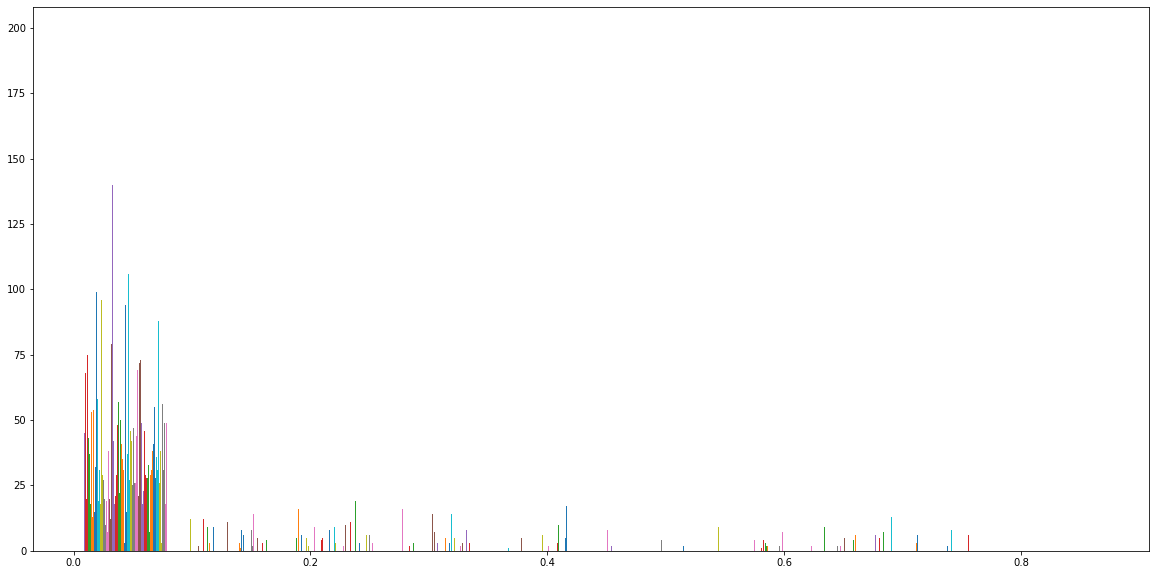

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.hist(cosdist_register_arr.flatten())
plt.show()

## Stanford CTC LOSS

In [ ]:
def ctc_loss(params, seq, blank=0):
    seqLen = seq.shape[0]  # length of label sequence
    numphones = params.shape[0]  # number of labels, not even used in the code
    L = 2*seqLen + 1  # length of the label sequence with blanks
    T = params.shape[1]  # length of utterance (time)

    # print(seqLen, numphones, L, T)

    alphas = np.zeros((L,T))
    betas = np.zeros((L,T))

    # convert logits to log softmax
    params = params - np.max(params,axis=0)
    params = np.exp(params)
    params = params / np.sum(params,axis=0)

    # initialize alphas and forward pass
    alphas[0,0] = params[blank,0]
    alphas[1,0] = params[seq[0],0]
    c = np.sum(alphas[:,0])
    alphas[:,0] = alphas[:,0] / c
    llForward = np.log(c)

    for t in range(1,T):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(start,L):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s==0:
                    alphas[s,t] = alphas[s,t-1] * params[blank,t]
                else:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[blank,t]
            # same label twice
            elif s == 1 or seq[l] == seq[l-1]:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[seq[l],t]
            else:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1] + alphas[s-2,t-1]) * params[seq[l],t]

        # normalize at current time (prevent underflow)
        c = np.sum(alphas[start:end,t])
        alphas[start:end,t] = alphas[start:end,t] / c
        llForward += np.log(c)

    # initialize betas and backwards pass
    betas[-1,-1] = params[blank,-1]
    betas[-2,-1] = params[seq[-1],-1]
    c = np.sum(betas[:,-1])
    betas[:,-1] = betas[:,-1] / c
    llBackward = np.log(c)

    for t in range(T-2,-1,-1):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(end-1,-1,-1):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s == L-1:
                    betas[s,t] = betas[s,t+1] * params[blank,t]
                else:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[blank,t]
            # same label twice
            elif s == L-2 or seq[l] == seq[l+1]:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[seq[l],t]
            else:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1] + betas[s+2,t+1]) * params[seq[l],t]

        # normalize at current time
        c = np.sum(betas[start:end,t])
        betas[start:end,t] = betas[start:end,t] / c
        llBackward += np.log(c)

    # Compute gradient with respect to unnormalized input parameters
    grad = np.zeros(params.shape)
    ab = alphas*betas
    for s in range(L):
        l = int((s-1)/2)
        # blank
        if s%2 == 0:
            grad[blank,:] += ab[s,:]
            ab[s,:] = ab[s,:]/params[blank,:]
        else:
            grad[seq[l],:] += ab[s,:]
            ab[s,:] = ab[s,:]/(params[seq[l],:])
    absum = np.sum(ab,axis=0)

    # Check for underflow or zeros in denominator of gradient
    llDiff = np.abs(llForward-llBackward)
    if llDiff > 1e-5 or np.sum(absum==0) > 0:
        print("Diff in forward/backward LL : %f"%llDiff)
        print("Zeros found : (%d/%d)"%(np.sum(absum==0),absum.shape[0]))
        # print(-llForward, grad)
        return (-llForward, grad)
    else:
        grad = params - grad / (params * absum)
        # print(-llForward, grad)
        return (-llForward, grad)

In [8]:
def ctc_loss_tensor(logits, seq, cosdist_for_ctc, blank=0):

    cosdist_contribution_alphas = []
    cosdist_contribution_betas = []

    params = logits.transpose(1,0)

    seqLen = seq.shape[0]  # length of label sequence
    L = 2*seqLen + 1  # length of the label sequence with blanks
    T = params.shape[1]  # length of utterance (time)
    numphones = params.shape[0]  # number of labels/characters in "alphabet"

    # print("label seq:", seqLen)
    # print("label seq length with blanks:", L)
    # print("utterance length:", T)

    alphas = torch.zeros((L,T))
    betas = torch.zeros((L,T))

    # convert logits to log probs
    params = params - (torch.max(params, dim=0)[0])
    params = torch.exp(params)
    params = params / torch.sum(params, dim=0)

    # initialize alphas and forward pass
    alphas[0,0] = params[blank,0]
    alphas[1,0] = params[seq[0],0]
    c = torch.sum(alphas[:,0])
    alphas[:,0] = alphas[:,0] / c
    llForward = torch.log(c)

    for t in range(1,T):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(start,L):
            l = int((s-1)/2)
            # print(0, L-2*(T-t), "time:", t, "start:", start, "L:", L, "s:", s, "l:", l)
            # blank
            if s%2 == 0:
                if s==0:
                    alphas[s,t] = alphas[s,t-1] * params[blank,t]
                else:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[blank,t]
            # same label twice
            elif s == 1 or seq[l] == seq[l-1]:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[seq[l],t]
                cosdist_contribution_alphas.append(cosdist_for_ctc[l])
            else:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1] + alphas[s-2,t-1]) * params[seq[l],t]
                cosdist_contribution_alphas.append(cosdist_for_ctc[l])

        # normalize at current time (prevent underflow)
        c = torch.sum(alphas[start:end,t])
        alphas[start:end,t] = alphas[start:end,t] / c
        llForward = llForward + torch.log(c)

    # initialize betas and backwards pass
    betas[-1,-1] = params[blank,-1]
    betas[-2,-1] = params[seq[-1],-1]
    c = torch.sum(betas[:,-1])
    betas[:,-1] = betas[:,-1] / c
    llBackward = torch.log(c)

    for t in range(T-2,-1,-1):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(end-1,-1,-1):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s == L-1:
                    betas[s,t] = betas[s,t+1] * params[blank,t]
                else:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[blank,t]
            # same label twice
            elif s == L-2 or seq[l] == seq[l+1]:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[seq[l],t]
                cosdist_contribution_betas.append(cosdist_for_ctc[l])
            else:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1] + betas[s+2,t+1]) * params[seq[l],t]
                cosdist_contribution_betas.append(cosdist_for_ctc[l])

        # normalize at current time
        c = torch.sum(betas[start:end,t])
        betas[start:end,t] = betas[start:end,t] / c
        llBackward = llBackward + torch.log(c)

    # Compute gradient with respect to unnormalized input parameters
    grad = torch.zeros(params.shape)
    ab = alphas*betas
    for s in range(L):
        l = int((s-1)/2)
        # blank
        if s%2 == 0:
            grad[blank,:] = grad[blank,:] + ab[s,:]
            ab[s,:] = ab[s,:]/params[blank,:]
        else:
            grad[seq[l],:] = grad[seq[l],:] + ab[s,:]
            ab[s,:] = ab[s,:]/(params[seq[l],:])
    absum = torch.sum(ab,axis=0)

    # Check for underflow or zeros in denominator of gradient
    # llDiff = torch.abs(llForward-llBackward)
    # if llDiff > 1e-5 or torch.sum(absum==0) > 0:
    #     print("Diff in forward/backward LL : %f"%llDiff)
    #     print("Zeros found : (%d/%d)"%(torch.sum(absum==0),absum.shape[0]))
    #     return (-llForward, grad)
    # else:
    #     grad = params - grad / (params * absum)
    #     return (-llForward, grad)

    for t in range(T):
        for s in range(numphones):
            tmp = (params[s,t]*absum[t])
            if tmp > 0:
                grad[s,t] = params[s,t] - grad[s,t] / tmp
            else:
                grad[s,t] = params[s,t]

    return (-llForward, grad, sum(cosdist_contribution_alphas), sum(cosdist_contribution_betas))

In [8]:
def ctc_loss_newgrad(logits, seq, blank=0):
    params = logits.transpose(1,0)

    seqLen = seq.shape[0]  # length of label sequence
    L = 2*seqLen + 1  # length of the label sequence with blanks
    T = params.shape[1]  # length of utterance (time)
    numphones = params.shape[0]  # number of labels/characters in "alphabet"

    alphas = torch.zeros((L,T))
    betas = torch.zeros((L,T))

    # convert logits to log probs
    params = params - (torch.max(params, dim=0)[0])
    params = torch.exp(params)
    params = params / torch.sum(params, dim=0)

    # initialize alphas and forward pass
    alphas[0,0] = params[blank,0]
    alphas[1,0] = params[seq[0],0]
    c = torch.sum(alphas[:,0])
    alphas[:,0] = alphas[:,0] / c
    llForward = torch.log(c)

    for t in range(1,T):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(start,L):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s==0:
                    alphas[s,t] = alphas[s,t-1] * params[blank,t]
                else:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[blank,t]
            # same label twice
            elif s == 1 or seq[l] == seq[l-1]:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[seq[l],t]
            else:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1] + alphas[s-2,t-1]) * params[seq[l],t]

        # normalize at current time (prevent underflow)
        c = torch.sum(alphas[start:end,t])
        alphas[start:end,t] = alphas[start:end,t] / c
        llForward = llForward + torch.log(c)

    # initialize betas and backwards pass
    betas[-1,-1] = params[blank,-1]
    betas[-2,-1] = params[seq[-1],-1]
    c = torch.sum(betas[:,-1])
    betas[:,-1] = betas[:,-1] / c
    llBackward = torch.log(c)

    for t in range(T-2,-1,-1):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(end-1,-1,-1):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s == L-1:
                    betas[s,t] = betas[s,t+1] * params[blank,t]
                else:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[blank,t]
            # same label twice
            elif s == L-2 or seq[l] == seq[l+1]:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[seq[l],t]
            else:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1] + betas[s+2,t+1]) * params[seq[l],t]

        # normalize at current time
        c = torch.sum(betas[start:end,t])
        betas[start:end,t] = betas[start:end,t] / c
        llBackward = llBackward + torch.log(c)

    # Compute gradient according to https://github.com/yehudabab/NumpyCTC/blob/main/ctc.py
    padded_labels = torch.zeros((L))

    j = 0
    for i in range(L):
        if i%2 == 0:
            padded_labels[i] = 0
        else:
            padded_labels[i] = seq[j]
            j += 1

    # print(len(seq), seq)
    # print(len(padded_labels), padded_labels)

    grad = torch.zeros(params.shape)

    score_last = alphas[L-1, T-1]
    score_before_last = betas[L-2, T-1]
    p_l_given_ctc = score_last + score_before_last

    for t in range(T):
        for k in range(numphones):
            d_p_d_ytk = 0
            lb_lk = np.nonzero(list(map(lambda x: 1 if k in x else 0, padded_labels)))[0]
            for s in lb_lk:
                d_p_d_ytk += alphas[s, t] * betas[s, t]

            d_p_d_ytk /= (params[k, t] ** 2)
            d_lnp_d_ytk = (1. / p_l_given_ctc) * d_p_d_ytk
            grad[k, t] = d_lnp_d_ytk

    return (-llForward, grad)

## Trying out Stanford CTC Loss script

### Just 1 example

In [19]:
output = model(**batch)

In [ ]:
output

In [ ]:
logits = output["logits"][0].detach().cpu().numpy().transpose()
seq = batch["labels"][0].detach().cpu().numpy()

loss, grad = ctc_loss(logits, seq.squeeze(), blank=0)
print(loss)

In [ ]:
token_ids = torch.argmax(output["logits"][0], dim=1)
print(token_ids)
for token in token_ids:
    if token == 33:
        print("HUY")

decoded_tokens = []
for token in token_ids:
    decoded_tokens.append(model_tokenizer.decode(token))
print(decoded_tokens)

In [ ]:
import torch.nn.functional as F

logits = output["logits"][0]
log_probs = F.log_softmax(logits, dim=-1, dtype=torch.float32)
targets = batch["labels"][0]
input_lengths = torch.tensor(output["logits"][0].shape[0])
target_lengths = torch.tensor(batch["labels"][0].shape[0])

loss = F.ctc_loss(log_probs=log_probs, targets=targets, input_lengths=input_lengths, target_lengths=target_lengths, reduction="sum")
print(loss)

In [ ]:
logits = output["logits"][0].transpose(1,0)
seq = batch["labels"][0]

loss, grad = ctc_loss_tensor(logits, seq, blank=0)
print(loss)

In [ ]:
set(token_ids.tolist())

In [ ]:
print(grad.shape)
transposed_grad = grad.transpose(1,0)
print(transposed_grad.shape)

In [ ]:
for i in range(34):
    print(i, model_tokenizer.decode(i))

In [ ]:
for i in range(grad.shape[0]):
    print(i, grad[i])

In [ ]:
seq

### batched input

In [9]:
output = model(**batch)
output_logits = output["logits"]
labels = batch["labels"]

In [12]:
grad_to_inspect = []

pred_str = processor.batch_decode(output_logits.detach().numpy()).text
labels = batch["labels"]
labels_str = processor_woLM.batch_decode(labels, group_tokens=False)

for i, logits in enumerate(output_logits):
    ref_text = labels_str[i].replace("[UNK]", "")
    pred_text = pred_str[i].replace("[UNK]", "")

    label_ids = labels[i]
    labels_mask = label_ids >= 0
    flattened_labels = label_ids.masked_select(labels_mask)

    ref_alignments = get_asd_align(ref_text, pred_text, asd_model, asd_tokenizer)
    tokens_compressed = get_per_token_cosdist(ref_alignments)
    cosdist_for_ctc = get_cosdist_for_ctc(tokens_compressed, flattened_labels)

    loss, grad, cosdist_contribution_alphas, cosdist_contribution_betas = ctc_loss_tensor(logits, flattened_labels, cosdist_for_ctc)
    grad_to_inspect.append(grad)

    print("cosdist alphas:", cosdist_contribution_alphas)
    print("cosdist betas:", cosdist_contribution_betas)
    print(logits.shape, loss)

cosdist alphas: 845.0103612840176
cosdist betas: 972.7007383406162
torch.Size([201, 34]) tensor(608.0905, grad_fn=<NegBackward0>)
cosdist alphas: 0
cosdist betas: 0
torch.Size([201, 34]) tensor(1854.4355, grad_fn=<NegBackward0>)
cosdist alphas: 606.3643108587712
cosdist betas: 550.9175247717649
torch.Size([201, 34]) tensor(680.7924, grad_fn=<NegBackward0>)
cosdist alphas: 0
cosdist betas: 0
torch.Size([201, 34]) tensor(1999.4266, grad_fn=<NegBackward0>)
cosdist alphas: 0
cosdist betas: 0
torch.Size([201, 34]) tensor(1113.2689, grad_fn=<NegBackward0>)
cosdist alphas: 307.15736174583435
cosdist betas: 318.57188880443573
torch.Size([201, 34]) tensor(2163.9688, grad_fn=<NegBackward0>)
cosdist alphas: 2056.844472726263
cosdist betas: 1902.4644071857585
torch.Size([201, 34]) tensor(860.0428, grad_fn=<NegBackward0>)


In [ ]:
for logits in output_logits:
    token_ids = torch.argmax(logits, dim=1)
    print(token_ids)

    decoded_tokens = []
    for token in token_ids:
        decoded_tokens.append(model_tokenizer.decode(token))
    print(decoded_tokens)

In [10]:
# comparing only the first utterance
model.train()
output = model(**batch)
output_logits = output["logits"]
labels = batch["labels"]

logits = output_logits[0]
label_ids = labels[0]
labels_mask = label_ids >= 0
flattened_labels = label_ids.masked_select(labels_mask)

In [11]:
logits.shape

torch.Size([235, 34])

In [13]:
# python-implemented CTC loss
loss, grad = ctc_loss_tensor(logits, flattened_labels)
print(loss)
print(grad.shape)

# for i, item in enumerate(grad):
#     print(i, item)

tensor(532.6441, grad_fn=<NegBackward0>)
torch.Size([34, 235])


In [14]:
loss, grad = ctc_loss_newgrad(logits, flattened_labels)
print(loss)
print(grad.shape)

# for i, item in enumerate(grad):
#     print(i, item)

tensor(532.6441, grad_fn=<NegBackward0>)
torch.Size([34, 235])


In [15]:
# pytorch CTC loss
import torch.nn.functional as F
log_probs = F.log_softmax(logits, dim=-1, dtype=torch.float32)
input_lengths = torch.tensor(logits.shape[0])
target_lengths = labels_mask.sum(-1)

loss = F.ctc_loss(log_probs=log_probs, targets=flattened_labels, input_lengths=input_lengths, target_lengths=target_lengths, reduction="sum")
print(loss)

# loss.backward()

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.grad)
#         print(param.grad.shape)

tensor(532.6440, grad_fn=<SumBackward0>)


## Incorporating ASD into CTC Loss

### NOTE: start running here! (when loading from pickle)

In [ ]:
# NOV-8 DATA
# ref = "wozniackis drøm om seier knust av russiske jekaterina"
# hyp = "asnake drøm om sier knut av russiske karine"

# logit_frames_decoded = pickle.load(open("logit_frames_decoded_8Nov.pkl", "rb"))

# alignment_table = [logit_frames_decoded]
# table = tabulate(alignment_table, tablefmt="html")
# print("logits decoded")
# display(HTML(table))

### ASD metric

In [6]:
# LOADING THE MODEL FOR ASD METRIC
modelname = 'ltg/norbert2'
asd_model = BertModel.from_pretrained(modelname)
asd_tokenizer = AutoTokenizer.from_pretrained(modelname)

Some weights of the model checkpoint at ltg/norbert2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# returning ASD cosdist alignment to reference tokens

def get_asd_align(ref, hyp, asd_model, asd_tokenizer):
    tokenized_ref = asd_tokenizer(ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = asd_tokenizer(hyp, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()
    hyp_input_ids = tokenized_hyp["input_ids"].squeeze()

    with torch.no_grad():
        model_output_ref = asd_model(**tokenized_ref, output_hidden_states=True)
        model_output_hyp = asd_model(**tokenized_hyp, output_hidden_states=True)
    hidden_states_ref = model_output_ref.hidden_states
    hidden_states_hyp = model_output_hyp.hidden_states
    all_layers_reference = []
    all_layers_hypothesis = []
    for i in range(1,13):
        all_layers_reference.append(hidden_states_ref[i].squeeze())
        all_layers_hypothesis.append(hidden_states_hyp[i].squeeze())
    ref_embedding_sequence = torch.stack(all_layers_reference).mean(dim=0)
    hyp_embedding_sequence = torch.stack(all_layers_hypothesis).mean(dim=0)

    alignment = dtw(hyp_embedding_sequence, ref_embedding_sequence, dist_method=distance.cosine, keep_internals=True)
    num_tokens = len(ref_embedding_sequence)
    asd_score = (alignment.distance / num_tokens)

    ref_alignment_idxs = alignment.index2
    hyp_alignment_idxs = alignment.index1

    cosdist_alignment_tokens = []  # FOR PRINTING
    ref_alignments = []
    # hyp_alignments = []
    for i in range(len(ref_alignment_idxs)):
        ref_embedding = ref_embedding_sequence[ref_alignment_idxs[i]]
        hyp_embedding = hyp_embedding_sequence[hyp_alignment_idxs[i]]
        cosdist = distance.cosine(ref_embedding, hyp_embedding)
        cosdist_alignment_tokens.append(round(cosdist, 3))  # FOR PRINTING
        ref_token = asd_tokenizer.convert_ids_to_tokens(ref_input_ids[ref_alignment_idxs[i]].reshape(1))[0]
        # hyp_token = asd_tokenizer.convert_ids_to_tokens(hyp_input_ids[hyp_alignment_idxs[i]].reshape(1))[0]
        ref_alignments.append((ref_alignment_idxs[i], ref_token, cosdist))
        # hyp_alignments.append((hyp_alignment_idxs[i], hyp_token, cosdist))

    # FOR PRINTING
    # ref_alignment_input_ids = np.empty(len(ref_alignment_idxs), dtype=int)
    # for i, index in enumerate(ref_alignment_idxs):
    #     ref_alignment_input_ids[i] = (ref_input_ids[index])
    # ref_alignment_tokens = asd_tokenizer.convert_ids_to_tokens(torch.from_numpy(ref_alignment_input_ids))

    # hyp_alignment_input_ids = np.empty(len(hyp_alignment_idxs), dtype=int)
    # for i, index in enumerate(hyp_alignment_idxs):
    #     hyp_alignment_input_ids[i] = (hyp_input_ids[index])
    # hyp_alignment_tokens = asd_tokenizer.convert_ids_to_tokens(torch.from_numpy(hyp_alignment_input_ids))

    # hyp_alignment_tokens.insert(0, "HYP:")
    # ref_alignment_tokens.insert(0, "REF:")
    # cosdist_alignment_tokens.insert(0, "CosDist:")
    # alignment_table = [ref_alignment_tokens, hyp_alignment_tokens, cosdist_alignment_tokens]
    # table = tabulate(alignment_table, tablefmt="html")

    # print("Token alignment table:")
    # display(HTML(table))

    return ref_alignments

In [8]:
def get_per_token_cosdist(asd_alignments):
    # collapse repetitions in tokens and wordpieces in the HYP alignment from ASD
    clean_alignment = []
    for i, item in enumerate(asd_alignments):
        if i < (len(asd_alignments) - 1):
            if len(clean_alignment) == 0:
                if item[1] != "[CLS]" and item[1] != "[SEP]":
                    clean_alignment.append(item)
            else:
                if item[0] == clean_alignment[-1][0]:
                    averaged_cosdist = sum([item[2], clean_alignment[-1][2]]) / 2
                    clean_alignment.pop(-1)
                    clean_alignment.append((item[0], item[1], averaged_cosdist))
                else:
                    clean_alignment.append(item)

    # GROUPING THE TOKENS FROM ASD CALCULATION, SUCH THAT WORDPIECES ARE TOGETHER
    regrouped_tokens = []
    for i, item in enumerate(clean_alignment):
        if item[1] != "[CLS]" and item[1] != "[SEP]":
            if "##" not in item[1]:
                if i < (len(clean_alignment)-1) and "##" in clean_alignment[i+1][1]:  # start of a group of wordpieces
                    wordpiece_group = []
                    wordpiece_group.append(item)
                    regrouped_tokens.append(wordpiece_group)
                else:
                    regrouped_tokens.append(item)
            elif "##" in item[1]:  # parts of the word
                wordpiece_group.append(item)

    # COLLAPSE WORDPIECES INTO WORDS & TAKE AVERAGE OF COSDIST
    tokens_compressed = []
    for token_group in regrouped_tokens:
        if isinstance(token_group, list):
            wp_combined = ''.join([wordpiece[1].replace("##", "") for wordpiece in token_group])
            token_ave_cosdist = sum([wordpiece[2] for wordpiece in token_group]) / len(token_group)
            tokens_compressed.append(("combined", wp_combined, token_ave_cosdist))
        else:
            tokens_compressed.append(token_group)

    return tokens_compressed

In [14]:
# aligning ASD cosdist values to label sequence
def get_cosdist_for_ctc(tokens_compressed, label_ids):
    cosdist_for_ctc = []
    token_count = 0
    for i, label in enumerate(label_ids):
        # for the first utterance
        if len(cosdist_for_ctc) == 0 or all(cosdist == 0 for cosdist in cosdist_for_ctc):
            if label == 0 or label > 29:
                cosdist_for_ctc.append(0)
            else:
                cosdist_for_ctc.append(tokens_compressed[token_count][2])
        # for the next utterances
        else:
            if label == 0:
                cosdist_for_ctc.append(0)
                if i < (len(label_ids)-1) and 0 < label_ids[i+1] < 30:
                    token_count += 1
            else:
                cosdist_for_ctc.append(tokens_compressed[token_count][2])
    # print(tokens_compressed)
    # if len(label_ids) == len(cosdist_for_ctc):
    #     print("SAME")
    # else:
    #     print("DIFF!")
    # for i, label in enumerate(label_ids):
    #     print(label, cosdist_for_ctc[i])

    # try normalizing
    x = np.array(cosdist_for_ctc)
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))

    if np.isnan(np.sum(x_norm)):
        print("boo!")

    return cosdist_for_ctc, x_norm

In [15]:
output = model(**batch)
output_logits = output["logits"]
labels = batch["labels"]

pred_str = processor.batch_decode(output_logits.detach().numpy()).text
labels = batch["labels"]
labels_str = processor_woLM.batch_decode(labels, group_tokens=False)

for i, logits in enumerate(output_logits):
    ref_text = labels_str[i].replace("[UNK]", "")
    pred_text = pred_str[i].replace("[UNK]", "")

    label_ids = labels[i]
    labels_mask = label_ids >= 0
    flattened_labels = label_ids.masked_select(labels_mask)

    max_per_frame = torch.argmax(logits, dim=1)
    relevant_frames = []
    for max_id in max_per_frame:
        if max_id in flattened_labels:
            relevant_frames.append(1)
        else:
            relevant_frames.append(0)

    ref_alignments = get_asd_align(ref_text, pred_text, asd_model, asd_tokenizer)
    tokens_compressed = get_per_token_cosdist(ref_alignments)
    cosdist_for_ctc, x_norm = get_cosdist_for_ctc(tokens_compressed, flattened_labels)

    print(cosdist_for_ctc)
    print(x_norm)

[0.07505041360855103, 0.07505041360855103, 0.07505041360855103, 0, 0.12715423107147217, 0.12715423107147217, 0.12715423107147217, 0, 0.029700636863708496, 0, 0.13597166538238525, 0.13597166538238525, 0, 0.5323134958744049, 0.5323134958744049, 0, 0.21112477779388428, 0.21112477779388428, 0.21112477779388428, 0.21112477779388428, 0, 0.021208584308624268, 0.021208584308624268, 0.021208584308624268, 0.021208584308624268, 0.021208584308624268, 0.021208584308624268, 0.021208584308624268, 0.021208584308624268, 0.021208584308624268, 0.021208584308624268, 0, 0.017002344131469727, 0.017002344131469727, 0.017002344131469727, 0.017002344131469727, 0.017002344131469727, 0.017002344131469727, 0.017002344131469727, 0.017002344131469727, 0.017002344131469727, 0.017002344131469727, 0.017002344131469727, 0.017002344131469727, 0, 0.022676706314086914, 0.022676706314086914, 0.022676706314086914, 0.022676706314086914, 0, 0.6916015446186066, 0.6916015446186066, 0, 0.15313732624053955, 0.15313732624053955, 0

/tmp/ipykernel_4022911/3475542975.py:30: RuntimeWarning: invalid value encountered in true_divide
  x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))


[0.007969975471496582, 0.007969975471496582, 0.007969975471496582, 0, 0.006086826324462891, 0.006086826324462891, 0, 0.006697893142700195, 0.006697893142700195, 0.006697893142700195, 0.006697893142700195, 0.006697893142700195, 0, 0.015287041664123535, 0.015287041664123535, 0, 0.0193021297454834, 0.0193021297454834, 0, 0.2972220443189144, 0.2972220443189144, 0.2972220443189144, 0.2972220443189144, 0.2972220443189144, 0.2972220443189144, 0.2972220443189144, 0.2972220443189144, 0.2972220443189144, 0.2972220443189144]
[0.02681489 0.02681489 0.02681489 0.         0.02047905 0.02047905
 0.         0.02253498 0.02253498 0.02253498 0.02253498 0.02253498
 0.         0.05143307 0.05143307 0.         0.06494178 0.06494178
 0.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
boo!
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan na

### Custom CTC with ASD

In [ ]:
# INCORPORATING ASD COSDIST VALUES TO THE CTC CALCULATION

def ctc_loss_with_ASD(params, seq, cosdist_for_ctc, blank=0):
    seqLen = seq.shape[0]  # length of label sequence
    L = 2*seqLen + 1  # length of the label sequence with blanks
    T = params.shape[1]  # length of utterance (time)

    alphas = torch.zeros((L,T))
    betas = torch.zeros((L,T))

    # convert logits to log probs
    params = params - (torch.max(params, dim=0)[0])
    params = torch.exp(params)
    params = params / torch.sum(params, dim=0)

    # initialize alphas and forward pass
    alphas[0,0] = params[blank,0]
    alphas[1,0] = params[seq[0],0]
    c = torch.sum(alphas[:,0])
    alphas[:,0] = alphas[:,0].clone() / c
    llForward = torch.log(c)

    for t in range(1,T):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(start,L):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s==0:
                    alphas[s,t] = alphas[s,t-1].clone() * params[blank,t]
                else:
                    alphas[s,t] = (alphas[s,t-1].clone() + alphas[s-1,t-1].clone()) * params[blank,t]
            # same label twice
            elif s == 1 or seq[l] == seq[l-1]:
                alphas[s,t] = (alphas[s,t-1].clone() + alphas[s-1,t-1].clone()) * params[seq[l],t] * (1 - cosdist_for_ctc[l])  # scale 0 to 1
            else:
                alphas[s,t] = (alphas[s,t-1].clone() + alphas[s-1,t-1].clone() + alphas[s-2,t-1].clone()) * params[seq[l],t] * (1 - cosdist_for_ctc[l])

        # normalize at current time (prevent underflow)
        c = torch.sum(alphas[start:end,t])
        alphas[start:end,t] = alphas[start:end,t].clone() / c
        llForward = llForward + torch.log(c)

    # initialize betas and backwards pass
    betas[-1,-1] = params[blank,-1]
    betas[-2,-1] = params[seq[-1],-1]
    c = torch.sum(betas[:,-1])
    betas[:,-1] = betas[:,-1].clone() / c
    llBackward = torch.log(c)

    for t in range(T-2,-1,-1):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(end-1,-1,-1):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s == L-1:
                    betas[s,t] = betas[s,t+1].clone() * params[blank,t]
                else:
                    betas[s,t] = (betas[s,t+1].clone() + betas[s+1,t+1].clone()) * params[blank,t]
            # same label twice
            elif s == L-2 or seq[l] == seq[l+1]:
                betas[s,t] = (betas[s,t+1].clone() + betas[s+1,t+1].clone()) * params[seq[l],t] * (1 - cosdist_for_ctc[l])
            else:
                betas[s,t] = (betas[s,t+1].clone() + betas[s+1,t+1].clone() + betas[s+2,t+1].clone()) * params[seq[l],t] * (1 - cosdist_for_ctc[l])

        # normalize at current time
        c = torch.sum(betas[start:end,t])
        betas[start:end,t] = betas[start:end,t].clone() / c
        llBackward = llBackward + torch.log(c)

    # Compute gradient with respect to unnormalized input parameters
    grad = torch.zeros(params.shape)
    ab = alphas*betas
    for s in range(L):
        l = int((s-1)/2)
        # blank
        if s%2 == 0:
            grad[blank,:] = grad[blank,:] + ab[s,:]
            ab[s,:] = ab[s,:]/params[blank,:]
        else:
            grad[seq[l],:] = grad[seq[l],:] + ab[s,:]
            ab[s,:] = ab[s,:]/(params[seq[l],:])
    absum = torch.sum(ab,axis=0)

    # Check for underflow or zeros in denominator of gradient
    llDiff = torch.abs(llForward-llBackward)
    if llDiff > 1e-5 or torch.sum(absum==0) > 0:
        print("Diff in forward/backward LL : %f"%llDiff)
        print("Zeros found : (%d/%d)"%(torch.sum(absum==0),absum.shape[0]))
        # print(-llForward, grad)
        return (-llForward, grad)
    else:
        grad = params - grad / (params * absum)
        # print(-llForward, grad)
        return (-llForward, grad)

### Trying out custom ctc loss

In [ ]:
# from torch.autograd import gradcheck

# output = model(**batch)
# ref = processor_woLM.batch_decode(batch["labels"], group_tokens=False)[0]
# label_ids = batch["labels"][0]
# logits = output["logits"][0]
# hyp = processor.batch_decode(output["logits"].detach().numpy()).text[0]

# ref_alignments = get_asd_align(ref, hyp, asd_model, asd_tokenizer)
# tokens_compressed = get_per_token_cosdist(ref_alignments)
# cosdist_for_ctc = get_cosdist_for_ctc(tokens_compressed, label_ids)

# inputs = (logits.transpose(1,0), label_ids, cosdist_for_ctc)

# test = gradcheck(ctc_loss_with_ASD, inputs)
# print(test)

In [ ]:
# torch.autograd.set_detect_anomaly(True)

output = model(**batch)
ref = processor_woLM.batch_decode(batch["labels"], group_tokens=False)[0]
label_ids = batch["labels"][0]
logits = output["logits"][0]
hyp = processor.batch_decode(output["logits"].detach().numpy()).text[0]

print("REF:", ref)
print("HYP:", hyp)

ref_alignments = get_asd_align(ref, hyp, asd_model, asd_tokenizer)
tokens_compressed = get_per_token_cosdist(ref_alignments)
print(tokens_compressed)
cosdist_for_ctc = get_cosdist_for_ctc(tokens_compressed, label_ids)

loss, grad = ctc_loss_with_ASD(logits.transpose(1,0), label_ids, cosdist_for_ctc, blank=0)
print(loss)

loss.backward()

In [ ]:
import torch.nn.functional as F

log_probs = F.log_softmax(logits, dim=-1, dtype=torch.float32)
input_lengths = torch.tensor(logits.shape[0])
target_lengths = torch.tensor(label_ids.shape[0])

loss = F.ctc_loss(log_probs=log_probs, targets=label_ids, input_lengths=input_lengths, target_lengths=target_lengths, reduction="sum")
print(loss)

### extending torch.autograd

In [ ]:
class MyCTC(torch.autograd.Function):

    @staticmethod
    def forward(ctx, params, seq, cosdist_for_ctc, blank=0):
        seqLen = seq.shape[0]  # length of label sequence
        L = 2*seqLen + 1  # length of the label sequence with blanks
        T = params.shape[1]  # length of utterance (time)

        alphas = torch.zeros((L,T)).double()
        betas = torch.zeros((L,T)).double()

        # convert logits to log probs
        params = params - (torch.max(params, dim=0)[0])
        params = torch.exp(params)
        params = params / torch.sum(params, dim=0)

        # initialize alphas and forward pass
        alphas[0,0] = params[blank,0]
        alphas[1,0] = params[seq[0],0]
        c = torch.sum(alphas[:,0])
        alphas[:,0] = alphas[:,0] / c
        llForward = torch.log(c)

        for t in range(1,T):
            start = max(0,L-2*(T-t))
            end = min(2*t+2,L)
            for s in range(start,L):
                l = int((s-1)/2)
                # blank
                if s%2 == 0:
                    if s==0:
                        alphas[s,t] = alphas[s,t-1] * params[blank,t]
                    else:
                        alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[blank,t]
                # same label twice
                elif s == 1 or seq[l] == seq[l-1]:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[seq[l],t] * (1 - cosdist_for_ctc[l])
                else:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1] + alphas[s-2,t-1]) * params[seq[l],t] * (1 - cosdist_for_ctc[l])

            # normalize at current time (prevent underflow)
            c = torch.sum(alphas[start:end,t])
            alphas[start:end,t] = alphas[start:end,t] / c
            llForward = llForward + torch.log(c)

        # initialize betas and backwards pass
        betas[-1,-1] = params[blank,-1]
        betas[-2,-1] = params[seq[-1],-1]
        c = torch.sum(betas[:,-1])
        betas[:,-1] = betas[:,-1] / c
        llBackward = torch.log(c)

        for t in range(T-2,-1,-1):
            start = max(0,L-2*(T-t))
            end = min(2*t+2,L)
            for s in range(end-1,-1,-1):
                l = int((s-1)/2)
                # blank
                if s%2 == 0:
                    if s == L-1:
                        betas[s,t] = betas[s,t+1] * params[blank,t]
                    else:
                        betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[blank,t]
                # same label twice
                elif s == L-2 or seq[l] == seq[l+1]:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[seq[l],t] * (1 - cosdist_for_ctc[l])
                else:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1] + betas[s+2,t+1]) * params[seq[l],t] * (1 - cosdist_for_ctc[l])

            # normalize at current time
            c = torch.sum(betas[start:end,t])
            betas[start:end,t] = betas[start:end,t] / c
            llBackward = llBackward + torch.log(c)

        ctx.save_for_backward(params, seq, alphas, betas, llForward, llBackward)

        return -llForward

    @staticmethod
    def backward(ctx, grad_output):
        params, seq, alphas, betas, llForward, llBackward = ctx.saved_tensors
        blank = 0
        seqLen = seq.shape[0]  # length of label sequence
        L = 2*seqLen + 1  # length of the label sequence with blanks

        # Compute gradient with respect to unnormalized input parameters
        grad = torch.zeros(params.shape)
        ab = alphas*betas
        for s in range(L):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                grad[blank,:] = grad[blank,:] + ab[s,:]
                ab[s,:] = ab[s,:]/params[blank,:]
            else:
                grad[seq[l],:] = grad[seq[l],:] + ab[s,:]
                ab[s,:] = ab[s,:]/(params[seq[l],:])
        absum = torch.sum(ab,axis=0)

        llDiff = torch.abs(llForward-llBackward)
        if llDiff > 1e-5 or torch.sum(absum==0) > 0:
            return (grad, None, None)
        else:
            grad = params - grad / (params * absum)
            return (grad, None, None)


In [ ]:
# torch.autograd.set_detect_anomaly(True)

output = model(**batch)
ref = processor_woLM.batch_decode(batch["labels"], group_tokens=False)[0]
label_ids = batch["labels"][0]
logits = output["logits"][0]
hyp = processor.batch_decode(output["logits"].detach().numpy()).text[0]

print("REF:", ref)
print("HYP:", hyp)

ref_alignments = get_asd_align(ref, hyp, asd_model, asd_tokenizer)
tokens_compressed = get_per_token_cosdist(ref_alignments)
cosdist_for_ctc = get_cosdist_for_ctc(tokens_compressed, label_ids)
print(tokens_compressed)

myctcloss = MyCTC.apply
loss = myctcloss(logits.transpose(1,0), label_ids, cosdist_for_ctc)
print(loss)

loss.backward()

### other scripts:

In [ ]:
# GROUPING CHARACTERS FROM LOGITS w/ FRAME NOS. & DISREGARDING ALL THE PADS

clean_logit_frames = []
for i, item in enumerate(logit_frames_decoded):
    if item != "[PAD]":
        clean_logit_frames.append((i, item))

char_group_list = []
for i, char in enumerate(clean_logit_frames):
    if i == 0:
        if char[1] == "":
            continue
    else:
        if len(char_group_list) == 0:  # first word
            if char[1] != "":
                new_word = []
                new_word.append(char)
                char_group_list.append(new_word)
        else:
            if clean_logit_frames[i-1][1] == "" and char[1] != "":  # start of the word
                new_word = []
                new_word.append(char)
                char_group_list.append(new_word)
            elif char[1] != "":
                new_word.append(char)
            else:
                continue

for item in char_group_list:
    print(" ".join([char[1] for char in item]))
    print(item)

In [ ]:
# GROUPING CHARACTERS FROM LOGITS MATRIX INTO THEIR CORRESPONDING WORDS, WHILE RETAINING ROW NOS. OR FRAME NOS.

char_group_list = []
for i, char in enumerate(logit_frames_decoded):
    if i == 0:
        if char == "[PAD]" or char == "":
            continue
    else:
        if char == "[PAD]" or char == "":
            continue
        if len(char_group_list) == 0:  # first word
            if logit_frames_decoded[i-1] in ["", "[PAD]"] and char not in ["", "[PAD]"]:
                new_word = []
                new_word.append((i, char))
                char_group_list.append(new_word)
        else:
            if "" in logit_frames_decoded[i-2:i-1] and char not in ["", "[PAD]"]:  # start of the word
                new_word = []
                new_word.append((i, char))
                char_group_list.append(new_word)
            elif logit_frames_decoded[i-1] == char and char != "":  # repeating characters
                new_word.append((i, char))
            elif logit_frames_decoded[i-1] != char and char != "":  # new character detected
                new_word.append((i, char))


for item in char_group_list:
    print(' '.join([char[1] for char in item]))

In [ ]:
if len(char_group_list) == len(regrouped_tokens):
    ASD_cosdist_list = []
    for i, char_group in enumerate(char_group_list):
        # char_group_copy = copy.deepcopy(char_group)
        if isinstance(regrouped_tokens[i], list): # token character list differs when there are whole word tokens or wordpieces
            token_char_list = list(''.join([wordpiece[1].replace("##", "") for wordpiece in regrouped_tokens[i]]))
            token_cosdist = sum([wordpiece[2] for wordpiece in regrouped_tokens[i]])
        else:
            token_char_list = list(regrouped_tokens[i][1])
            token_cosdist = regrouped_tokens[i][2]

        # detecting applicable frames & caclulating average cosdist
        # frame_group = []
        # for token_char in token_char_list:
        #     detect_count = 0
        #     if token_char in [x[1] for x in char_group_copy]:
        #         for i, char in enumerate(char_group_copy):
        #             # print(char[1], token_char, [x[1] for x in char_group_copy])
        #             if char[1] == token_char:
        #                 frame_group.append(char)
        #                 detect_count += 1
        #             else:
        #                 if detect_count > 0:
        #                     for count in range(detect_count):
        #                         char_group_copy.pop(0)
        #                     break
        #     else:
        #         continue
        # cosdist_divided = token_cosdist / len(frame_group)  # divide ASD token cosdist by number of frames for word
        # assign divided ASD token cosdist
        # frame_cosdist = []
        # for char in frame_group:
        #     if char[1] in token_char_list:
        #         frame_cosdist.append((char[0], char[1], cosdist_divided))

        # simpler implementation by not checking if each frame belongs to the decoded word
        # it probably does not need checking anyway since we're taking the whole sequence when decoding
        cosdist_divided = token_cosdist / len(char_group)  # divide ASD token cosdist by number of frames for word utterance
        frame_cosdist = []
        for char in char_group:
            frame_cosdist.append((char[0], char[1], cosdist_divided))
        ASD_cosdist_list.append(frame_cosdist)
else:
    print("logit char grouped frames quantity not equal to regrouped tokens from ASD")

In [ ]:
# DIVIDING THE ASD COSDIST PER NO. FRAMES
if len(char_group_list) == len(regrouped_tokens):
    ASD_cosdist_list = []
    for i, char_group in enumerate(char_group_list):
        # char_group_copy = copy.deepcopy(char_group)
        if isinstance(regrouped_tokens[i], list): # token character list differs when there are whole word tokens or wordpieces
            token_char_list = list(''.join([wordpiece[1].replace("##", "") for wordpiece in regrouped_tokens[i]]))
            token_cosdist = sum([wordpiece[2] for wordpiece in regrouped_tokens[i]])
        else:
            token_char_list = list(regrouped_tokens[i][1])
            token_cosdist = regrouped_tokens[i][2]

        # simpler implementation by not checking if each frame belongs to the decoded word
        # it probably does not need checking anyway since we're taking the whole sequence when decoding
        cosdist_divided = token_cosdist / len(char_group)  # divide ASD token cosdist by number of frames for word utterance
        frame_cosdist = []
        for char in char_group:
            frame_cosdist.append((char[0], char[1], cosdist_divided))
        ASD_cosdist_list.append(frame_cosdist)
else:
    print("logit char grouped frames quantity not equal to regrouped tokens from ASD")